#                         Implémentation d'un modèle de scoring

________________________________________________________________________________________________________________

Une société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.


Elle souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées.


Le projet a donc pour but de :


- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

_________________________________________________________________________________________________________________________


### Fichiers de données
_________________________________________________________________________________________________________________________

Les données en format CSV sont à télecharger de ce lien:
https://www.kaggle.com/c/home-credit-default-risk/data
________________________________________________________________________________________________________________________

##  Importation des librairies Python nécessaires

In [5]:
# Chargement des librairies

import pickle
import sys
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import re
# import phik
# Plotly
import plotly
# import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gc
import lightgbm as lgb
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Modelisation

from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import   make_scorer ,roc_curve,  classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score ,average_precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import shap

# Warnings
plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline


demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par le **SK_ID_CURR**. Les données de la demande de formation sont accompagnées de la **TARGET** indiquant 0 : le prêt a été remboursé et 1 : le prêt n'a pas été remboursé.

2. **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau et est identifié par le SK_ID_BUREAU. Chaque prêt dans les données de l'application peut avoir plusieurs crédits précédents.
3. **bureau_balance**:  données mensuelles sur les crédits précédents dans le bureau. Chaque ligne correspond à un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
4. **previous_application** : demandes de prêt précédentes auprès de Home Credit des clients qui ont des prêts dans les données de la demande. Chaque prêt en cours dans les données d'application peut avoir plusieurs prêts précédents. Chaque application précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
5. **POS_CASH_BALANCE** : données mensuelles sur les points de vente précédents ou les prêts en espèces que les clients ont eus avec Home Credit. Chaque ligne correspond à un mois d'un point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.
6. **credit_card_balance** : données mensuelles sur les cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne correspond à un mois du solde d'une carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
7. **installemnts_payments**: historique de paiement pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

## Chargement du jeu de données

In [6]:
#Chargement des données

application_train = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv")
#-----------------
application_test = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv")
#-----------------
bureau = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv")
#-----------------
bureau_balance = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv")
#-----------------
credit_card_balance = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv")
#-----------------
installments_payments = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv")
#-----------------
POS_CASH_balance = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv")
#-----------------
previous_application = pd.read_csv("C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv")


## Connaissance du jeu de données et Nettoyage

#### DESCRIPTION DU JEU DE DONNEES

In [7]:
#Création d'une fonction pour analyser la structure des dataframes

def data_structure(data):
    ''' Affiche la structure du dataframe'''
    
    # comptage des colonnes numériques et catégorielles
    numeric_columns = len(data.select_dtypes(include = ['int64','float64']).columns)
    categorical_columns= len(data.select_dtypes(include=['object','category']).columns)

    # création d'un dictionnaire avec les items de structure de nos données
    dict_structure = {'Nombre de lignes':data.shape[0], 'Nombre de colonnes':int(data.shape[1]), 
                      'Nombre de variables catégorielles':categorical_columns,
                      'Nombre de variables numériques ':numeric_columns,
                      'Pourcentage de données manquantes':int((data.isnull().sum()/len(data)*100).sum()),
                      'Nombre de doublons':int(len(data[data.duplicated()]))}

    # transformation des éléments du dictionnaire en dataframe
    dataframe =pd.DataFrame(list(dict_structure.items()),columns=['Caractéristiques','Valeurs'])
    return dataframe

In [8]:
# Fonction pour afficher le pourcentage des valeurs nulls et les visualiser 

def valeur_null (df, pourcentage,heatmap):
   

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df.isna().sum().sum()
    nb_donnees_tot = np.product(df.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes :{nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes
        # par variable
        values = df.isnull().sum()
        percentage = 100 * values / len(df)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
               )
    

    if heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df.isna(), cbar=False)
        plt.show()

In [9]:
# Une fonction qui retourne la description des variables qualitatives/quantitatives
def desc_var(df, type_var='all'):
    df_taille = df.shape[0]
    if type_var == 'num':
        desc_var = df.describe()
    elif type_var == 'cat':
        desc_var = df.describe(exclude=[np.number])
    else:
        desc_var = df.describe(include='all')

    desc_type = pd.DataFrame(desc_var.dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / df_taille
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

In [10]:
def missingdata(data, name, larg, long):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(larg,long))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"])
    plt.xlabel('Colonnes', fontsize=15)
    plt.ylabel('% valeurs manquantes', fontsize=15)
    plt.title('Pourcentage de valeurs manquantes ('+name+')', fontsize=22, fontweight='bold')
    #ms= ms[ms["Percent"] > 0]
    #return ms

In [11]:
# -- AFFICHE LA LISTE DES IDENTIFIANTS UNIQUES
# --------------------------------------------------------------------


def print_unique_categories(data, column_name, show_counts=False):
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not
    '''

    print('-' * 79)
    print(
        f"Les catégories uniques de la variable '{column_name}' sont :\n{data[column_name].unique()}")
    print('-' * 79)

    if show_counts:
        print(
            f"Répartition dans chaque catégorie :\n{data[column_name].value_counts()}")
        print('-' * 79)

In [12]:
# -- CARTE THERMIQUE DES VALEURS DU COEFFICIENT DE CORRELATION Phi-K
# --------------------------------------------------------------------


def plot_phik_matrix(data, categorical_columns, figsize=(20, 20),
                     mask_upper=True, tight_layout=True, linewidth=0.1,
                     fontsize=10, cmap='Blues', show_target_top_corr=True,
                     target_top_columns=10):
    '''
    Function to Phi_k matrix for categorical features
    Nous allons tracer une carte thermique des valeurs du coefficient de
    corrélation Phi-K entre les 2 variables.
    Le coefficient Phi-K est similaire au coefficient de corrélation sauf
    qu'il peut être utilisé avec une paire de caractéristiques catégorielles
    pour vérifier si une varaible montre une sorte d'association avec l'autre
    variable catégorielle. Sa valeur maximale peut être de 1, ce qui indique
    une association maximale entre deux variables catégorielles.
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    # first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()

    print('-' * 79)

    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)

    plt.figure(figsize=figsize, tight_layout=tight_layout)
    sns.heatmap(
        phik_matrix,
        annot=False,
        mask=mask_array,
        linewidth=linewidth,
        cmap=cmap)
    plt.xticks(rotation=90, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.title("Phi-K Correlation Heatmap des variables catégorielles",
              fontsize=fontsize+4)
    plt.show()
    
    print("-" * 79)

    if show_target_top_corr:
        # Seeing the top columns with highest correlation with the target
        # variable in application_train
        print("Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :")
        phik_df = pd.DataFrame(
            {'Variable': phik_matrix.TARGET.index[1:], 'Phik-Correlation': phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by='Phik-Correlation', ascending=False)
        display(phik_df.head(target_top_columns).style.hide_index())
        print("-" * 79)


In [13]:
# -- MATRICE DE CORRELATION POUR LES VARIABLES NUMERIQUES
# --------------------------------------------------------------------


class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''

    def __init__(
            self,
            data,
            columns_to_drop,
            figsize=(
                25,
                23),
            mask_upper=True,
            tight_layout=True,
            linewidth=0.1,
            fontsize=10,
            cmap='Blues'):
        '''
        Function to initialize the class members.
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap
        Returns:
            None
        '''

        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap

    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        Inputs:
            self
        Returns:
            None
        '''

        # print('-' * 79)
        # building the correlation dataframe
        self.corr_data = self.data.drop(
            self.columns_to_drop + ['TARGET'], axis=1).corr()

        if self.mask_upper:
            # masking the heatmap to show only lower triangle. This is to save
            # the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize=self.figsize, tight_layout=self.tight_layout)
        sns.heatmap(
            self.corr_data,
            annot=False,
            mask=mask_array,
            linewidth=self.linewidth,
            cmap=self.cmap)
        plt.xticks(rotation=90, fontsize=self.fontsize)
        plt.yticks(fontsize=self.fontsize)
        plt.title("Heatmap de corrélation des variables numériques", fontsize=20)
        plt.show()
        # print("-" * 100)

    def target_top_corr(self, target_top_columns=10):
        '''
        Function to return the Top Correlated features with the Target
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
        Returns:
            Top correlated features DataFrame.
        '''

        phik_target_arr = np.zeros(self.corr_data.shape[1])
        # calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[[
                'TARGET', column]].phik_matrix().iloc[0, 1]
        # getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame(
            {'Column Name': self.corr_data.columns, 'Phik-Correlation': phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(
            by='Phik-Correlation', ascending=False)

        return top_corr_target_df.iloc[:target_top_columns]


In [14]:
# -- AFFICHE LA LISTE DES IDENTIFIANTS UNIQUES
# --------------------------------------------------------------------


def print_unique_categories(data, column_name, show_counts=False):
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not
    '''

    print('-' * 79)
    print(
        f"Les catégories uniques de la variable '{column_name}' sont :\n{data[column_name].unique()}")
    print('-' * 79)

    if show_counts:
        print(
            f"Répartition dans chaque catégorie :\n{data[column_name].value_counts()}")
        print('-' * 79)



In [15]:
# -- PIEPLOT DES VARIABLES CATEGORIELLES
# --------------------------------------------------------------------


def plot_categorical_variables_pie(
        data,
        column_name,
        plot_defaulter=True,
        hole=0):
    '''
    Function to plot categorical variables Pie Plots
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    if plot_defaulter:
        cols = 2
        specs = [[{'type': 'domain'}, {'type': 'domain'}]]
        titles = ['Toutes TARGET', 'Défaillants seuls']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Répartition de la variable {column_name}']

    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index

    fig = make_subplots(rows=1, cols=cols,
                        specs=specs,
                        subplot_titles=titles)

    fig.add_trace(
        go.Pie(
            values=values_categorical,
            labels=labels_categorical,
            hole=hole,
            textinfo='percent',
            textposition='inside'),
        row=1,
        col=1)

    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts(
        ) * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace=True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(
            2)

        fig.add_trace(
            go.Pie(
                values=percentage_defaulter_per_category,
                labels=percentage_defaulter_per_category.index,
                hole=hole,
                textinfo='percent',
                hoverinfo='label+value'),
            row=1,
            col=2)

    fig.update_layout(title=f'Répartition de la variable {column_name}')
    fig.show()

# -- BARPLOT DES VARIABLES CATEGORIELLES
# --------------------------------------------------------------------


def plot_categorical_variables_bar(data, column_name, figsize=(18, 6),
                                   percentage_display=True,
                                   plot_defaulter=True, rotation=0,
                                   horizontal_adjust=0,
                                   fontsize_percent='xx-small',
                                   palette1='Set1',
                                   palette2='Set2'):
    '''
    Function to plot Categorical Variables Bar Plots
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
    '''

    print(
        f"Nombre de catégories uniques pour {column_name} = {len(data[column_name].unique())}")

    plt.figure(figsize=figsize, tight_layout=True)
    sns.set(style='whitegrid', font_scale=1.2)

    # plotting overall distribution of category
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette=palette1)

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(
                p.get_x() +
                horizontal_adjust,
                p.get_height() +
                0.005 *
                total_datapoints,
                '{:1.02f}%'.format(
                    p.get_height() *
                    100 /
                    total_datapoints),
                fontsize=fontsize_percent)

    plt.xlabel(column_name, labelpad=10)
    plt.title('Toutes TARGET', pad=20, fontsize=30)
    plt.xticks(rotation=rotation, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Nombre', fontsize=20)

    # plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts(
        ) * 100 / data[column_name].value_counts()).dropna().sort_values(ascending=False)

        plt.subplot(1, 2, 2)
        sns.barplot(x=percentage_defaulter_per_category.index,
                    y=percentage_defaulter_per_category, palette=palette2)
        plt.ylabel(
            'Pourcentage par catégorie pour les défaillants',
            fontsize=20)
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation, fontsize=20)
        plt.yticks(fontsize=20)
        plt.title('Défaillants seuls', pad=20, fontsize=30)

    plt.suptitle(f'Répartition de {column_name}', fontsize=40)
    plt.show()


In [16]:
# -- barplot DES VARIABLES 
# --------------------------------------------------------------------

def plot_barplot_comp_target(dataframe, feature_name,
                             labels=['Non-défaillant', 'Défaillant'],
                             palette=['SteelBlue', 'crimson'],
                             rotation=0):
    '''
    Barplot de comparaison des catégories par target.
    Parameters
    ----------
    dataframe : dataframe, obligatoire.
    feature_name : variable, obligatoire.
    Returns
    -------
    None.
    '''
    sns.countplot(x=dataframe[feature_name], hue=dataframe.TARGET,
                  data=dataframe, palette=palette)
    plt.xticks(rotation=rotation)
    plt.title(f'Distribution de {feature_name} par défaillant/non-défaillant')
    plt.legend(labels=labels,
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [17]:
#-- AFFICHE DISTPLOT ou CDF ou BOXPLOT ou VIOLINPLOT DES VARIABLES CONTINUES
# --------------------------------------------------------------------


def plot_continuous_variables(data, column_name,
                              plots=['distplot', 'CDF', 'box', 'violin'], 
                              scale_limits=None, figsize=(20, 9),
                              histogram=True, log_scale=False,
                              palette=['SteelBlue', 'Crimson']):
    '''
    Function to plot continuous variables distribution
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        # taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(
            data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize=figsize)
    sns.set_style('whitegrid')

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if ele == 'CDF':
            # making the percentile DataFrame for both positive and negative
            # Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[
                column_name]].dropna().sort_values(by=column_name)
            percentile_values_0['Percentile'] = [
                ele / (len(percentile_values_0) - 1) for ele in range(len(percentile_values_0))]

            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[
                column_name]].dropna().sort_values(by=column_name)
            percentile_values_1['Percentile'] = [
                ele / (len(percentile_values_1) - 1) for ele in range(len(percentile_values_1))]

            plt.plot(
                percentile_values_0[column_name],
                percentile_values_0['Percentile'],
                color='SteelBlue',
                label='Non-Défaillants')
            plt.plot(
                percentile_values_1[column_name],
                percentile_values_1['Percentile'],
                color='crimson',
                label='Défaillants')
            plt.xlabel(column_name, fontsize=16)
            plt.ylabel('Probabilité', fontsize=16)
            plt.title('CDF de {}'.format(column_name), fontsize=18)
            plt.legend(fontsize='medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')

        if ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(
            ), label='Non-Défaillants', hist=False, color='SteelBlue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(
            ), label='Défaillants', hist=False, color='Crimson')
            plt.xlabel(column_name, fontsize=16)
            plt.ylabel('Probability Density', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.legend(fontsize=18)
            plt.title("Dist-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)', fontsize=16)

        if ele == 'violin':
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot, palette=palette)
            plt.title("Violin-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot, palette=palette)
            plt.title("Box-Plot de {}".format(column_name), fontsize=18)
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)', fontsize=16)
            plt.xlabel('TARGET', fontsize=16)
            plt.ylabel(f'{column_name}', fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)

    plt.show()

In [18]:
# -- AFFICHE LES QUANTILES POUR LA VARIABLE
# --------------------------------------------------------------------


def print_percentiles(data, column_name, percentiles=None):
    '''
    Function to print percentile values for given column
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    print('-' * 79)
    print(f'Pecentiles de la variable {column_name}')
    if not percentiles:
        percentiles = list(range(0, 80, 25)) + list(range(90, 101, 2))
    for i in percentiles:
        
        print(
            f'Pecentile {i} = {np.percentile(data[column_name].dropna(), i)}')
    print("-" * 79)
    
    

## Kernel utilisé comme base pour l'EDA


- Le Kernel Kaggle utilisé pour l'analyse exploratoire a effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par Rishabh Rao (Student at -Jaipur, Rajasthan, India).: https://www.kaggle.com/code/rishabhrao/home-credit-default-risk-extensive-eda/notebook



- Ce travail est complété par l'auteur par une présentation sur le site medium.com :https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a


 ## application_train and application_test

### application_train



Il s'agit de la source de données principale. Chaque observation représente une demande de crédit identifiée par la variable **SK_ID_CURR* (clé primaire).



Ce jeu de données comprend également la variable cible qui peut prendre 2 valeurs (**0**: le crédit a été remboursé; **1**: le crédit n'a pas été remboursé).

- Il représente donc la source principale de données d'entraînement pour la modélisation de systèmes d'apprentissage supervisé.

In [19]:
#la structure des dataframes
data_structure(application_train)

Caractéristiques  Valeurs
0                   Nombre de lignes   307511
1                 Nombre de colonnes      122
2  Nombre de variables catégorielles       16
3    Nombre de variables numériques       106
4  Pourcentage de données manquantes     2976
5                 Nombre de doublons        0

Valeurs manquantes :9152465 NaN pour 37516342 données (24.4 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
COMMONAREA_MEDI                                  214865   
COMMONAREA_AVG                                   214865   
COMMONAREA_MODE                                  214865   
NONLIVINGAPARTMENTS_MEDI                         213514   
NONLIVINGAPARTMENTS_MODE                         213514   
...                                                 ...   
EXT_SOURCE_2                                        660   
AMT_GOODS_PRICE                                     278   
DAYS_LAST_PHONE_CHANGE                                1   
CNT_FAM_MEMBERS                                       2   
AMT_ANNUITY                                          12   

                          % de valeurs manquantes  
COMMONAREA_MEDI                             69.87  
COMMONAREA_AVG                              69.87  
COMMONAREA_MODE                             69.87  
NONLIVINGAPARTMENTS_MEDI                    69.43  
NONLIVINGAPARTMENTS_MODE                    69.43  
...                                           ...  
EXT_SOURCE_2                                 0.21  
AMT_GOODS_PRICE                              0.09  
DAYS_LAST_PHONE_CHANGE                       0.00  
CNT_FAM_MEMBERS                              0.00  
AMT_ANNUITY                                  0.00  

[67 rows x 2 columns]

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


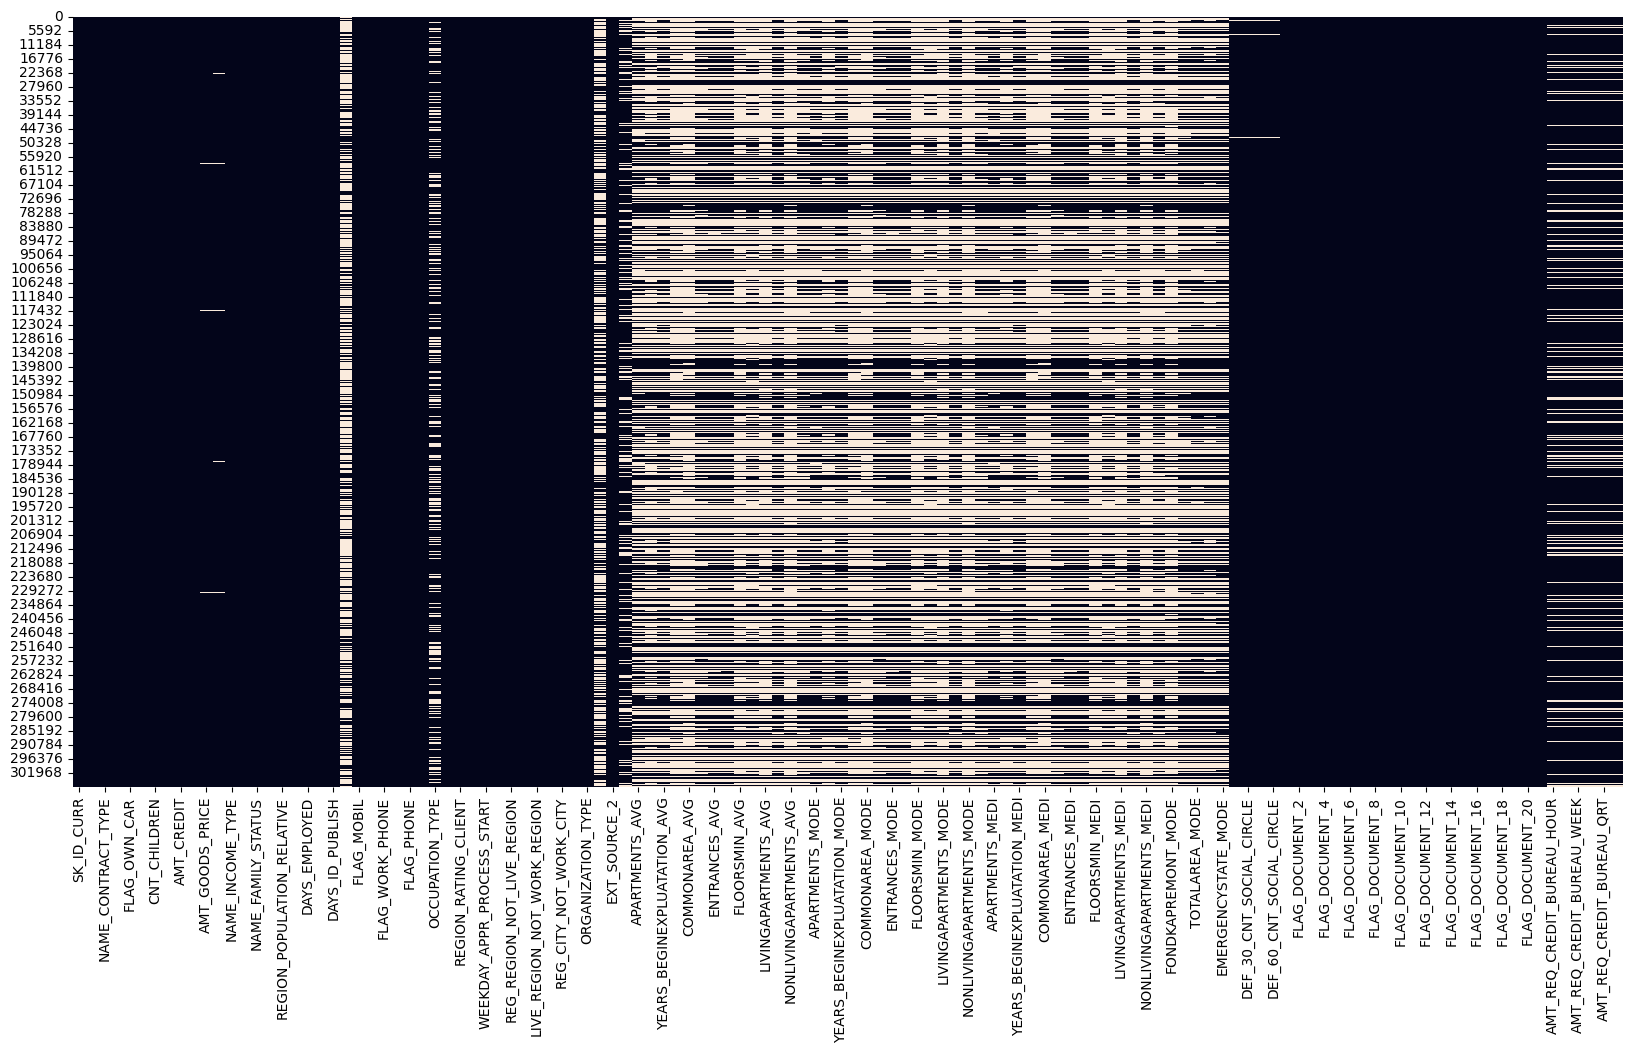

In [20]:
#afficher le pourcentage des valeurs nulls et les visualiser 
valeur_null(application_train, True,True)

In [21]:
# description des variables qualitatives/quantitatives
desc_var(application_train, type_var='all')

SK_ID_CURR    TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type          float64   float64             object      object       object   
nb_nan            0.0       0.0                0.0         0.0          0.0   
%_nan             0.0       0.0                0.0         0.0          0.0   
count        307511.0  307511.0             307511      307511       307511   
unique            NaN       NaN                  2           3            2   
top               NaN       NaN         Cash loans           F            N   
freq              NaN       NaN             278232      202448       202924   
mean    278180.518577  0.080729                NaN         NaN          NaN   
std     102790.175348  0.272419                NaN         NaN          NaN   
min          100002.0       0.0                NaN         NaN          NaN   
25%          189145.5       0.0                NaN         NaN          NaN   
50%          278202.0       0.0                NaN         NaN          NaN   
75%          367142.5       0.0                NaN         NaN          NaN   
max          456255.0       1.0                NaN         NaN          NaN   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL     AMT_CREDIT  \
type            object      float64          float64        float64   
nb_nan             0.0          0.0              0.0            0.0   
%_nan              0.0          0.0              0.0            0.0   
count           307511     307511.0         307511.0       307511.0   
unique               2          NaN              NaN            NaN   
top                  Y          NaN              NaN            NaN   
freq            213312          NaN              NaN            NaN   
mean               NaN     0.417052    168797.919297  599025.999706   
std                NaN     0.722121    237123.146279  402490.776996   
min                NaN          0.0          25650.0        45000.0   
25%                NaN          0.0         112500.0       270000.0   
50%                NaN          0.0         147150.0       513531.0   
75%                NaN          1.0         202500.0       808650.0   
max                NaN         19.0      117000000.0      4050000.0   

         AMT_ANNUITY  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
type         float64  ...          float64          float64          float64   
nb_nan          12.0  ...              0.0              0.0              0.0   
%_nan       0.003902  ...              0.0              0.0              0.0   
count       307499.0  ...         307511.0         307511.0         307511.0   
unique           NaN  ...              NaN              NaN              NaN   
top              NaN  ...              NaN              NaN              NaN   
freq             NaN  ...              NaN              NaN              NaN   
mean    27108.573909  ...          0.00813         0.000595         0.000507   
std     14493.737315  ...         0.089798         0.024387         0.022518   
min           1615.5  ...              0.0              0.0              0.0   
25%          16524.0  ...              0.0              0.0              0.0   
50%          24903.0  ...              0.0              0.0              0.0   
75%          34596.0  ...              0.0              0.0              0.0   
max         258025.5  ...              1.0              1.0              1.0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
type            float64                    float64                   float64   
nb_nan              0.0                    41519.0                   41519.0   
%_nan               0.0                  13.501631                 13.501631   
count          307511.0                   265992.0                  265992.0   
unique              NaN                        NaN                       NaN   
top                 NaN                        NaN                       NaN  

### application_test


Le jeu de données de test contient les mêmes variables que le jeu de données d'entraînement excepté la variable cible.



In [23]:
#la structure des dataframes
data_structure(application_test)

Caractéristiques  Valeurs
0                   Nombre de lignes    48744
1                 Nombre de colonnes      121
2  Nombre de variables catégorielles       16
3    Nombre de variables numériques       105
4  Pourcentage de données manquantes     2881
5                 Nombre de doublons        0

In [24]:
# description des variables qualitatives/quantitatives
desc_var(application_test, type_var='all')

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type          float64             object      object       object   
nb_nan            0.0                0.0         0.0          0.0   
%_nan             0.0                0.0         0.0          0.0   
count         48744.0              48744       48744        48744   
unique            NaN                  2           2            2   
top               NaN         Cash loans           F            N   
freq              NaN              48305       32678        32311   
mean     277796.67635                NaN         NaN          NaN   
std     103169.547296                NaN         NaN          NaN   
min          100001.0                NaN         NaN          NaN   
25%         188557.75                NaN         NaN          NaN   
50%          277549.0                NaN         NaN          NaN   
75%          367555.5                NaN         NaN          NaN   
max          456250.0                NaN         NaN          NaN   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL     AMT_CREDIT  \
type            object      float64          float64        float64   
nb_nan             0.0          0.0              0.0            0.0   
%_nan              0.0          0.0              0.0            0.0   
count            48744      48744.0          48744.0        48744.0   
unique               2          NaN              NaN            NaN   
top                  Y          NaN              NaN            NaN   
freq             33658          NaN              NaN            NaN   
mean               NaN     0.397054    178431.805855  516740.435561   
std                NaN     0.709047    101522.591536  365397.004174   
min                NaN          0.0          26941.5        45000.0   
25%                NaN          0.0         112500.0       260640.0   
50%                NaN          0.0         157500.0       450000.0   
75%                NaN          1.0         225000.0       675000.0   
max                NaN         20.0        4410000.0      2245500.0   

         AMT_ANNUITY AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
type         float64         float64  ...          float64          float64   
nb_nan          24.0             0.0  ...              0.0              0.0   
%_nan       0.049237             0.0  ...              0.0              0.0   
count        48720.0         48744.0  ...          48744.0          48744.0   
unique           NaN             NaN  ...              NaN              NaN   
top              NaN             NaN  ...              NaN              NaN   
freq             NaN             NaN  ...              NaN              NaN   
mean    29426.240209   462618.840473  ...         0.001559              0.0   
std     16016.368315    336710.21504  ...         0.039456              0.0   
min           2295.0         45000.0  ...              0.0              0.0   
25%          17973.0        225000.0  ...              0.0              0.0   
50%          26199.0        396000.0  ...              0.0              0.0   
75%          37390.5        630000.0  ...              0.0              0.0   
max         180576.0       2245500.0  ...              1.0              0.0   

       FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
type            float64          float64                    float64   
nb_nan              0.0              0.0                     6049.0   
%_nan               0.0              0.0                  12.409732   
count           48744.0          48744.0                    42695.0   
unique              NaN              NaN                        NaN   
top                 NaN              NaN                        NaN   
freq                NaN              NaN                        NaN   
mean                0.0              0.0                   0.002108   
std                 0.0              0.0                   0.046373   
min          

### Observations et conclusions :
#### - application_train.csv:
 - On remarque qu'il y a 67 colonnes sur 122 caractéristiques qui contiennent des valeurs NaN, pour un si grand nombre de colonnes, nous ne pouvons pas les supprimer telles quelles, car la perte d'informations pourrait être très importante.
- Nous voyons que certaines colonnes comme celles relatives à "COMMONAREA", "NONLIVINGAPARTMENT", etc. ont près de 70% de valeurs manquantes. Nous devrions trouver des techniques pour traiter ces nombreuses valeurs manquantes et voir ce qui fonctionnerait le mieux pour nos données.
- Il faut également noter que la plupart des colonnes qui comportent plus de 50% de valeurs manquantes sont liées aux statistiques sur les appartements de l'emprunteur. Il est très probable que ces valeurs n'aient pas été enregistrées lors de la saisie des données, et pourraient être facultatives.

#### - application_test.csv:
- Il y a un nombre de colonnes avec des valeurs NaN (64) très similaire à celui de l'application_train.
- Les pourcentages de valeurs NaN sont également assez similaires à ceux présents dans l'ensemble des données de formation. Cela signifie que les ensembles de données d'entraînement et de test ont une distribution assez similaire.

#### - Distribution of Target Variable

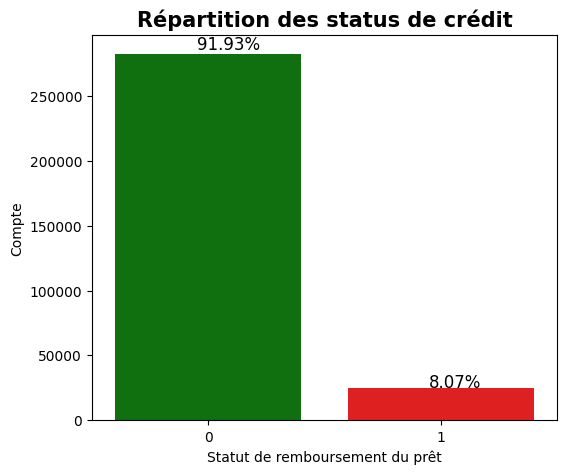

In [31]:
Imbalance = application_train["TARGET"].value_counts().reset_index()

plt.figure(figsize=(6,5))
x= ['Remboursé','Défaillant']
ax = sns.barplot(x="index", y="TARGET", data=Imbalance, palette=['g', 'r'])

#ax = sns.barplot(x,"TARGET",data = Imbalance ,palette= ['g','r'])

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(application_train.TARGET))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height() * 1.01
    ax.annotate(percentage, (x, y), fontsize=12)

plt.xlabel("Statut de remboursement du prêt")
plt.ylabel("Compte")
plt.title("Répartition des status de crédit",fontsize=15, fontweight='bold')
plt.show()

- **Observations et conclusions :**


- De la distribution de la variable Target, une chose que nous pouvons rapidement remarquer est le déséquilibre des données. Seuls 8,07 % du total des prêts ont été effectivement défaillants. Cela signifie que les défaillants constituent la classe minoritaire. 


- Les défaillants se sont vu attribuer une variable cible de 1 et les non défaillants se sont vu attribuer la variable cible 0.


- Pour les ensembles de données déséquilibrées, lors de la construction du modèle, nous ne pouvons pas alimenter les données telles quelles pour certains algorithmes, qui sont sensibles au déséquilibre.


- C'est le cas des mesures de performance. Pour un tel ensemble de données, l'exactitude n'est généralement pas la bonne mesure car l'exactitude serait généralement biaisée en faveur de la classe majoritaire. Nous pouvons utiliser d'autres mesures telles que le score **ROC-AUC**, la perte logarithmique, **le score F1**, **la matrice de confusion** pour une meilleure évaluation du modèle.


### Matrice de corrélation

#### caractéristiques catégorielle

- Nous tracerons une carte thermique des valeurs du coefficient de corrélation **Phi-K** entre chacune des caractéristiques et l'autre. 

      - Le coefficient Phi-K est similaire au coefficient de corrélation sauf qu'il peut être utilisé avec une paire de caractéristiques catégorielles. Sa valeur maximale peut être 1, ce qui indique une association maximale entre deux variables catégorielles.

-------------------------------------------------------------------------------


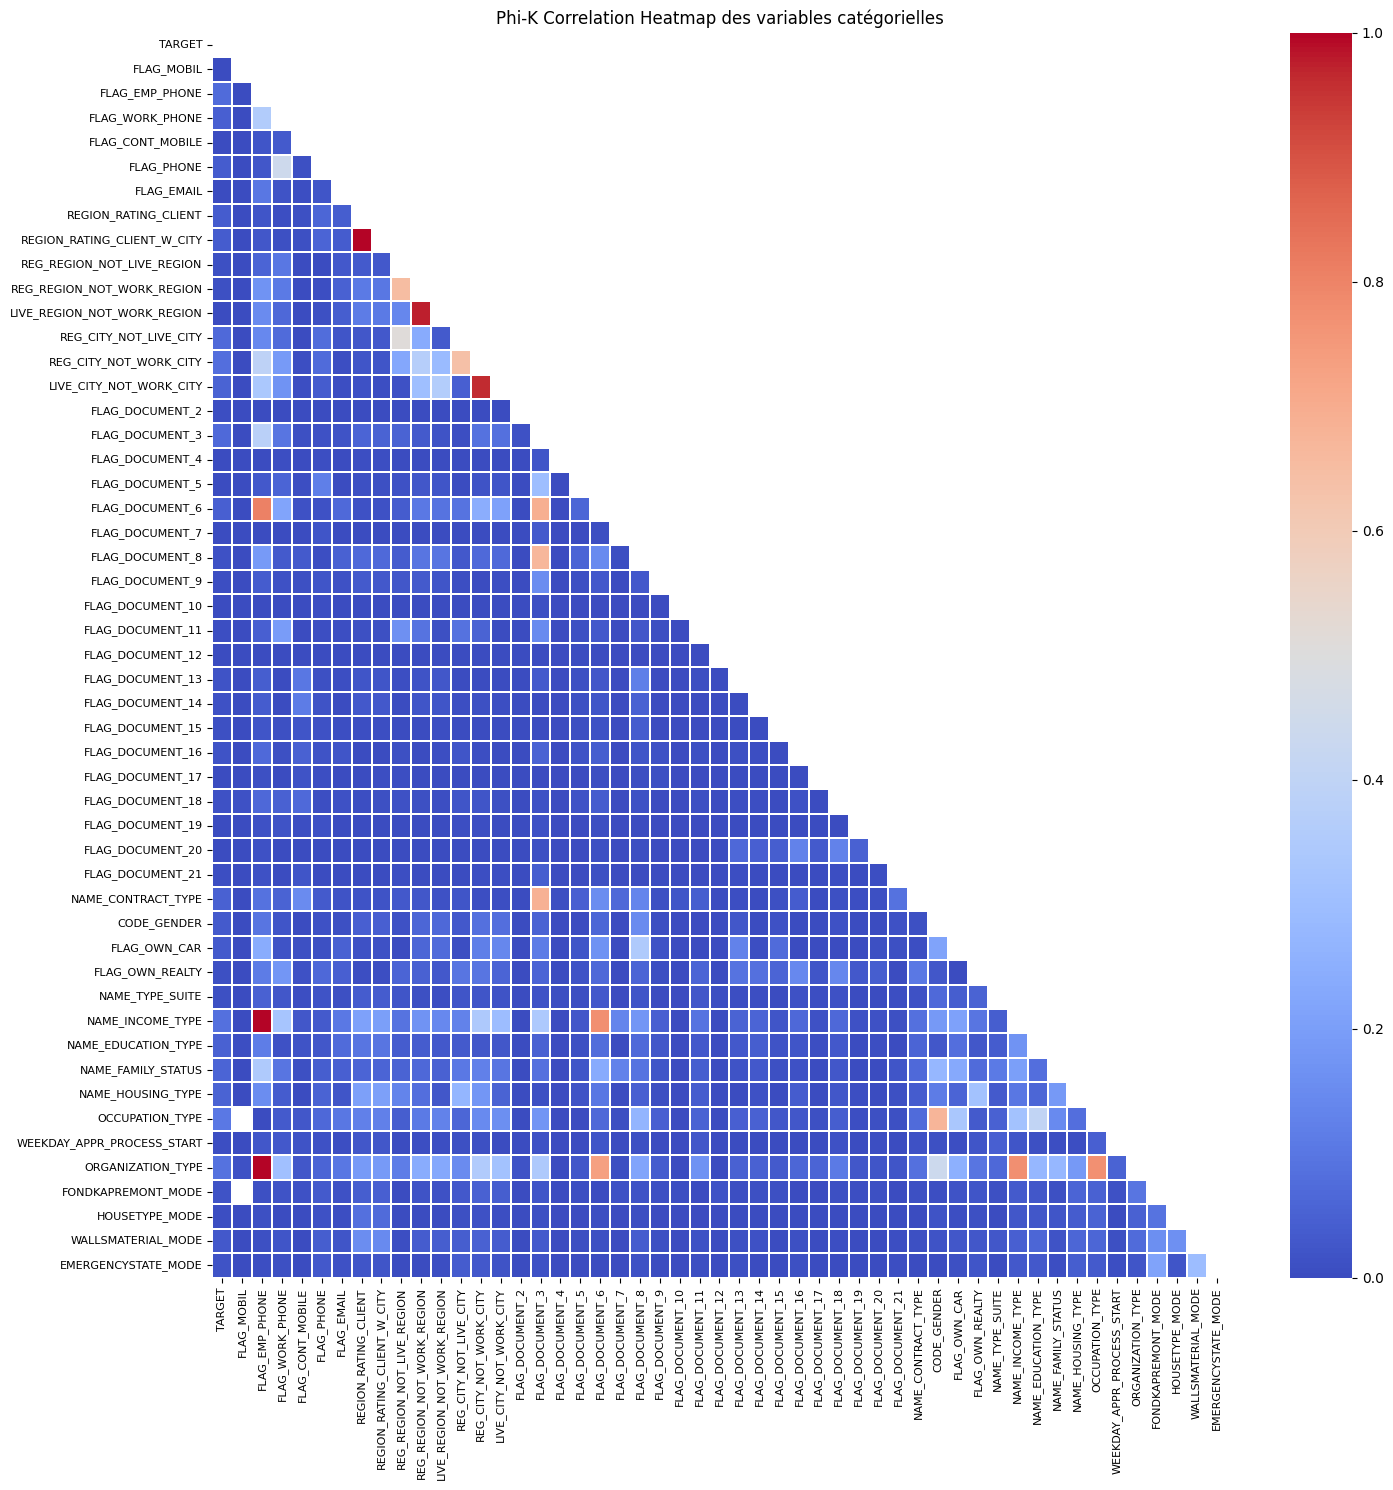

-------------------------------------------------------------------------------
Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :


-------------------------------------------------------------------------------


In [32]:
# Matrice de corrélation
categorical_columns = ['TARGET', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                       'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                       'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2, 22)] + application_train.dtypes[
    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns,
                 figsize=(15, 15), fontsize=8, cmap='coolwarm')

- **Observations et conclusions :**

- D'après la carte thermique de la corrélation Phi-K ci-dessus, nous constatons que la plupart des caractéristiques catégorielles ne sont pas corrélées entre elles, mais que certaines d'entre elles présentent une forte corrélation tel que :


       - REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT
       - LIVE_REGION_NOT_WORK_REGION and REG_REGION_NOT_WORK_REGION
       - NAME_INCOME_TYPE, ORGANIZATION_TYPE and FLAG_EMP_PHONE
       
- Nous pouvons également constater une certaine corrélation entre le type d'organisation et le type de revenu d'un client. De même, nous constatons une corrélation entre le type de profession et le type d'organisation.
- Nous constatons que la catégorie OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY sont parmi les catégories les plus fortement corrélées avec la variable TARGET. Elles sont peut-être importantes pour la tâche de classification, et nécessiteraient d'autres EDA

#### caractéristiques  numérique

- Nous avons exclu la colonne **SK_ID_CURR**, car elle n'a aucune pertinence. Cette carte thermique nous aidera à identifier les caractéristiques numériques fortement corrélées et nous aidera également à identifier les variables qui sont fortement corrélées avec la variable cible.

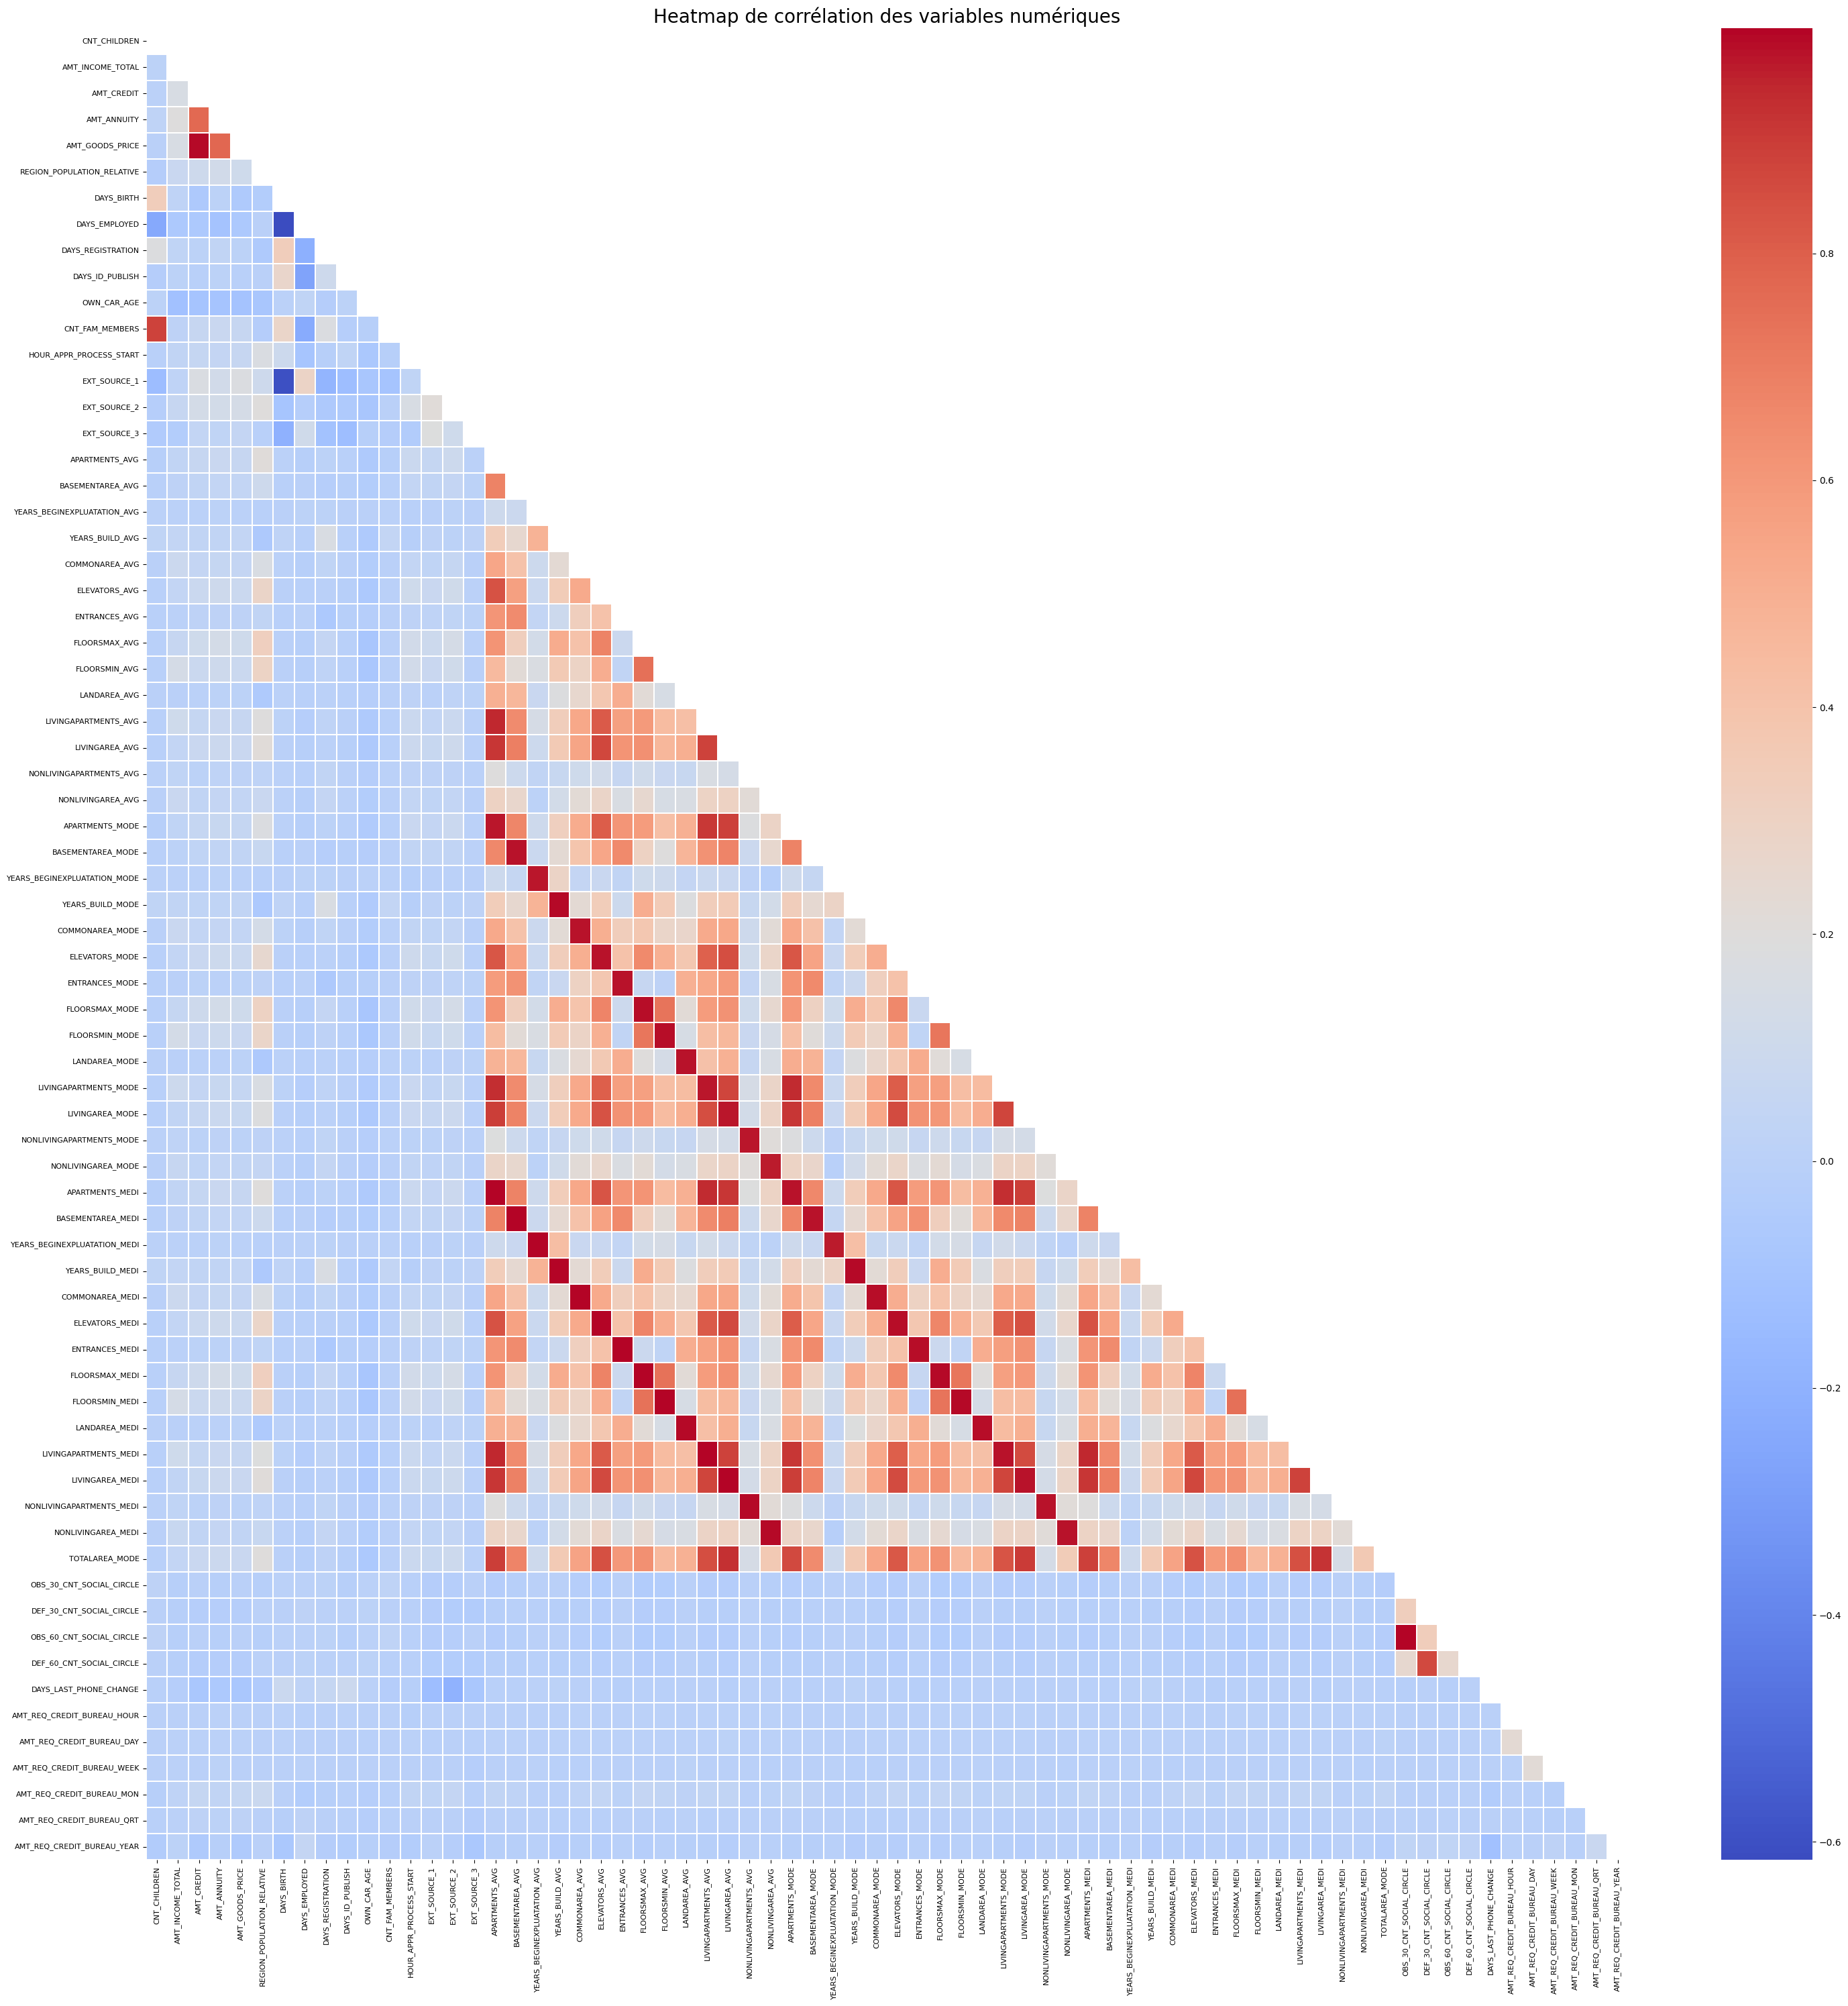

In [33]:
columns_to_drop = ['SK_ID_CURR'] + \
    list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize=(
    30, 30), fontsize=8, cmap='coolwarm')
corr_mat.plot_correlation_matrix()

In [ ]:
# Voir les colonnes supérieures avec la plus haute corrélation phik avec
# la variable cible dans la table application_train
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 79)
titre1 = 'Les variables ayant les valeurs les plus élevées de Phik'
print(titre1 + '-corrélation avec la variable cible sont les suivantes :')
display(top_corr_target_df.style.hide_index())
print("-"*79)

- **Observations et conclusions :**


- On peut observer que la plupart des cartes thermiques contiennent une couleur blue, ce qui indique une très faible valeur de corrélation. Cela implique que la plupart des caractéristiques ne sont en effet pas corrélées avec d'autres.

- Si nous examinons les caractéristiques d'application_train, nous pouvons clairement voir que les statistiques des appartements sont données en termes de Moyenne, Médiane et Mode, on peut donc s'attendre à ce que la moyenne, la médiane et le mode soient corrélés entre eux. Une autre chose à noter est que les caractéristiques d'une catégorie particulière, par exemple la moyenne, sont également corrélées avec d'autres caractéristiques de la moyenne, telles que le nombre d'ascenseurs, la surface habitable, la surface non habitable, la surface du sous-sol, etc.
- Nous constatons également une forte corrélation entre **AMT_GOODS_PRICE et AMT_CREDIT**, entre **DAYS_EMPLOYED et DAYS_BIRTH**.
- Nous ne voulons pas de caractéristiques fortement corrélées car elles augmentent la complexité temporelle du modèle sans lui apporter beaucoup de valeur ajoutée. Par conséquent, nous supprimerions les caractéristiques inter-corrélées.
- Parmi toutes les caractéristiques, nous constatons une corrélation élevée pour les caractéristiques **EXT_SOURCE** par rapport à la variable cible. Ces caractéristiques pourraient être importantes pour notre tâche de classification.

Text(0.5, 1.0, 'Matrice de corrélation de top 10 variables corrélées  ')

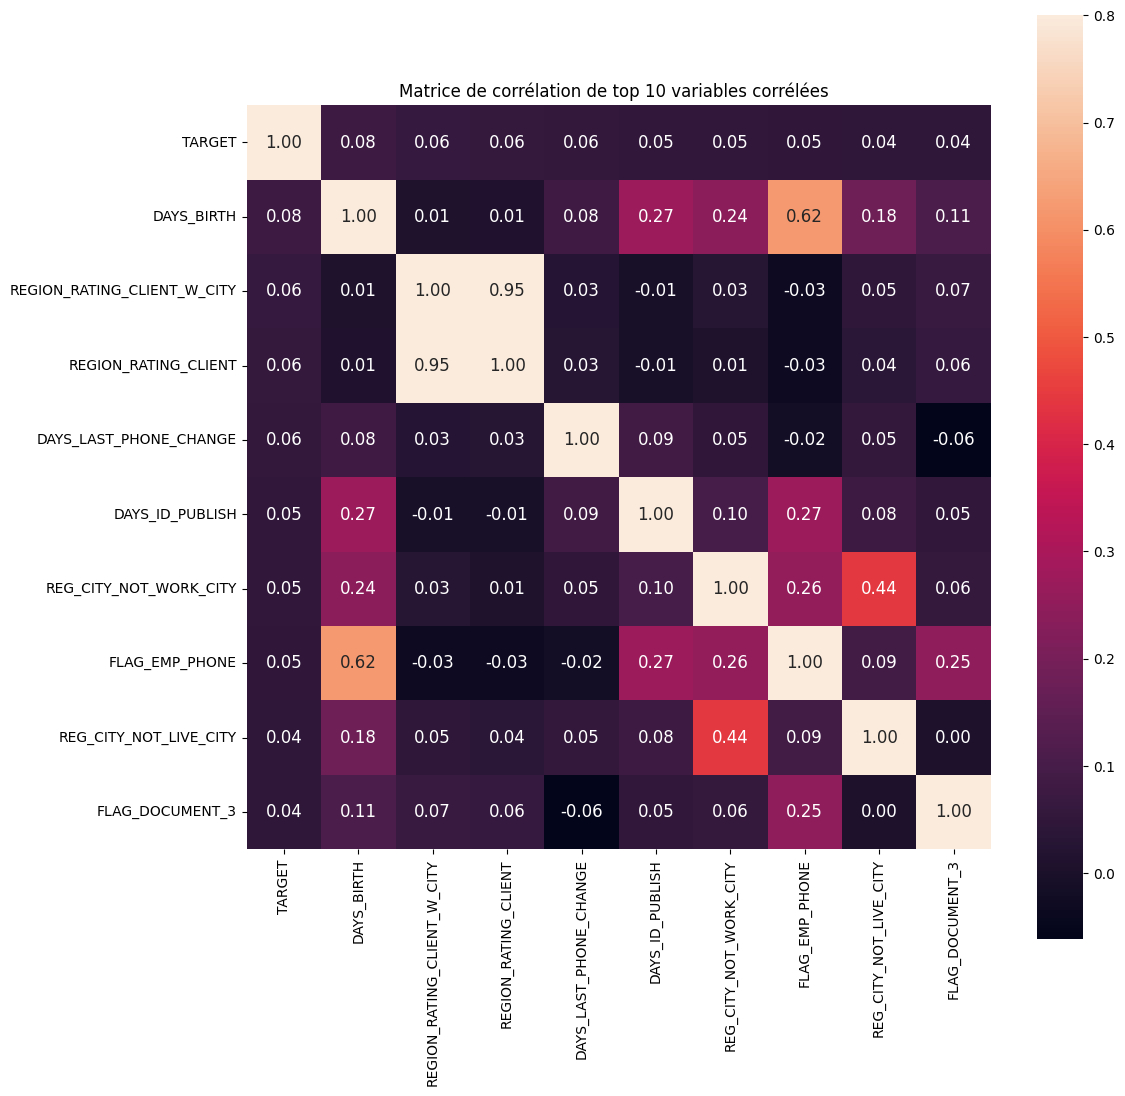

In [34]:
# top 10 variables corélées (" des corrélations linéaires "")

corrmat = application_train.corr()
top10_cols = corrmat.nlargest(10, 'TARGET')['TARGET'].index
corrmat_top10 = application_train[top10_cols].corr()
fig1, ax1 = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat_top10, vmax=.8, square=True, ax=ax1,
            annot=True, fmt='.2f', annot_kws={'size': 12})
plt.title('Matrice de corrélation de top 10 variables corrélées  ')

### Analyse de varibale catégorielle 

#### Distribution de la variable catégorielle NAME_CONTRACT_TYPE



- Cette variable contient des informations sur le type de prêt pour le demandeur donné :


      - prêt cash,
      - prêt revolving.
      
- Selon la documentation fournie par Home Credit, il existe deux types de prêts, à savoir les prêts renouvelables et les prêts en espèces.

In [35]:
# let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

# plotting the Pie Plot for the column
plot_categorical_variables_pie(
    application_train, 'NAME_CONTRACT_TYPE', hole=0.5)
print('-'*100)

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_TYPE' sont :
['Cash loans' 'Revolving loans']
-------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


- **Observations et conclusions :**

- A partir du premier subplot, c'est-à-dire la distribution globale : On peut voir que la plupart des prêts que les clients prennent sont des prêts cash.


####  Distribution de la variable catégorielle NAME_INCOME_TYPE



Cette colonne contient des informations sur le type de revenu des clients (homme d'affaires, travail, congé de maternité...)

In [36]:
# let us first see the unique categories of 'NAME_INCOME_TYPE'
print_unique_categories(application_train, 'NAME_INCOME_TYPE')

# plotting the Pie Plot for the column
plot_categorical_variables_pie(application_train, 'NAME_INCOME_TYPE', hole=0.5)
print('-'*100)

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_INCOME_TYPE' sont :
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
-------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


- **Observations et conclusions :**

- Le premier graphique général montre que :


     - la majorité des demandeurs sont des travailleurs (52%),
     - 23% de commerciaux, 18% de retraités et 7 % des vendeurs.
     - très peu de type de revenus passifs : non salariés, étudiants, hommes d'affaires et en congés de maternité : autour de 0%.
     
     
- Concernant les défaillants, les pourcentages du graphique général ne sont pas respectés :



     - la majorité des demandeurs ayant le taux de défaillance le plus élevé sont les catégories les plus rares du graphique général : les congés de maternité et les non salariés (près de 40%),
    -  seulement 10% de la classe majoritaire des travailleurs et 5% de la classe des commerciaux.
    - Seulement 5% des 7% des retraités ne remboursent pas leurs dettes.
    

- Le type de revenu du demandeur pourra donc avoir une influence sur la défaillance du demandeur.

####  Distribution de la variable catégorielle CODE_GENDER



Cette colonne contient des informations sur le sexe du client/demandeur. Ici, M signifie Masculin et F signifie Féminin.

In [37]:
# let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(application_train, 'CODE_GENDER', show_counts=True)

# plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole=0.5)
print('-'*100)

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CODE_GENDER' sont :
['M' 'F' 'XNA']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
-------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


- **Observations et conclusions :**

La distribution de la fonction CODE_GENDER semble intéressante. Voici quelques points de discussion :


- Le premier point à observer est qu'il y a 4 lignes dans la table application_train qui ont des genres "XNA", ce qui n'a pas beaucoup de sens, et peut être compté comme des valeurs NaN. Puisqu'elles ne sont que 4 en nombre et n'appartiennent qu'à la catégorie des non défaillants. Nous pouvons donc éliminer ces lignes sans trop d'hésitation.
- Dans le subplot 1, nous constatons que pour l'ensemble de données donné, il y a plus de candidats féminins (65,8 %) que de candidats masculins (34,2 %).
- Cependant, contrairement au nombre de candidates, nous constatons, à partir du deuxième subplot, que les candidats masculins ont tendance à être plus défaillants (10,14%) que les candidates féminines (7%).



- Ainsi, on peut dire que les hommes ont plus tendance à ne pas payer leurs dettes que les femmes selon l'ensemble de données donné.

####  Distribution de la variable catégorielle FLAG_EMP_PHONE



Cette colonne est une colonne booléenne, qui indique si le client a fourni ou non son numéro de téléphone au travail.
Ici, 1 signifie Oui et 0 signifie Non.

In [38]:
# let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

# plotting the Pie Plot for the Column
plot_categorical_variables_pie(
    application_train, column_name='FLAG_EMP_PHONE', hole=0.5)
print('-'*100)

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'FLAG_EMP_PHONE' sont :
[1 0]
-------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


- **Observations et conclusions :**


- Cette fonction contient deux catégories, à savoir si le client a fourni son numéro de téléphone au travail pendant la procédure d'enregistrement/de demande ou non.



- D'après le premier subplot, nous constatons que la plupart des demandeurs ne fournissent pas leur numéro de téléphone professionnel (82 %) et que seulement 18 % ont fourni leur numéro de téléphone professionnel. On peut également constater que la tendance par défaut pour ceux qui fournissent leur numéro de téléphone au travail est plus élevée que pour ceux qui ne le fournissent pas. Cette caractéristique pourrait être attribuée au fait que les défaillants pourraient fournir leurs numéros de téléphone professionnels afin de ne pas être dérangés sur leur téléphone personnel.

####   Distribution de la variable catégorielle REGION_RATING_CLIENT_W_CITY



Cette caractéristique est la notation fournie par le Crédit immobilier à la région de chaque client sur la base des enquêtes qu'ils ont pu effectuer. Cette notation tient également compte de la ville dans laquelle le client vit.
La prise en compte de la ville est importante car même si certaines régions ont une bonne note dans une ville particulière, mais que cette ville n'a pas une note élevée, alors le candidat se verrait attribuer une note moyenne et non une note élevée.
Il contient des valeurs comprises entre 1 et 3.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'REGION_RATING_CLIENT_W_CITY' sont :
[2 1 3]
-------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


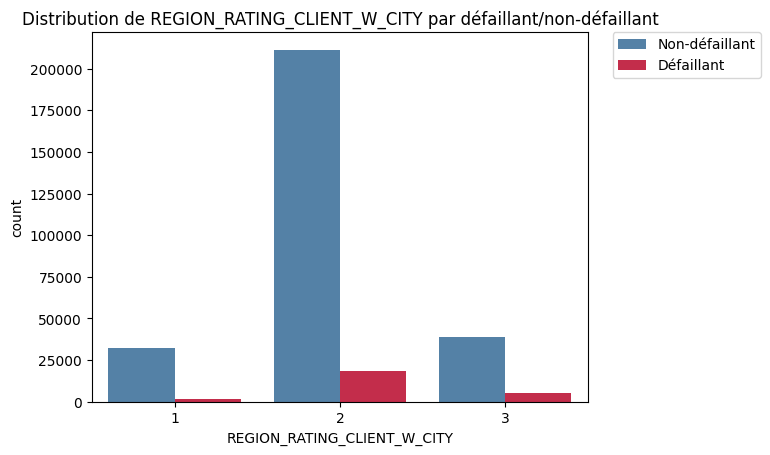

In [39]:
# let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

# plotting the Pie Plot for the Column
plot_categorical_variables_pie(
    application_train, column_name='REGION_RATING_CLIENT_W_CITY')
print('-'*100)
# Distribution par défaillants/non-défaillants
plot_barplot_comp_target(application_train,
                                'REGION_RATING_CLIENT_W_CITY')

- **Observations et conclusions :**

Les tracés ci-dessus nous permettent de tirer les conclusions suivantes :

- Dès le premier subplot, nous voyons que la plupart des clients (74,6 %) ont une note de 2 pour la région, ce qui correspond à la valeur moyenne pour la plupart des demandeurs.
Très peu de demandeurs ont une note de 1 pour la région (seulement 11,1 %) et certains ont une note de 3 (14,3 %).

- Cela montre que la note 3 pourrait être un attribut important pour prendre une décision sur les caractéristiques par défaut.

####   Distribution de la variable catégorielle NAME_HOUSING_TYPE



Cette fonction indique quelle est la situation du client en matière de logement (location, vie avec les parents, ...)

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_HOUSING_TYPE' sont :
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_HOUSING_TYPE = 6


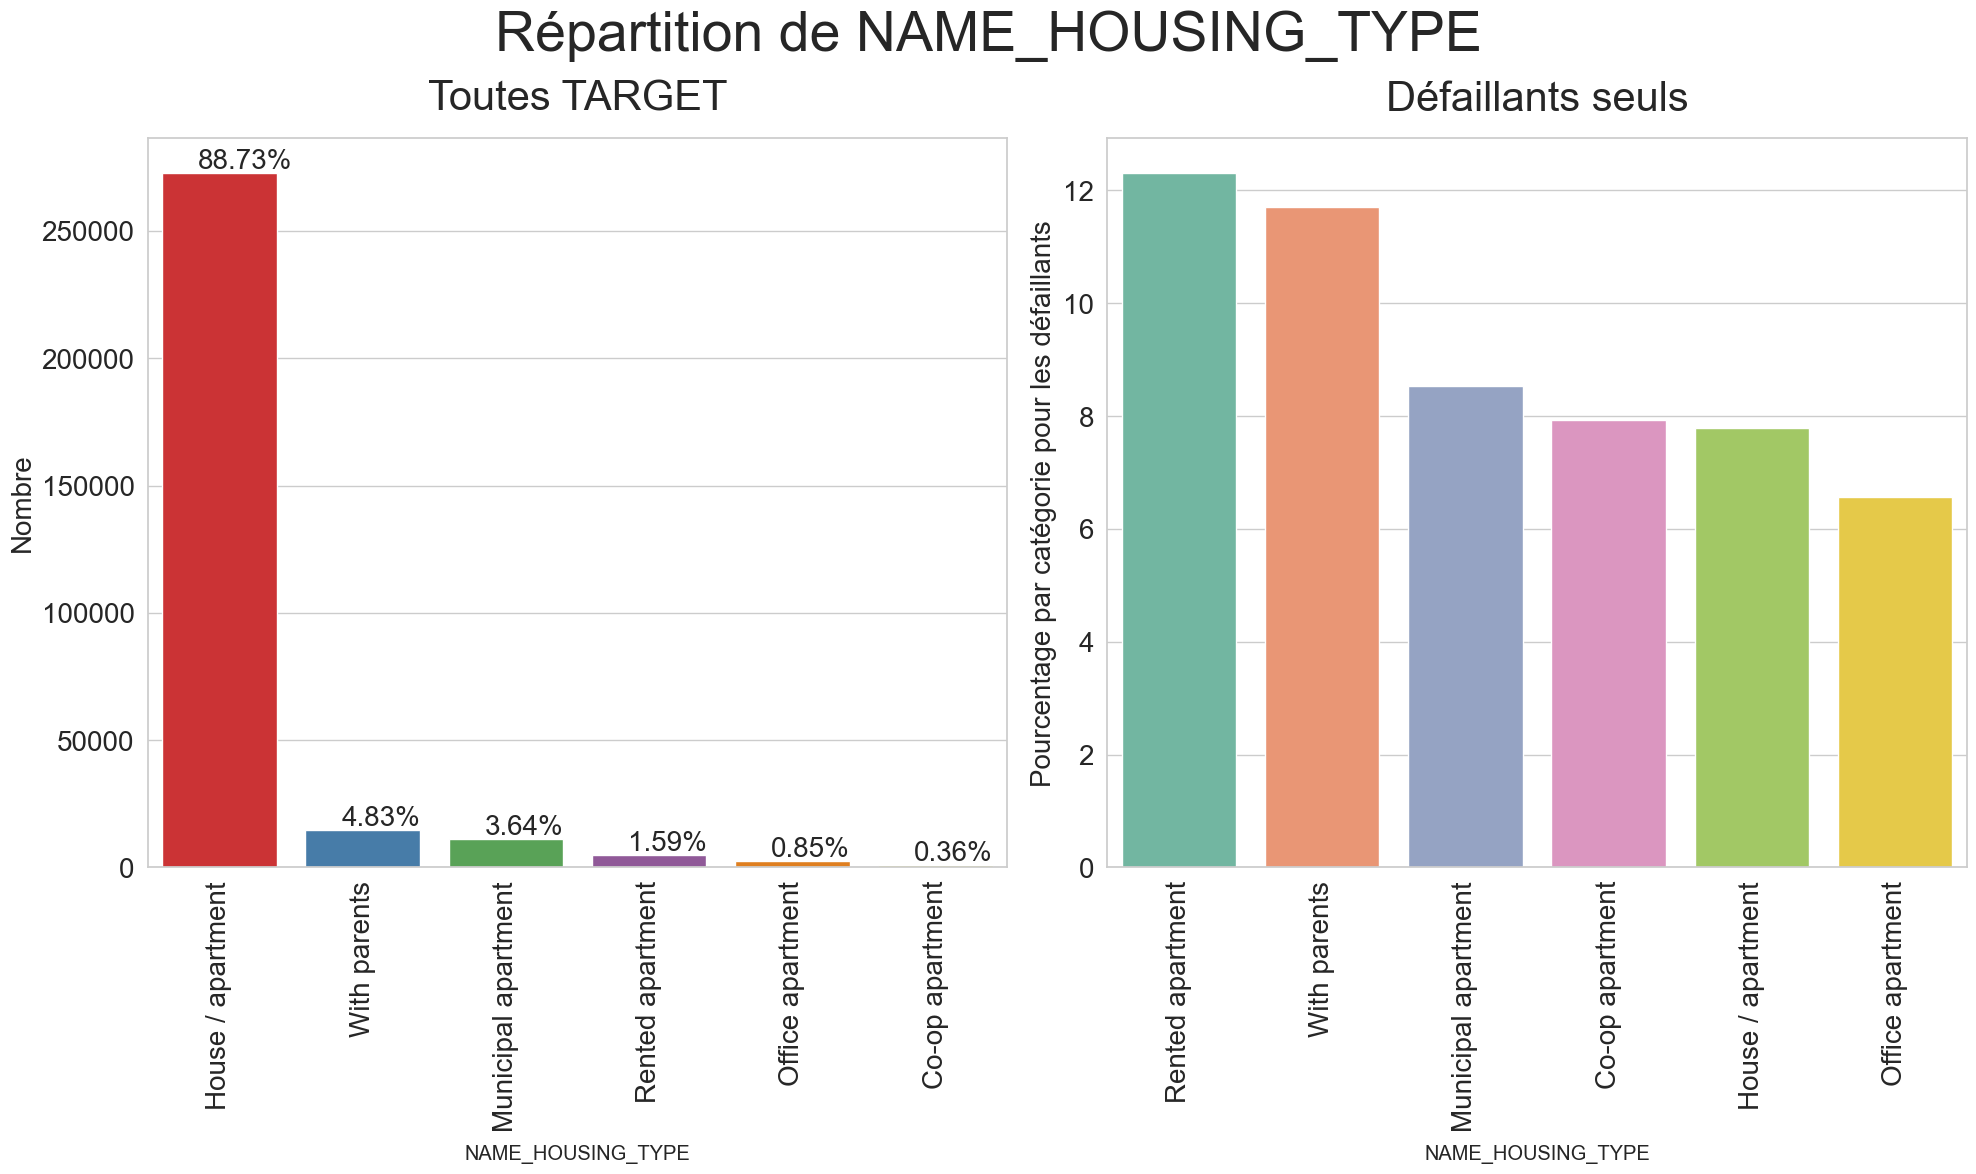

----------------------------------------------------------------------------------------------------


In [40]:
# let us first see the unique categories of 'NAME_HOUSING_TYPE'
print_unique_categories(
    application_train, 'NAME_HOUSING_TYPE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name='NAME_HOUSING_TYPE', figsize=(20, 12),
                                   rotation=90, horizontal_adjust=0.25,
                                   fontsize_percent=20)
print('-'*100)

In [ ]:
# Distribution par défaillants/non-défaillants
plot_barplot_comp_target(application_train,
                                              'NAME_HOUSING_TYPE',
                                              rotation=90)

- **Observations et conclusions :**

- Le premier graphique général montre :



      - que la majorité (89%)des demandeurs sont propriétaires d'une maison ou d'un appartement.
      - que 5% des demandeurs vivent chez leurs parents.
      - et les 5 autres pourcent concernent les appartements de location, municipaux ou les co-locations.
   
- Le second graphique, qui effectue un zoom sur les défaillants, montre que les personnes qui ont le taux de défaillance le plus élevé, font partie des 5% restant du graphique général : la majorité loue un appartement ou habitent chez leurs parents mais ne sont pas propriétaire.




- La situation du logement du demandeur pourra donc avoir une influence sur la défaillance potentielle du demandeur.

####    - Distribution de la variable catégorielle OCCUPATION_TYPE



Cette fonction indique le type d'activité professionnelle du client. Il peut s'agir d'une caractéristique très importante qui pourrait décrire les caractéristiques par défaut d'un client.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'OCCUPATION_TYPE' sont :
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour OCCUPATION_TYPE = 19


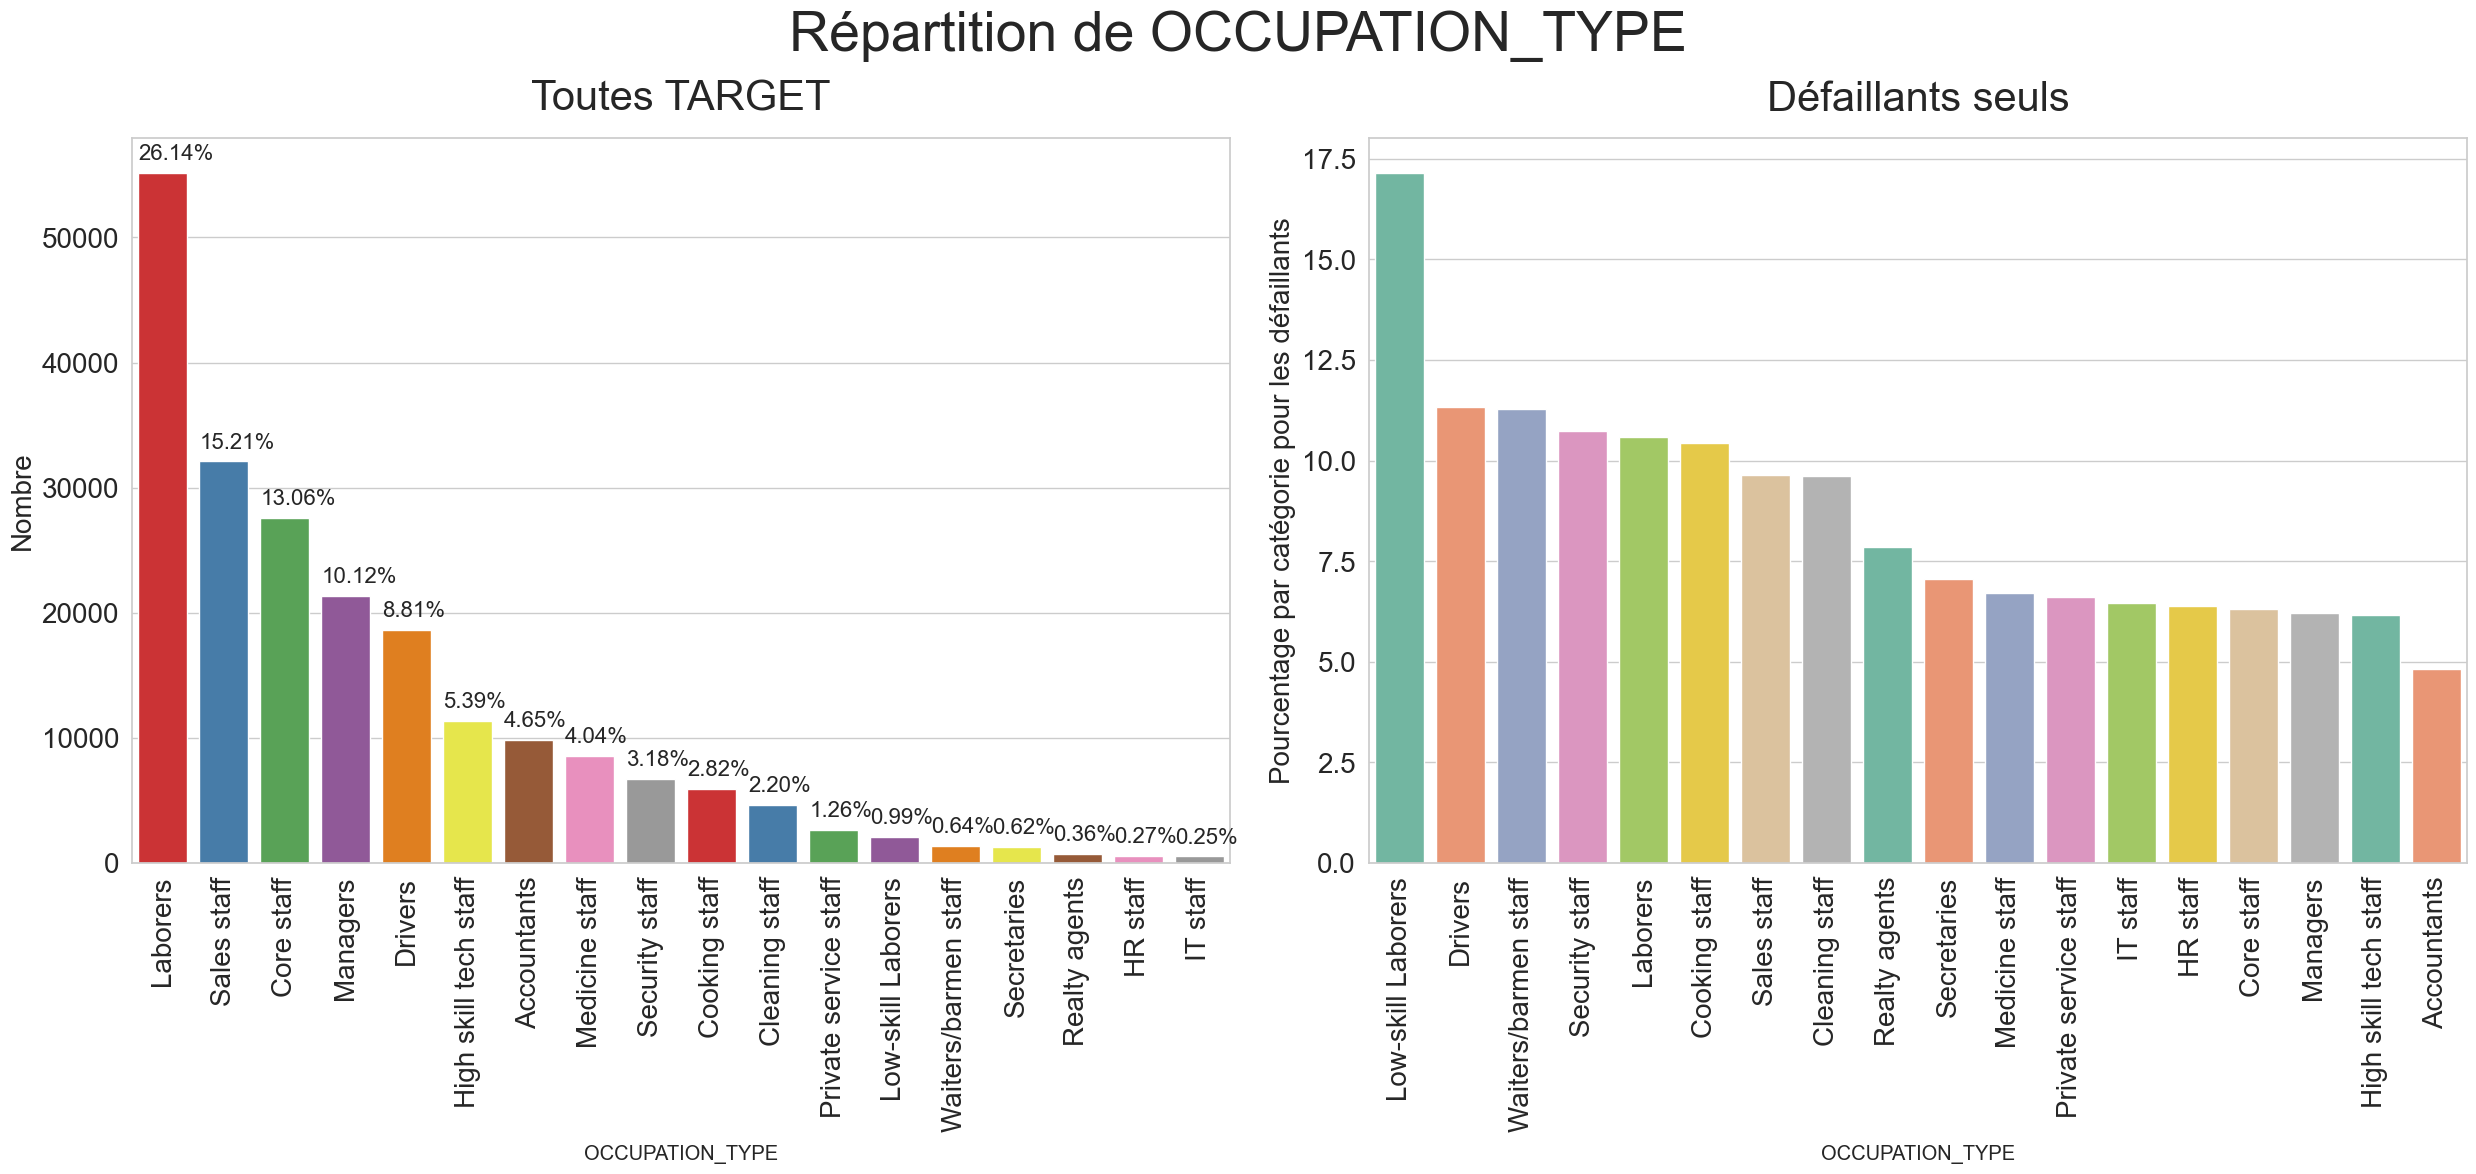

----------------------------------------------------------------------------------------------------


In [41]:
# let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(application_train, 'OCCUPATION_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name='OCCUPATION_TYPE', figsize=(25, 12), rotation=90,
                                   fontsize_percent=16)
print('-'*100)

- **Observations et conclusions :**


A partir des graphiques du secteur d'activité, nous pouvons tirer les observations suivantes :

- parmi les demandeurs, le type d'emploi le plus courant est celui des ouvriers, qui représente près de 26 % des demandes. La deuxième profession la plus fréquente est celle du personnel de vente, suivie du personnel de base et des cadres.

- Le taux de défaillance des travailleurs peu qualifiés est le plus élevé parmi tous les types de professions (~17,5 %). Il est suivi par les chauffeurs, les serveurs, le personnel de sécurité, les ouvriers, le personnel de cuisine, etc. Tous ces emplois sont des emplois de bas niveau. Tous les emplois sont des emplois de bas niveau. Cela montre que les personnes occupant des emplois de bas niveau ont tendance à avoir un taux de défaillance plus élevé.


- Les taux de défaillance les plus faibles concernent les comptables, le personnel de base, les gestionnaires, le personnel technique hautement qualifié, le personnel des ressources humaines, etc. qui occupent des postes de niveau moyen à élevé.
On peut donc conclure que les travailleurs de bas niveau ont une plus grande tendance à la défaillance que les travailleurs de niveau moyen à élevé.

####   - Distribution de la variable catégorielle ORGANIZATION_TYPE




Tout comme le type de profession, le secteur d'activité auquel le client appartient peut également être une caractéristique importante pour prédire le risque de défaillance de ce client.

Nombre de catégorie de la variable ORGANIZATION_TYPE = 58


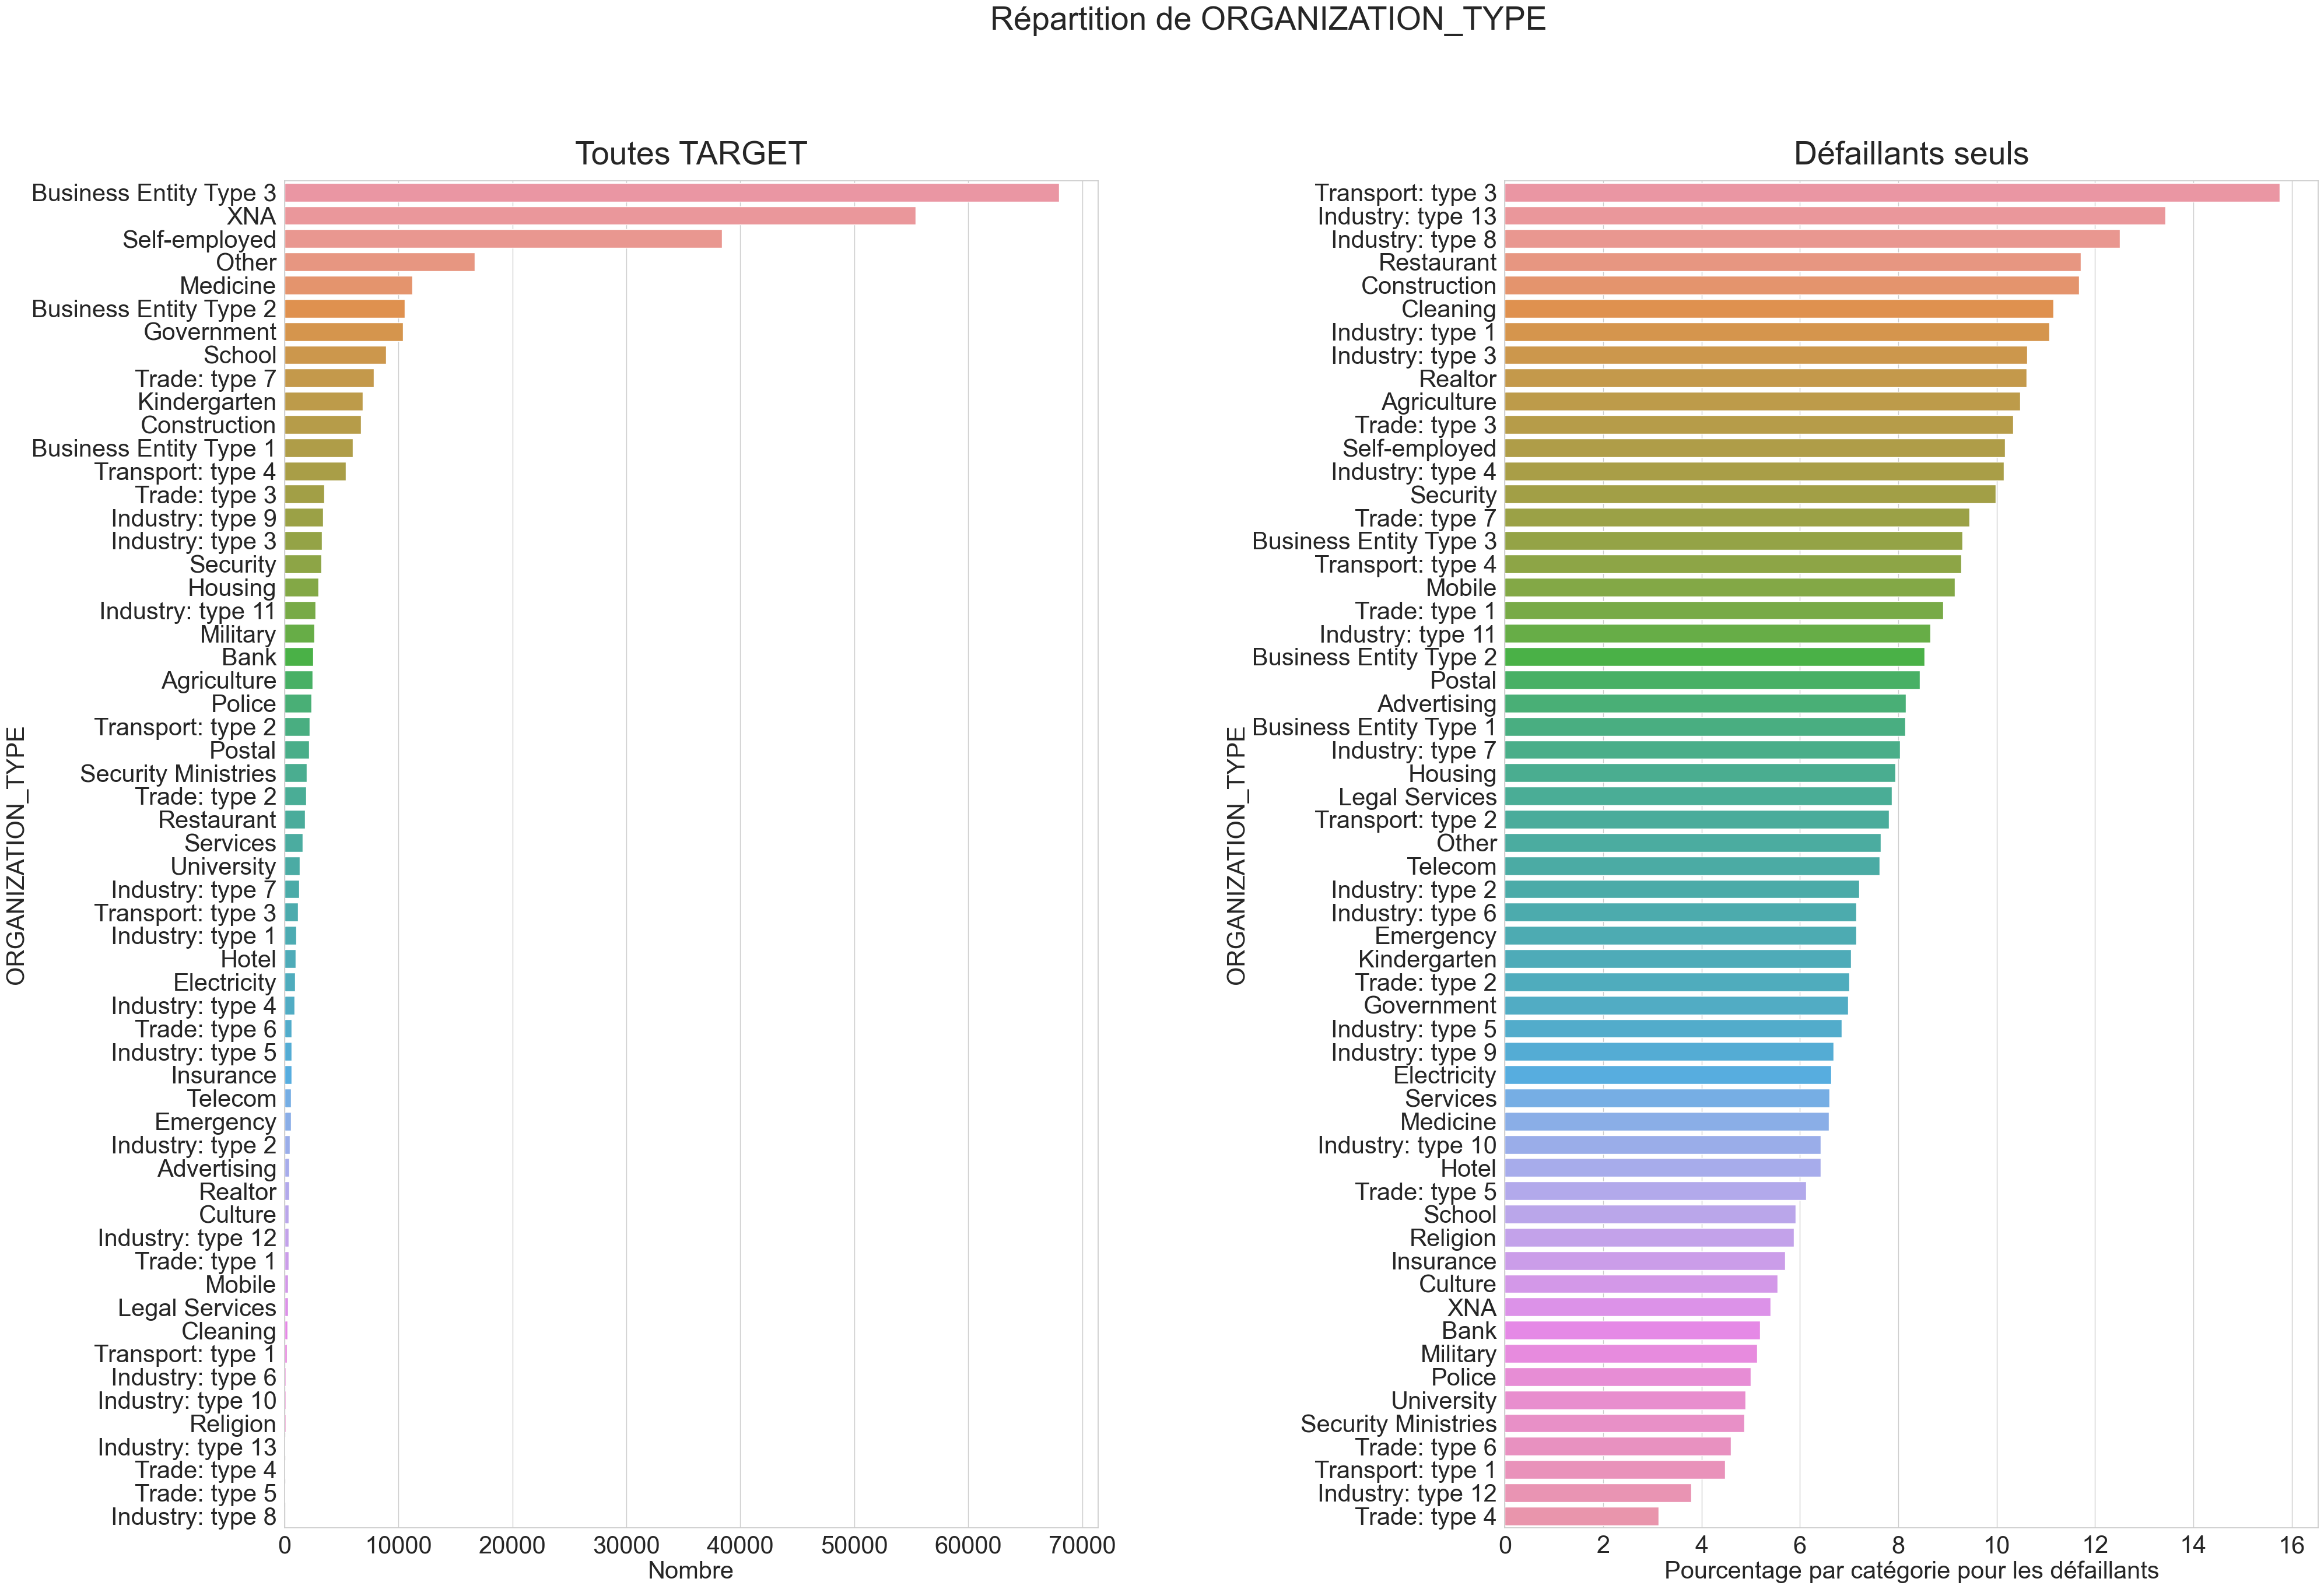

In [42]:
print(f"Nombre de catégorie de la variable ORGANIZATION_TYPE = \
{len(application_train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize=(45, 30))
sns.set(style='whitegrid', font_scale=1.2)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
count_organization = application_train.ORGANIZATION_TYPE.value_counts() \
    .sort_values(ascending=False)
sns.barplot(x=count_organization, y=count_organization.index)
plt.title('Toutes TARGET', pad=20, fontsize=40)
plt.xlabel('Nombre', fontsize=30)
plt.ylabel('ORGANIZATION_TYPE', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.subplot(1, 2, 2)
percentage_default_per_organization = \
    application_train[application_train.TARGET == 1].ORGANIZATION_TYPE. \
    value_counts() * 100 / count_organization
percentage_default_per_organization = \
    percentage_default_per_organization.dropna(). \
    sort_values(ascending=False)
sns.barplot(x=percentage_default_per_organization,
            y=percentage_default_per_organization.index)
plt.title('Défaillants seuls', pad=20, fontsize=40)
plt.xlabel('Pourcentage par catégorie pour les défaillants', fontsize=30)
plt.ylabel('ORGANIZATION_TYPE', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.suptitle(f'Répartition de ORGANIZATION_TYPE', fontsize=40)
plt.show()

- **Observations et conclusions :**


Il existe de nombreux types d'organisations auxquelles le client appartient, 58 pour être précis. Les graphiques ci-dessus donnent les observations suivantes :

- Dès le premier graphique, nous constatons que la plupart des demandeurs travaillent dans des organisations de type "entité commerciale de type 3", "XNA" ou "travailleur indépendant". Le type d'organisation "XNA" pourrait probablement désigner une organisation non classée TYPE.
- À partir du deuxième graphique, nous constatons que les candidats appartenant à "Transport : type 3" ont la plus forte tendance à la défaillance par rapport aux autres. Ils sont suivis par les organisations de type : "Industrie : type 13", "Industrie : type 8", "Restaurant", "Construction", etc.
- Les organisations qui affichent les taux de défaillance les plus faibles sont "Commerce : type 4", "Industrie : type 12", etc.



Ces numéros de type en diraient également plus sur l'Organisation, cependant, nous n'avons aucune information à ce sujet, nous nous en tiendrons donc à la dénomination qui nous a été fournie.

####  -  Distribution de la variable catégorielle REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY







- REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY:
Ces colonnes comprennent des flags indiquant si l'adresse permanente du client correspond ou non à son adresse de contact donnée pour le prêt ou à son adresse professionnelle au niveau de la région

        - 1 pour des adresses différentes,
        - 0 pour des adresses identiques.

- LIVE_CITY_NOT_WORK_CITY Cette colonne indique si l'adresse permanente du client correspond ou non à son adresse de contact donnée pour le prêt au niveau de la ville. Ici, 1 indique des adresses différentes et 0 indique les mêmes adresses.


         - 1 pour des adresses différentes,
         - 0 pour des adresses identiques.

----------------------------------------------------------------------------------------------------
Nombre de catégories uniques pour REG_CITY_NOT_LIVE_CITY = 2


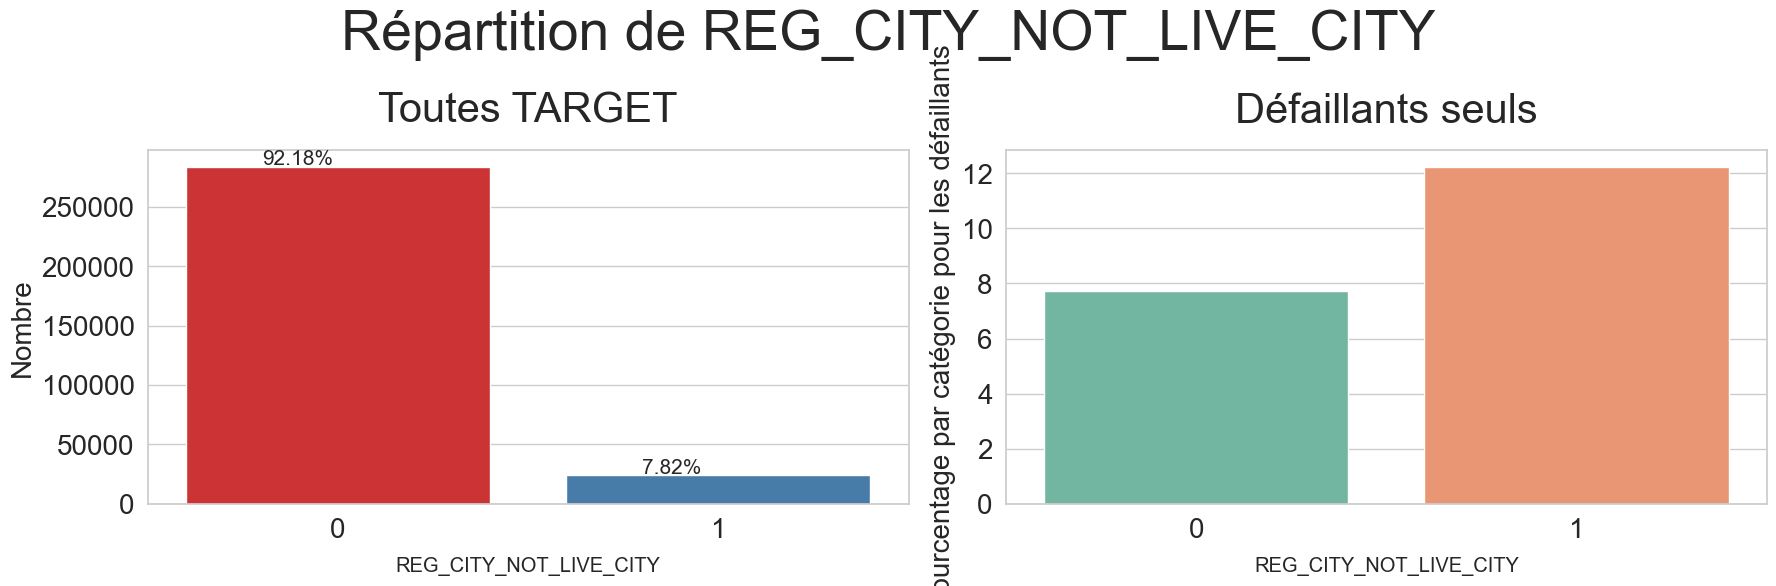

----------------------------------------------------------------------------------------------------
Nombre de catégories uniques pour REG_CITY_NOT_WORK_CITY = 2


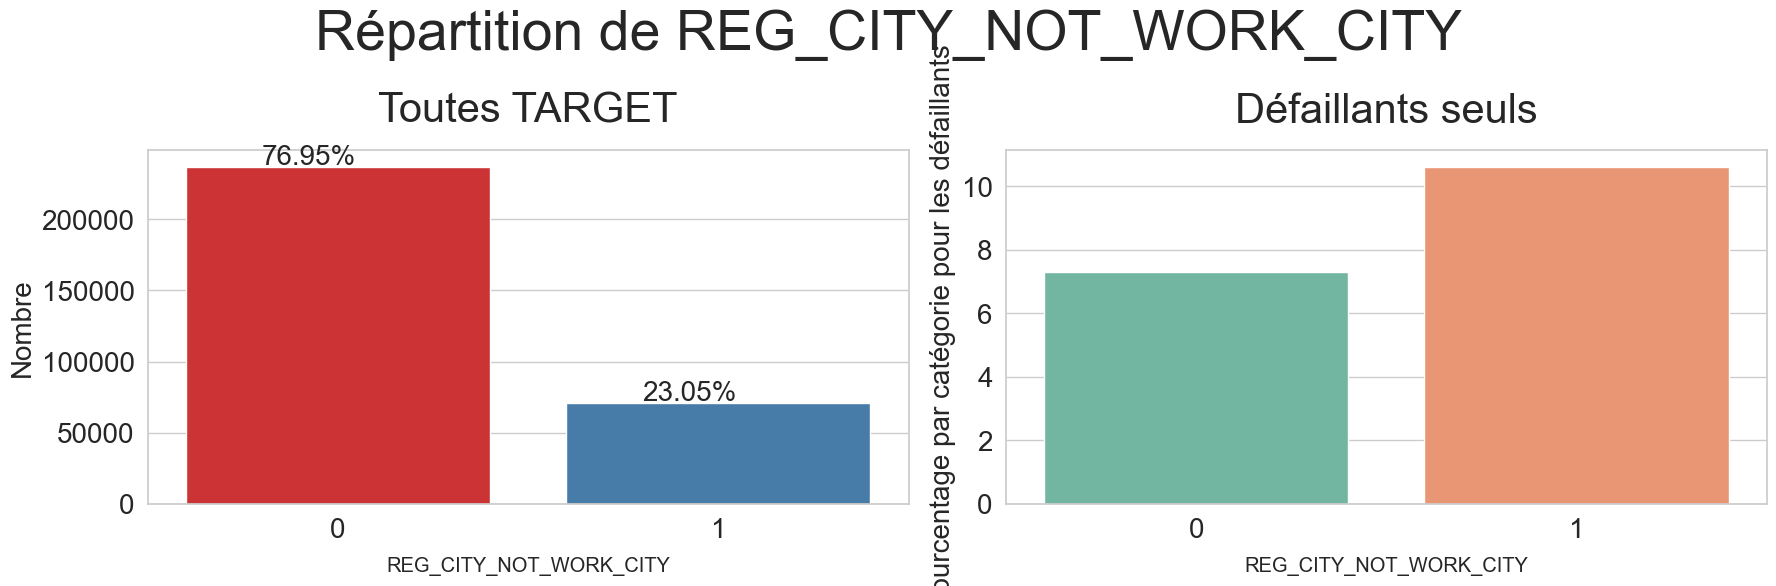

----------------------------------------------------------------------------------------------------
Nombre de catégories uniques pour LIVE_CITY_NOT_WORK_CITY = 2


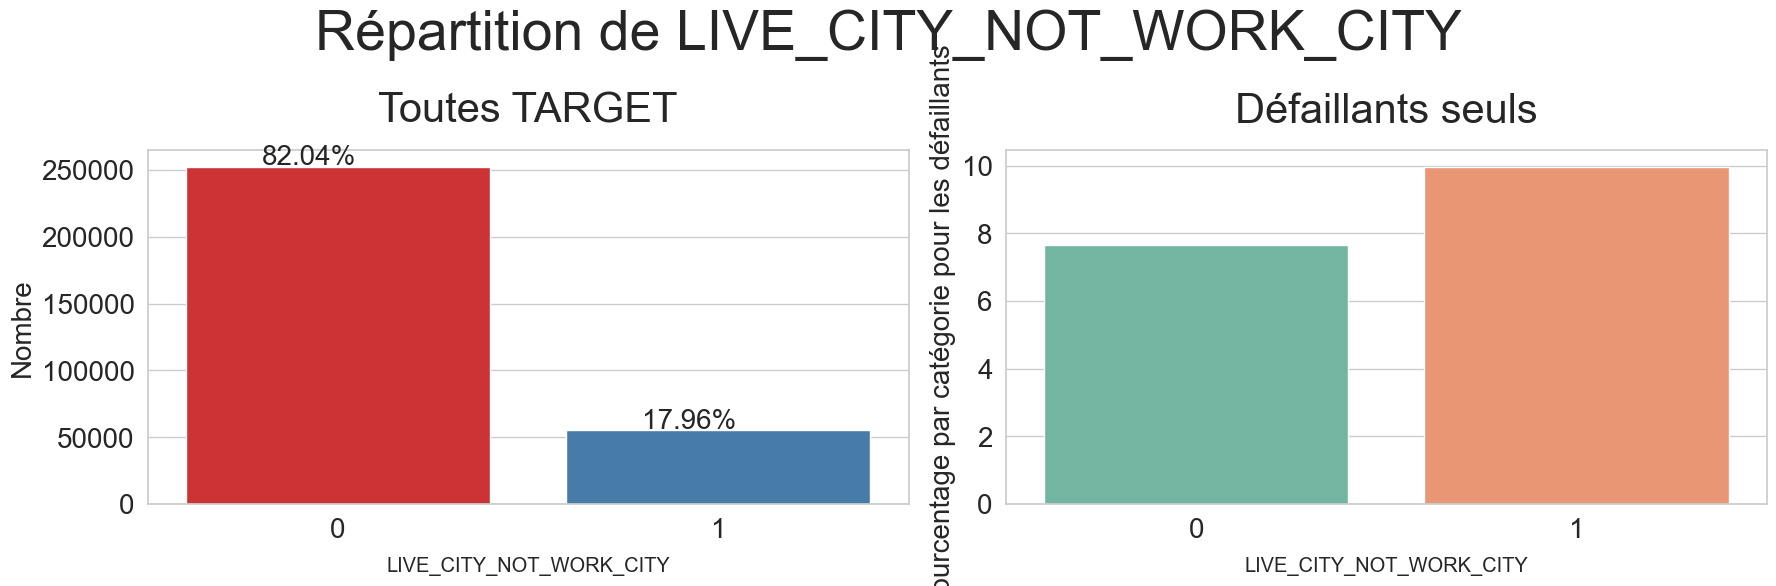

----------------------------------------------------------------------------------------------------


In [43]:
print('-'*100)
plot_categorical_variables_bar(
    application_train, column_name='REG_CITY_NOT_LIVE_CITY', figsize=(18, 6), horizontal_adjust=0.20, fontsize_percent=15,)
print('-'*100)
plot_categorical_variables_bar(
    application_train, column_name='REG_CITY_NOT_WORK_CITY', figsize=(18, 6), horizontal_adjust=0.20, fontsize_percent=20,)
print('-'*100)
plot_categorical_variables_bar(
    application_train, column_name='LIVE_CITY_NOT_WORK_CITY', figsize=(18, 6), horizontal_adjust=0.20, fontsize_percent=20,)
print('-'*100)

- **Observations et conclusions :**


Les trois graphiques ci-dessus permettent de tirer les conclusions suivantes :

- De tous les candidats, il n'y a qu'une minorité de candidats dont les adresses ne correspondent pas.


      - Tout d'abord, 7,52 % seulement des personnes ont une adresse permanente différente de leur adresse de contact au niveau de la région.
      - De plus, environ 23,05 % des personnes ont une adresse permanente différente de leur adresse professionnelle au niveau régional. Ce chiffre plus élevé s'explique par le fait qu'il est possible qu'elles travaillent dans une région différente de celle de leur adresse permanente.
      - Enfin, environ 17,96% des personnes ont une adresse permanente différente de leur adresse de contact au niveau de la ville.
      
- Si nous examinons les caractéristiques par défaut, nous constatons qu'il y a une tendance maximale à la défaillance des personnes dont l'adresse permanente et l'adresse de contact sont différentes au niveau de la région, qui est suivie par une adresse permanente et une adresse de travail différentes et enfin une adresse permanente et une adresse de contact différentes au niveau de la ville.

- Dans tous les cas, on constate que la tendance par défaut des personnes qui ont des adresses différentes est plus élevée que celle des personnes qui ont la même adresse. Cela signifie que, quelque part, cette différence d'adresse peut suggérer un risque de défaillance.

####   - Distribution de la variable catégorielle  FLAG_DOCUMENT_3


Cette colonne contient le flag d'un document qui devait être présenté par le demandeur. Sa valeur est de 0 si le client a fourni le document et de 1 si ce n'est pas le cas.

Nombre de catégories uniques pour FLAG_DOCUMENT_3 = 2


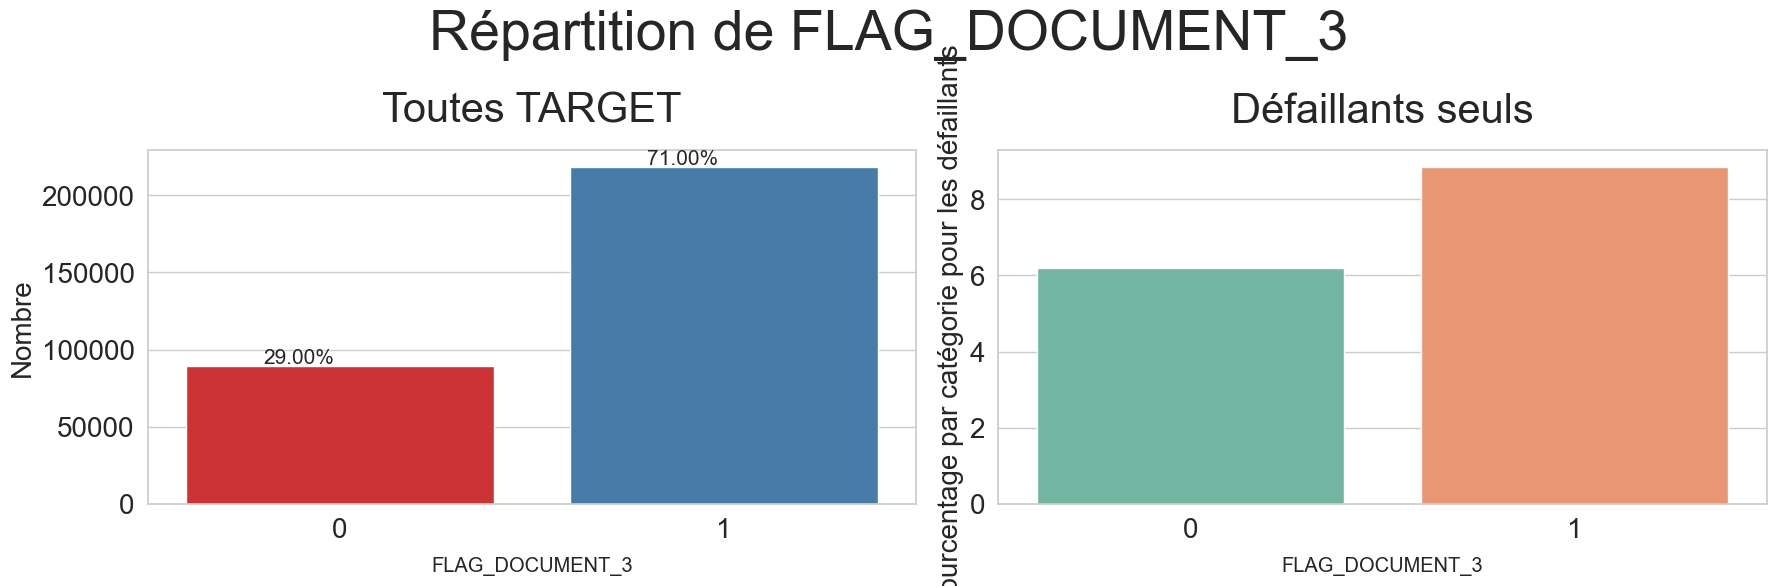

In [19]:
plot_categorical_variables_bar(
    application_train, column_name='FLAG_DOCUMENT_3', figsize=(18, 6),  horizontal_adjust=0.20, fontsize_percent=15)

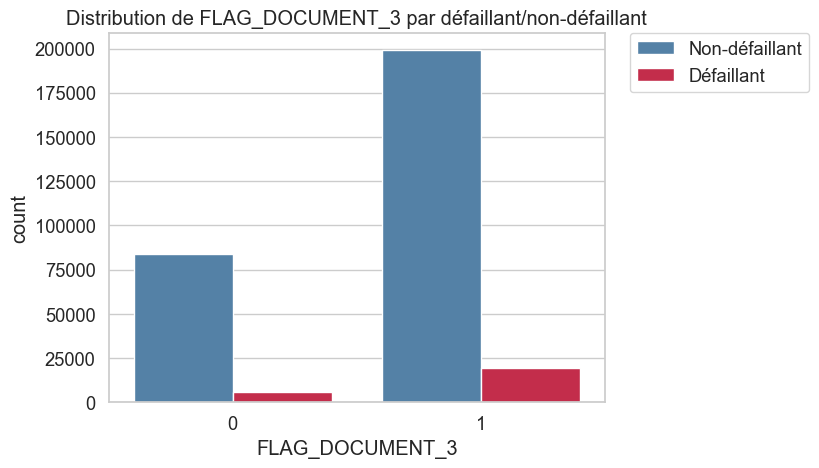

In [20]:
# Distribution par défaillants/non-défaillants
plot_barplot_comp_target(application_train,
                                              'FLAG_DOCUMENT_3')

- **Observations et conclusions :**

D'après le graphique ci-dessus, nous voyons que :

- Dans le premier sous-graphe, nous voyons que la plupart des demandeurs n'ont pas fourni ce document (~71%) et que seulement 29% l'ont fait.
- Dans le deuxième sous-graphe, nous constatons que ceux qui ont fourni ce document ont un taux de défaillance plus élevé que ceux qui ne l'ont pas fourni. Cela signifie que les demandeurs qui ont fourni le Document_3 ont tendance à manquer à leurs engagements plus que ceux qui ne l'ont pas fait.


Il pourrait peut-être s'agir d'un certificat BPL ou autre, mais nous n'avons pas reçu cette information et nous ne pouvons donc rien dire sur le type de ce document.

### Analyse de varibale numérique

####   - Distribution de l'âge variable continu du candidat


L'âge est indiqué en jours, ce qui peut être plus difficile à interpréter. Nous allons donc créer une variable latente pour stocker les âges en années, ce qui sera plus facile à analyser et à interpréter.

- Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils
sont enregistrés par rapport à la demande de prêt en cours.

- Pour voir ces statistiques en années, nous pouvons les
multiplier par -1 et les diviser par le nombre de jours dans une anné

C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




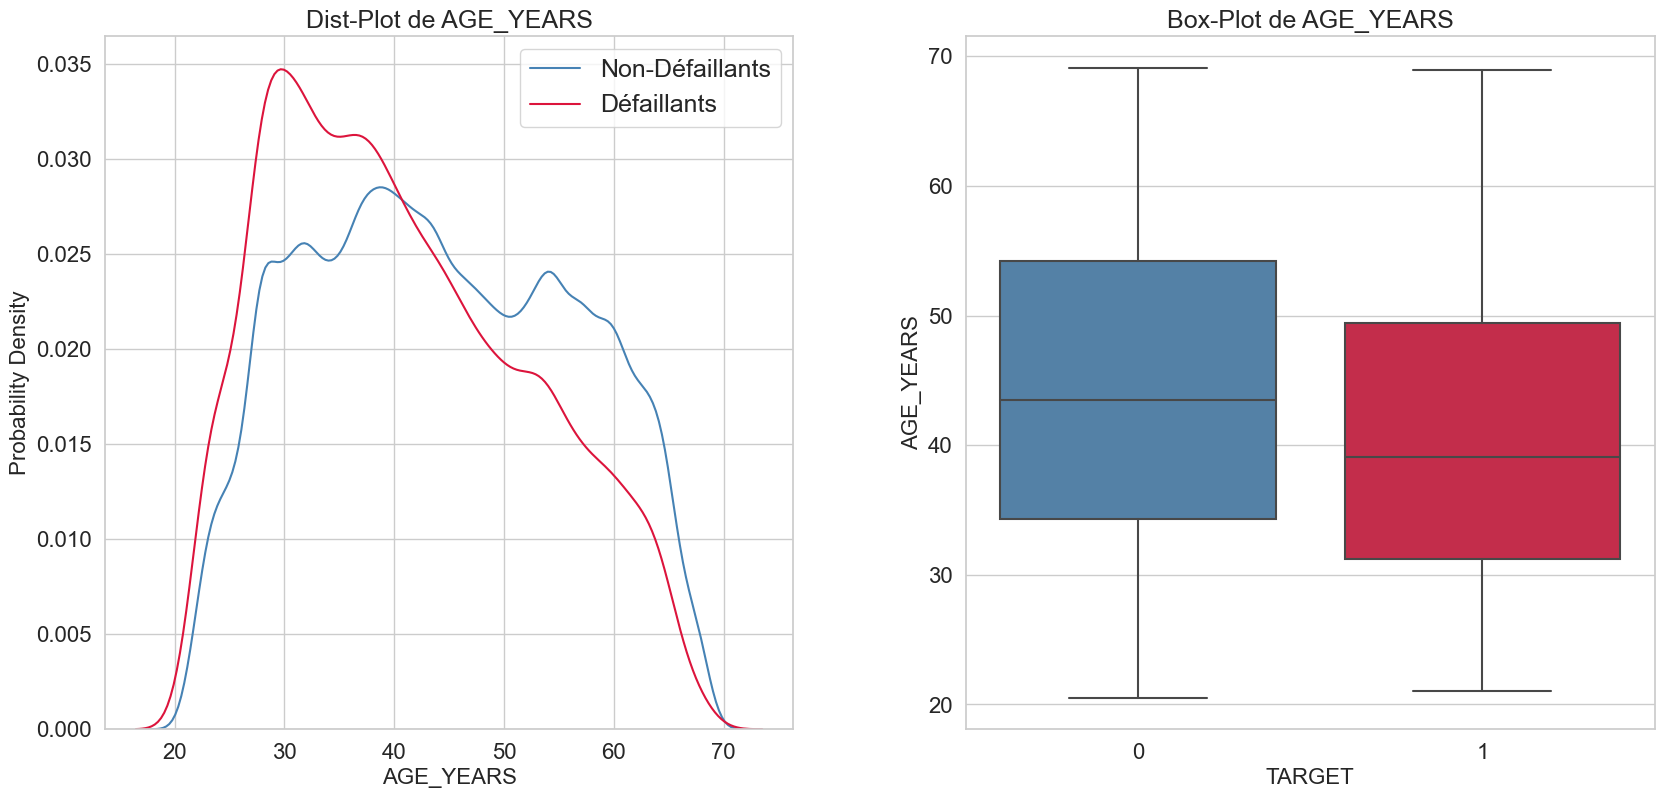

In [21]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(
    application_train, 'AGE_YEARS', plots=['distplot', 'box'])
_ = application_train.pop('AGE_YEARS')

- **Observations et conclusions :**


Les deux graphiques ci-dessus nous permettent de tirer des conclusions importantes.

- Du dist-Plot, nous pouvons observer le pic d'âge des personnes qui se rapprochent par défaut de 30 ans. En outre, à ce stade, les personnes qui ne sont pas en défaut ont une PDF beaucoup plus petite. Une autre chose à noter est que la PDF de l'âge pour les défaillants commence un peu à gauche de celle des non défaillants, et est également un peu à travers toute la gamme. Cela signifie que les défendeurs sont généralement plus jeunes que les non défendeurs.
- De la même façon, on peut mieux visualiser la même chose avec les box-plots. L'âge des défaillants est généralement inférieur à celui des non défaillants. Tous les quantiles d'âge des défaillants sont inférieurs à ceux des non défaillants. La valeur du 75e centile des non défaillants se situe autour de 54 ans, tandis que pour les défaillants, elle est proche de 49 ans. Ces observations impliquent que les défaillants sont généralement plus jeunes que les non défaillants.

####   - Distribution of Continuous Variables with DAYS features




- **DAYS_EMPLOYED**
Cette variable indique le nombre de jours à partir du jour de la demande où le demandeur a été employé. Pour faciliter l'interprétation, nous allons convertir les jours en années.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_EMPLOYED
Pecentile 0 = -17912.0
Pecentile 25 = -2760.0
Pecentile 50 = -1213.0
Pecentile 75 = -289.0
Pecentile 90 = 365243.0
Pecentile 92 = 365243.0
Pecentile 94 = 365243.0
Pecentile 96 = 365243.0
Pecentile 98 = 365243.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


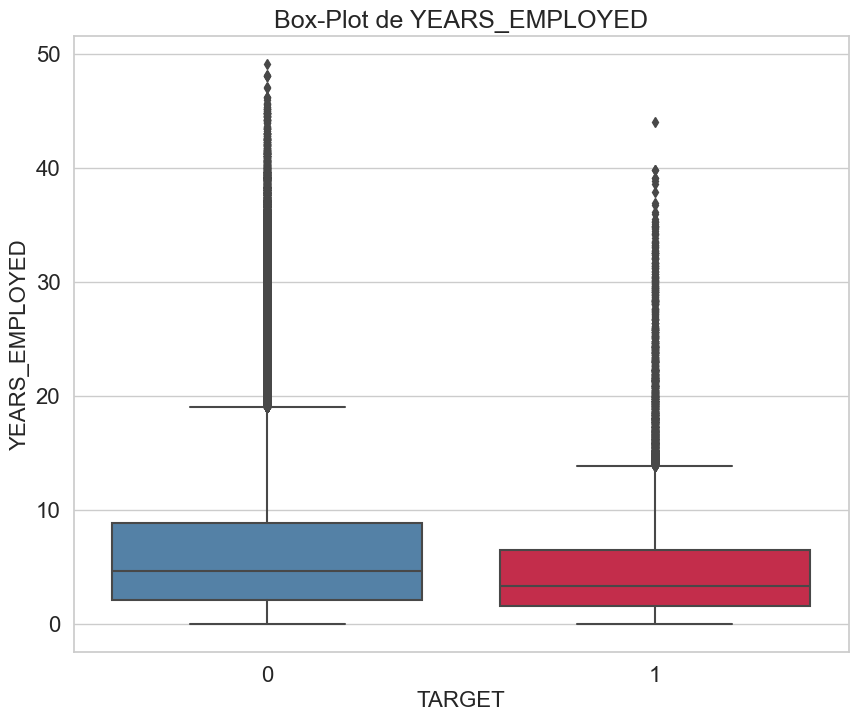

In [22]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
print_percentiles(application_train, 'DAYS_EMPLOYED')
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots=[
                          'box'], scale_limits=[0, 70], figsize=(10, 8))
_ = application_train.pop('YEARS_EMPLOYED')

- **Observations et conclusions :**
- Nous constatons que la colonne DAYS_EMPLOYED contient des points de données erronés avec les valeurs 365243. Ces valeurs semblent être erronées.
- Sur le box-plot, nous observons que les défaillants semblent avoir moins d'années d'emploi que les non défaillants. Les 25e, 50e et 75e quantiles des défaillants sont tous inférieurs à ceux des non défaillants.

- **DAYS_ID_PUBLISH**


Cette colonne indique combien de jours, à partir du jour de l'enregistrement, le client a modifié son document d'identité avec lequel il a demandé un prêt.

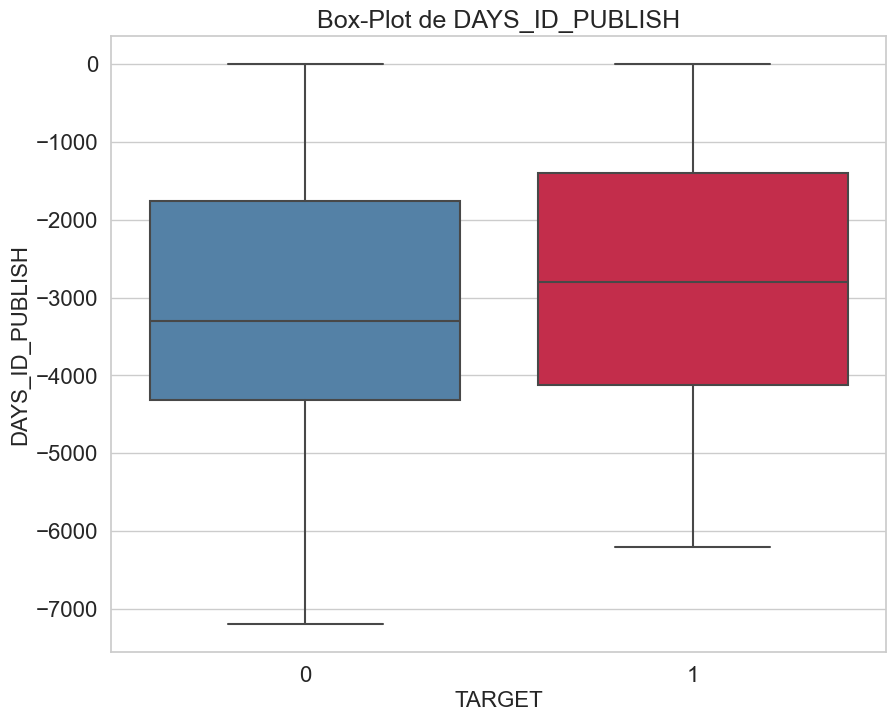

In [23]:
plot_continuous_variables(application_train, 'DAYS_ID_PUBLISH', plots=[
                          'box'], figsize=(10, 8))

- **Observations et conclusions :**


Le graphique ci-dessus montre une tendance similaire à celle de DAYS_REGISTRATION, où le nombre de jours écoulés depuis le changement d'identité des défaillants est généralement inférieur. Les non défaillants affichent un nombre de jours plus élevé pour tous les quantiles depuis qu'ils ont changé leur document d'identité.

####   - Distribution de EXT_SOURCES


Voici trois colonnes **EXT_SOURCES**, qui contiennent des valeurs entre 0 et 1. Il s'agit de scores normalisés provenant de différentes sources

----------------------------------------------------------------------------------------------------


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




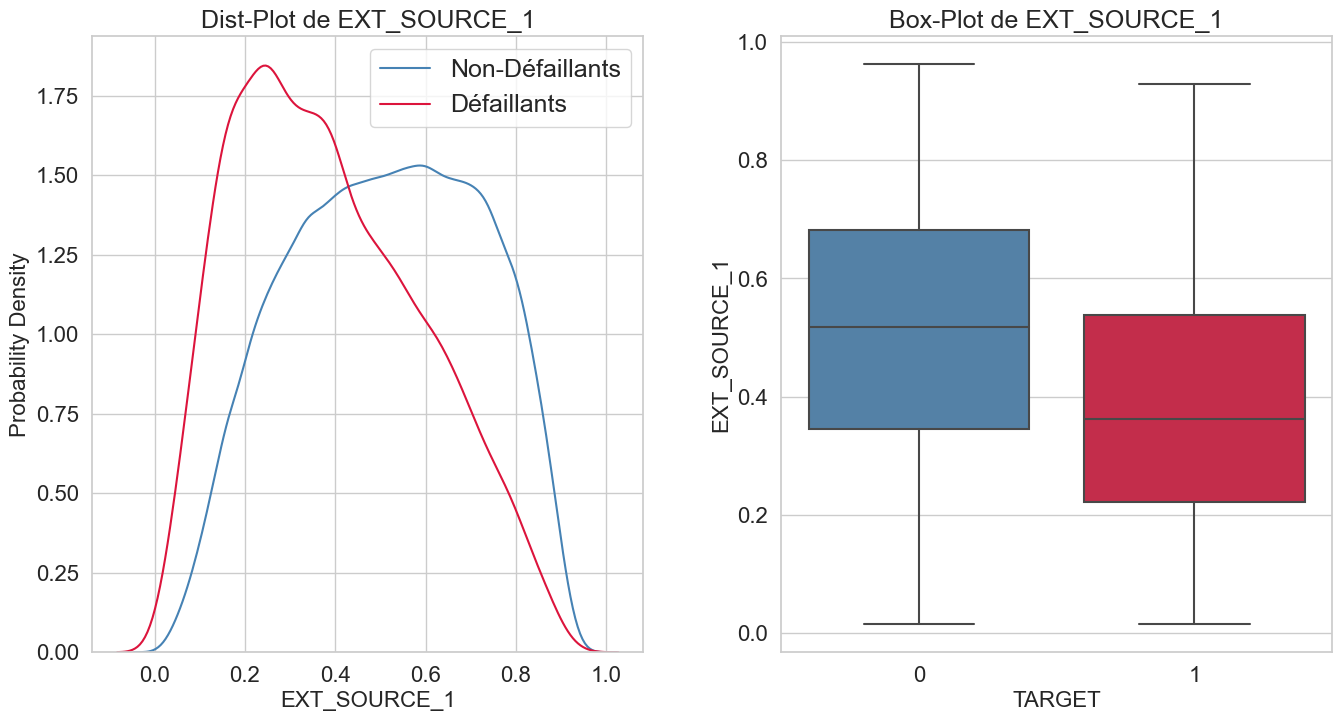

----------------------------------------------------------------------------------------------------


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




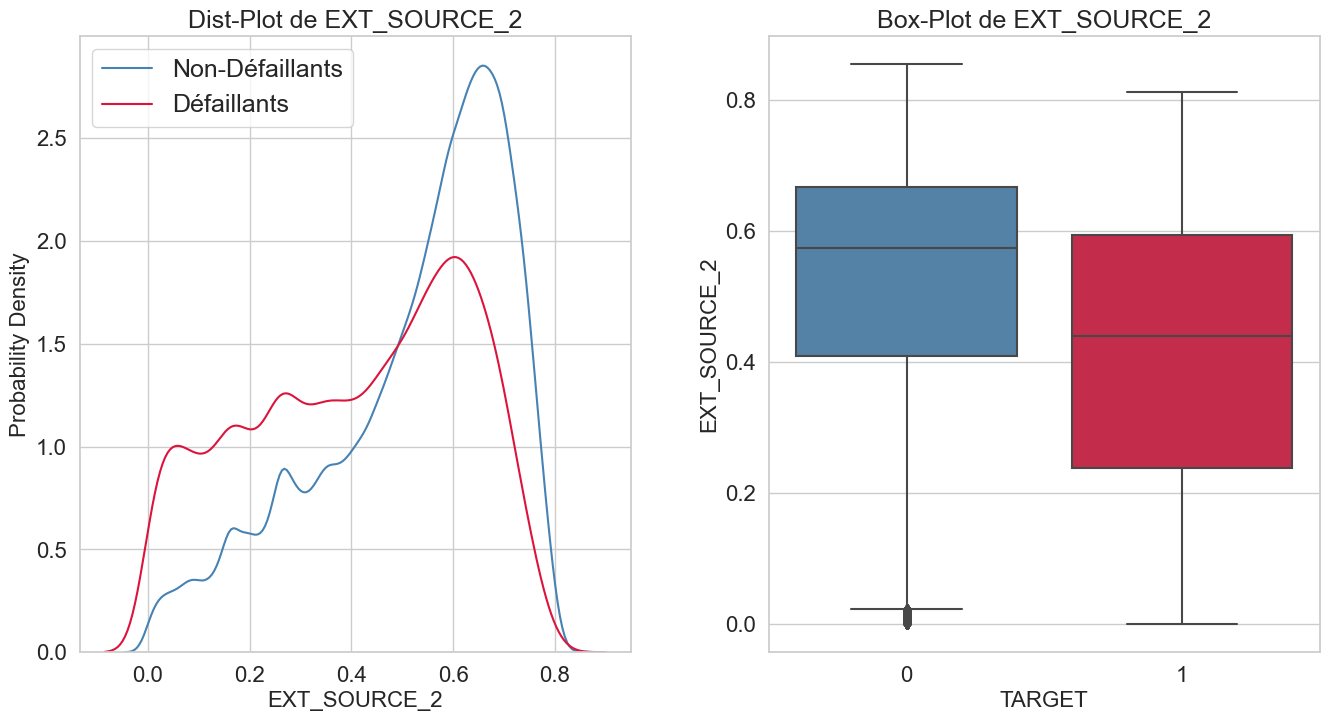

----------------------------------------------------------------------------------------------------


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




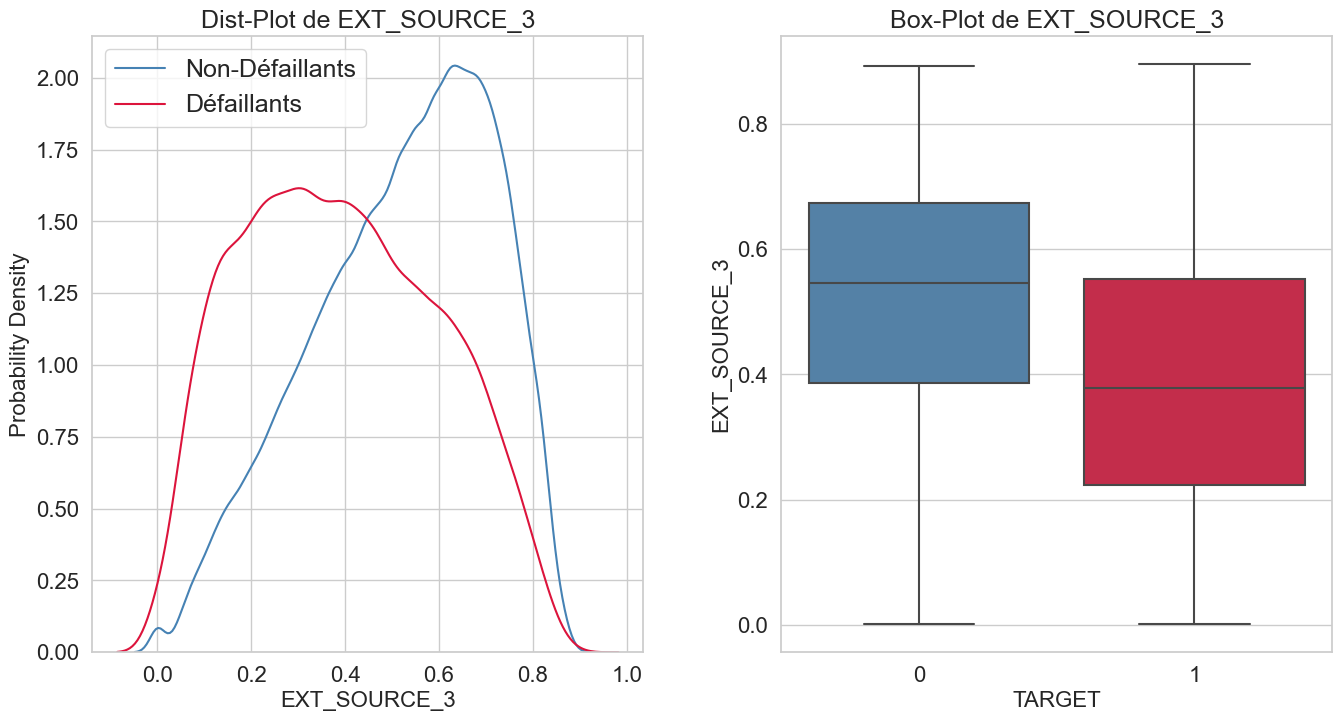

----------------------------------------------------------------------------------------------------


In [24]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots=[
                          'distplot', 'box'], figsize=(16, 8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots=[
                          'distplot', 'box'], figsize=(16, 8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots=[
                          'distplot', 'box'], figsize=(16, 8))
print('-'*100)


- **Observations et conclusions :**

Les trois graphiques ci-dessus nous permettent de tirer les conclusions suivantes :

- Si nous examinons les graphiques en boîte, nous pouvons clairement voir une tendance similaire pour les trois colonnes EXT_SOURCE, c'est-à-dire que les valeurs par défaut ont tendance à être considérablement plus faibles.
- Cette tendance peut également être observée pour les PDF. Les non défaillants présentent un pic plus élevé pour les valeurs EXT_SOURCE élevées, et les densités de probabilité sont très faibles pour les valeurs faibles. Cela implique que les Non-défaillants ont généralement des valeurs élevées de ces scores.
- Il est intéressant de noter que la valeur médiane pour les défaillants est presque égale ou inférieure aux valeurs du 25e percentile des non défaillants.

- Les colonnes EXT_SOURCE_1 et EXT_SOURCE_3 tendent à montrer une meilleure discrimination/séparabilité par rapport à EXT_SOURCE_2. Ces 3 caractéristiques semblent être les meilleures pour séparer linéairement les défaillants et les non-défaillants parmi toutes les caractéristiques jusqu'à présent.

Text(0.5, 1.0, 'Correlation Heatmap')

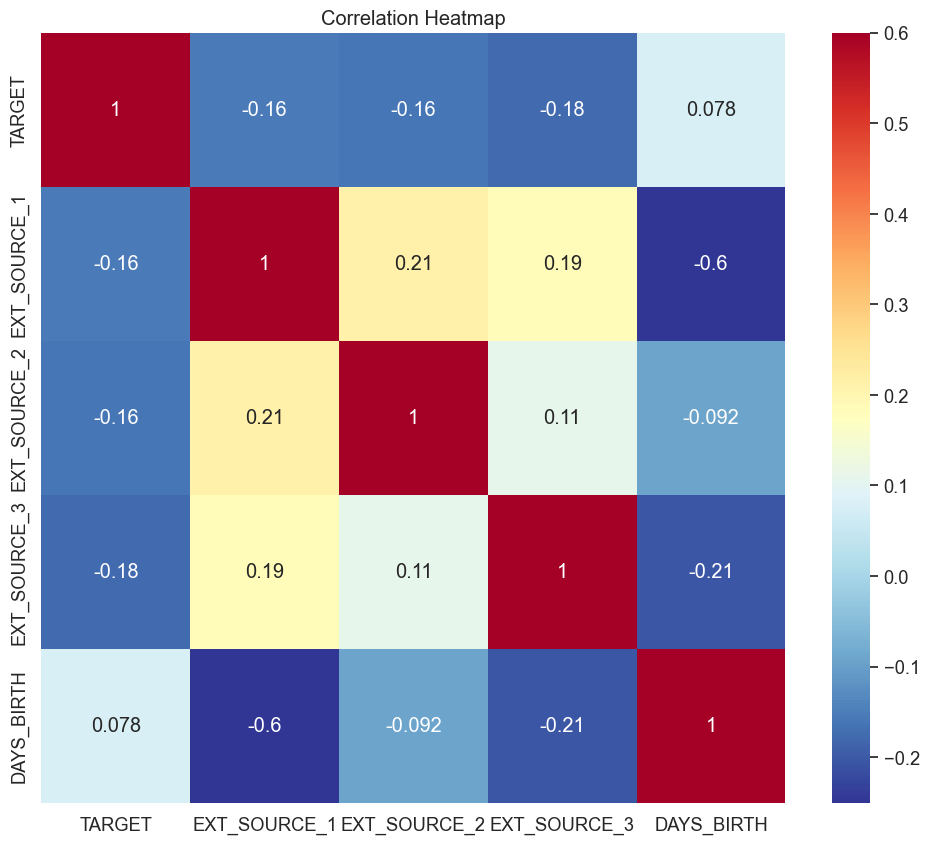

In [25]:
ext_data =application_train[['TARGET', 'EXT_SOURCE_1',
                              'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

# afficher la matrice de corélation 

plt.figure(figsize=(12,10))
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r,
            vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives
avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE
augmente, plus le client est susceptible de rembourser le prêt.
Nous pouvons également voir que DAYS_BIRTH est positivement corrélé
avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score
est peut-être l'âge du client.

####   -  Distribution de FLOORSMAX_AVG et FLOORSMIN_MODE


Ces colonnes décrivent les scores normalisés de la moyenne du nombre maximum d'étages et du mode du nombre minimum d'étages dans le bâtiment du demandeur

C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




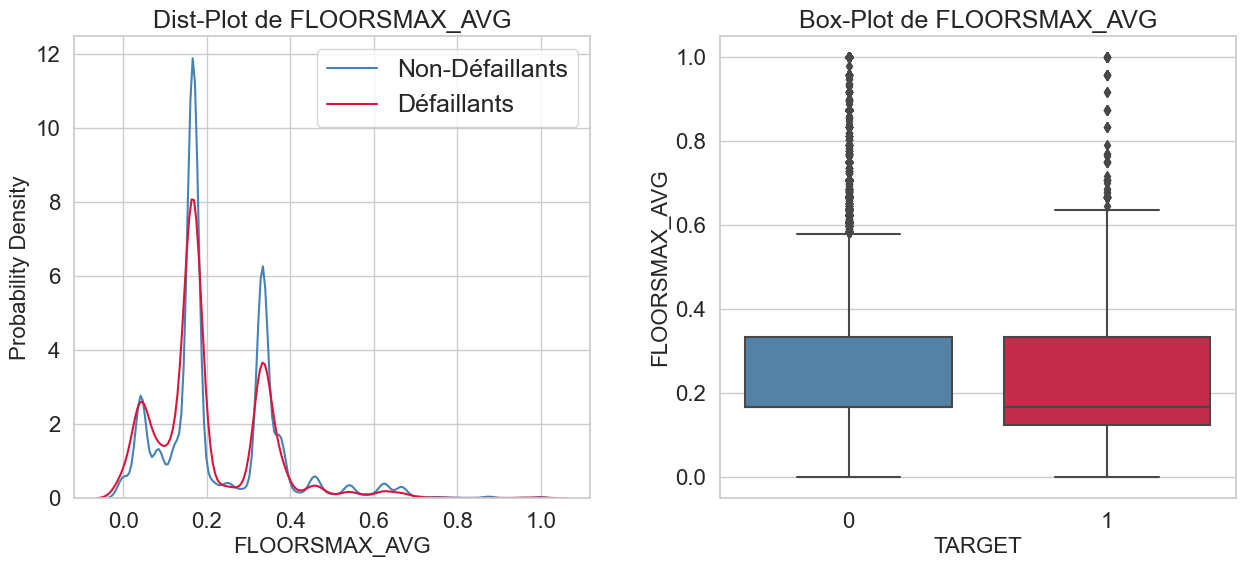

In [26]:
# Boxplot de FLOORSMAX_AVG
plot_continuous_variables(application_train,
                                               'FLOORSMAX_AVG',
                                               plots=['distplot', 'box'],
                                               figsize=(15, 6))

C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




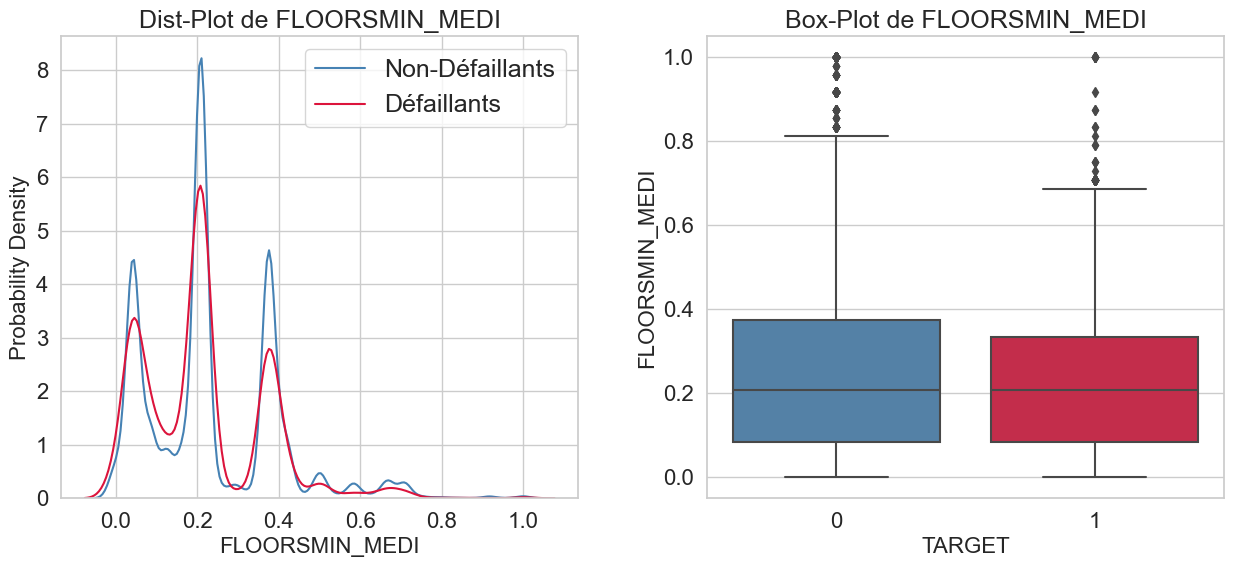

In [27]:
# Boxplot de FLOORSMIN_MEDI
plot_continuous_variables(application_train,
                                               'FLOORSMIN_MEDI',
                                               plots=['distplot', 'box'],
                                               figsize=(15, 6))

- **Observations et conclusions :**

- Le boxplot montre que les défaillants ont une valeur médiane de la caractéristique FLOORSMAX_AVG inférieure à celle des non-défaillants.
- Les valeurs du 75e percentile des défaillants et des non-défaillants sont plus ou moins les mêmes, mais la valeur du 25e percentile des non-défaillants est presque supérieure à la médiane des défaillants.



Cette variable pourrait être une variable importante pour départager les défaillants des non-défaillants.

# 2 - bureau


Données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque ligne concerne un crédit antérieur identifié par la variable **SK_ID_BUREAU**.

In [28]:
#la structure des dataframes
data_structure(bureau)

Caractéristiques  Valeurs
0                   Nombre de lignes  1716428
1                 Nombre de colonnes       17
2  Nombre de variables catégorielles        3
3    Nombre de variables numériques        14
4  Pourcentage de données manquantes      229
5                 Nombre de doublons        0

Valeurs manquantes :3939947 NaN pour 29179276 données (13.5 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  % de valeurs manquantes
AMT_ANNUITY                                   1226791                    71.47
AMT_CREDIT_MAX_OVERDUE                        1124488                    65.51
DAYS_ENDDATE_FACT                              633653                    36.92
AMT_CREDIT_SUM_LIMIT                           591780                    34.48
AMT_CREDIT_SUM_DEBT                            257669                    15.01
DAYS_CREDIT_ENDDATE                            105553                     6.15
AMT_CREDIT_SUM                                     13                     0.00

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


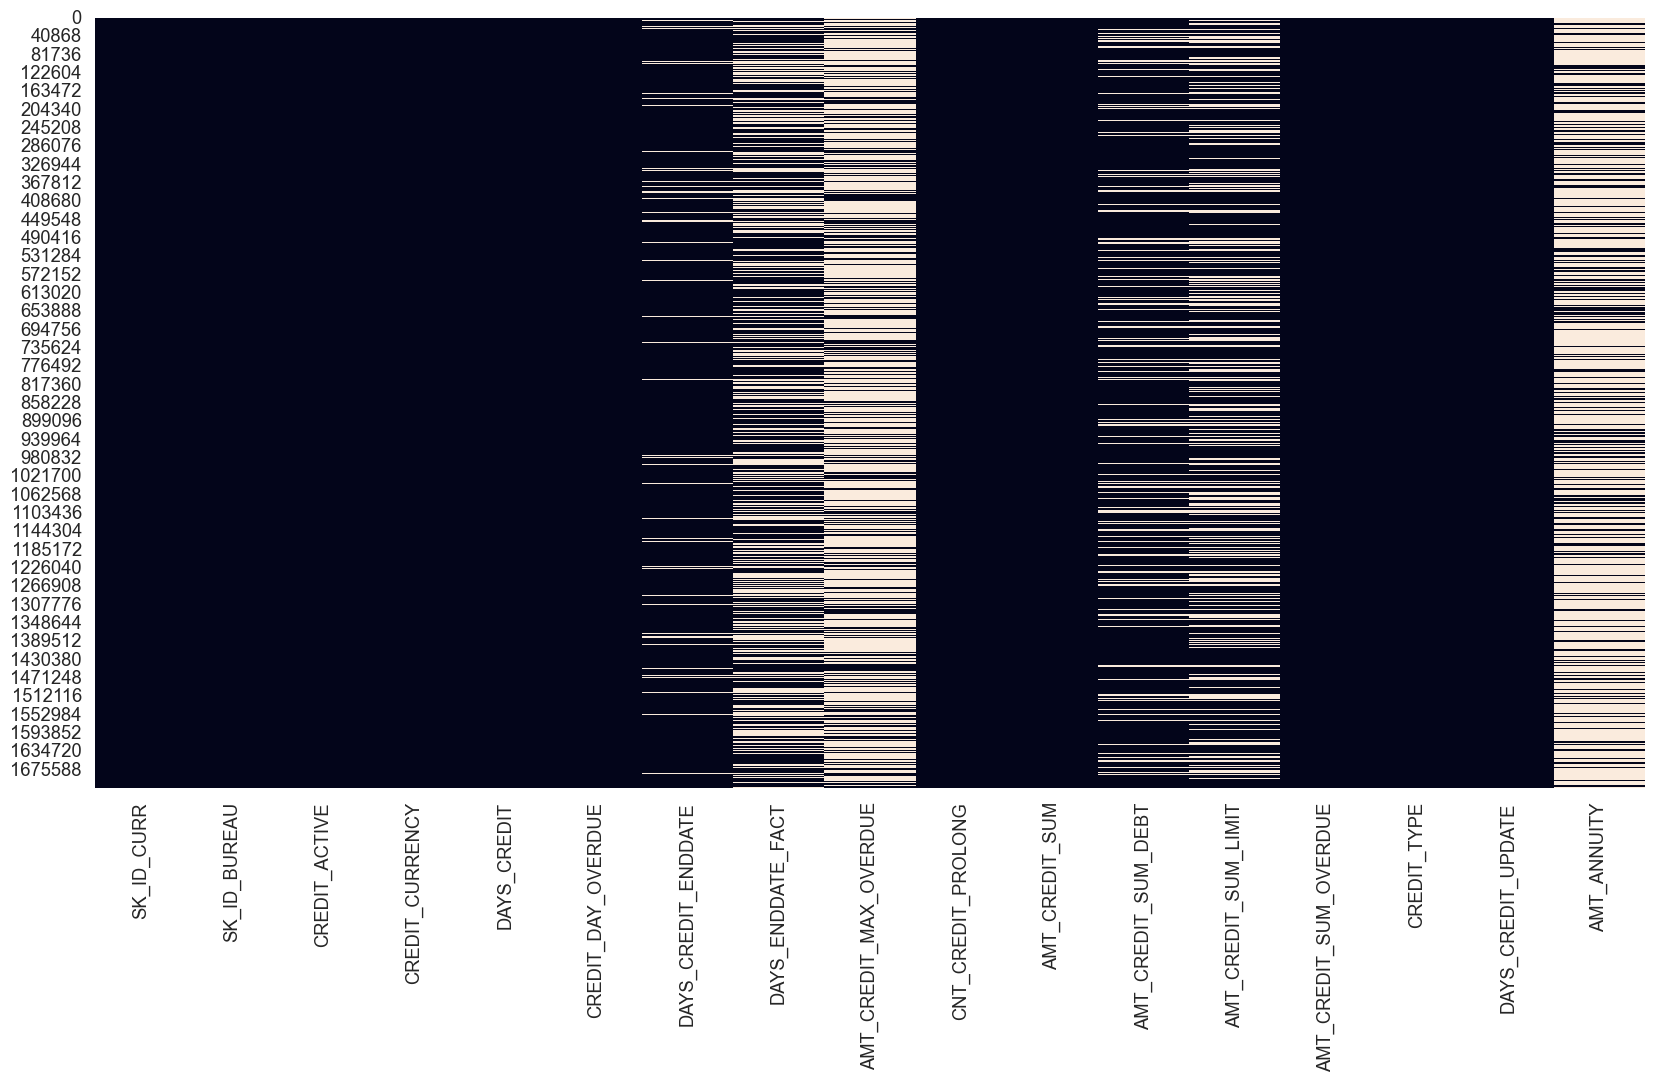

In [29]:
#afficher le pourcentage des valeurs nulls et les visualiser 
valeur_null(bureau, True,True)

In [30]:
# description des variables qualitatives/quantitatives
desc_var(bureau, type_var='all')

SK_ID_CURR    SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  \
type          float64         float64        object          object   
nb_nan            0.0             0.0           0.0             0.0   
%_nan             0.0             0.0           0.0             0.0   
count       1716428.0       1716428.0       1716428         1716428   
unique            NaN             NaN             4               4   
top               NaN             NaN        Closed      currency 1   
freq              NaN             NaN       1079273         1715020   
mean    278214.933645  5924434.489032           NaN             NaN   
std     102938.558112   532265.728552           NaN             NaN   
min          100001.0       5000000.0           NaN             NaN   
25%         188866.75      5463953.75           NaN             NaN   
50%          278055.0       5926303.5           NaN             NaN   
75%          367426.0      6385681.25           NaN             NaN   
max          456255.0       6843457.0           NaN             NaN   

        DAYS_CREDIT CREDIT_DAY_OVERDUE DAYS_CREDIT_ENDDATE DAYS_ENDDATE_FACT  \
type        float64            float64             float64           float64   
nb_nan          0.0                0.0            105553.0          633653.0   
%_nan           0.0                0.0            6.149573         36.916958   
count     1716428.0          1716428.0           1610875.0         1082775.0   
unique          NaN                NaN                 NaN               NaN   
top             NaN                NaN                 NaN               NaN   
freq            NaN                NaN                 NaN               NaN   
mean   -1142.107685           0.818167          510.517362      -1017.437148   
std      795.164928          36.544428         4994.219837        714.010626   
min         -2922.0                0.0            -42060.0          -42023.0   
25%         -1666.0                0.0             -1138.0           -1489.0   
50%          -987.0                0.0              -330.0            -897.0   
75%          -474.0                0.0               474.0            -425.0   
max             0.0             2792.0             31199.0               0.0   

       AMT_CREDIT_MAX_OVERDUE CNT_CREDIT_PROLONG AMT_CREDIT_SUM  \
type                  float64            float64        float64   
nb_nan              1124488.0                0.0           13.0   
%_nan               65.513264                0.0       0.000757   
count                591940.0          1716428.0      1716415.0   
unique                    NaN                NaN            NaN   
top                       NaN                NaN            NaN   
freq                      NaN                NaN            NaN   
mean              3825.417661            0.00641  354994.591918   
std             206031.606207           0.096224  1149811.34398   
min                       0.0                0.0            0.0   
25%                       0.0                0.0        51300.0   
50%                       0.0                0.0       125518.5   
75%                       0.0                0.0       315000.0   
max               115987185.0                9.0    585000000.0   

       AMT_CREDIT_SUM_DEBT AMT_CREDIT_SUM_LIMIT AMT_CREDIT_SUM_OVERDUE  \
type               float64              float64                float64   
nb_nan            257669.0             591780.0                    0.0   
%_nan            15.011932            34.477415                    0.0   
count            1458759.0            1124648.0              1716428.0   
unique                 NaN                  NaN                    NaN   
top                    NaN                  NaN                    NaN   
freq                   NaN                  NaN                    NaN   
mean         137085.119952           6229.51498              37.912758   
std          677401.130952         45032.031476            5937.650035  

In [31]:
print('-'*100)
print(
    f'Number of unique SK_ID_BUREAU in bureau.csv are: {len(bureau.SK_ID_BUREAU.unique())}')
print(
    f'Number of unique SK_ID_CURR in bureau.csv are: {len(bureau.SK_ID_CURR.unique())}')
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)


----------------------------------------------------------------------------------------------------
Number of unique SK_ID_BUREAU in bureau.csv are: 1716428
Number of unique SK_ID_CURR in bureau.csv are: 305811
Number of overlapping SK_ID_CURR in application_train.csv and bureau.csv are: 263491
Number of overlapping SK_ID_CURR in application_test.csv and bureau.csv are: 42320
----------------------------------------------------------------------------------------------------


- **Observations et conclusions:**

1. Sur 17 variables, 7 contiennent des valeurs de NaN.
2. Les valeurs de NaN les plus élevées sont observées dans la colonne AMT_ANNUITY qui comporte plus de 70 % de valeurs manquantes.
3. Le fichier bureau.csv contient près de 1,7 millions de points de données, avec 17 caractéristiques. Sur ces 17 caractéristiques, deux sont SK_ID_CURR et SK_ID_BUREAU.
 -  SK_ID_BUREAU est l'identifiant du prêt précédent du client auprès d'autres institutions financières. Il peut y avoir plusieurs prêts précédents correspondant à un seul SK_ID_CURR, qui dépend du profil d'emprunt du client.
 - SK_ID_CURR est l'identifiant du prêt actuel du client avec Home Credit.
  - Il y a 305k SK_ID_CURR unique en bureau dont :
   - Il y a 263k SK_ID_CURR au bureau qui sont présents dans application_train sur un total de 307k de SK_ID_CURR uniques d'application_train. Cela signifie que certains des demandeurs dans la demande de prêt actuelle avec le Home Credit Group n'ont pas d'antécédents de crédit avec le département du bureau de crédit.

- **Merging the TARGETS from application_train to bureau table**

In [32]:
print("-"*100)
print("Merging TARGET with bureau Table")
bureau_merged = application_train.iloc[:, :2].merge(
    bureau, on='SK_ID_CURR', how='left')
print("-"*100)
print( bureau_merged.shape)

----------------------------------------------------------------------------------------------------
Merging TARGET with bureau Table
----------------------------------------------------------------------------------------------------
(1509345, 18)


### Matrice Phi-K 

-------------------------------------------------------------------------------


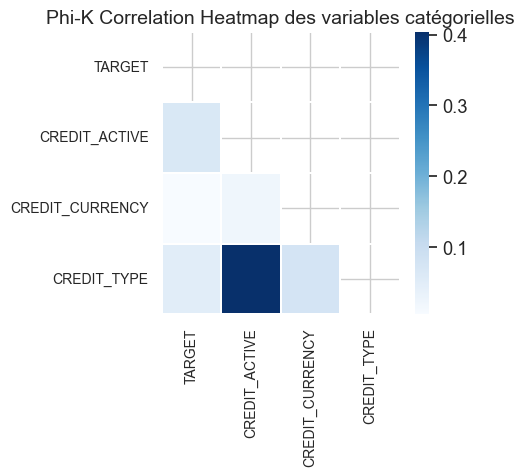

-------------------------------------------------------------------------------
Les catégories présentant les valeurs les plus élevées de la corrélation Phi-K avec la variable cible sont les suivantes :


-------------------------------------------------------------------------------


In [33]:

cols_for_phik = ['TARGET', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize=(5, 5))

### Matrice de corrélation 

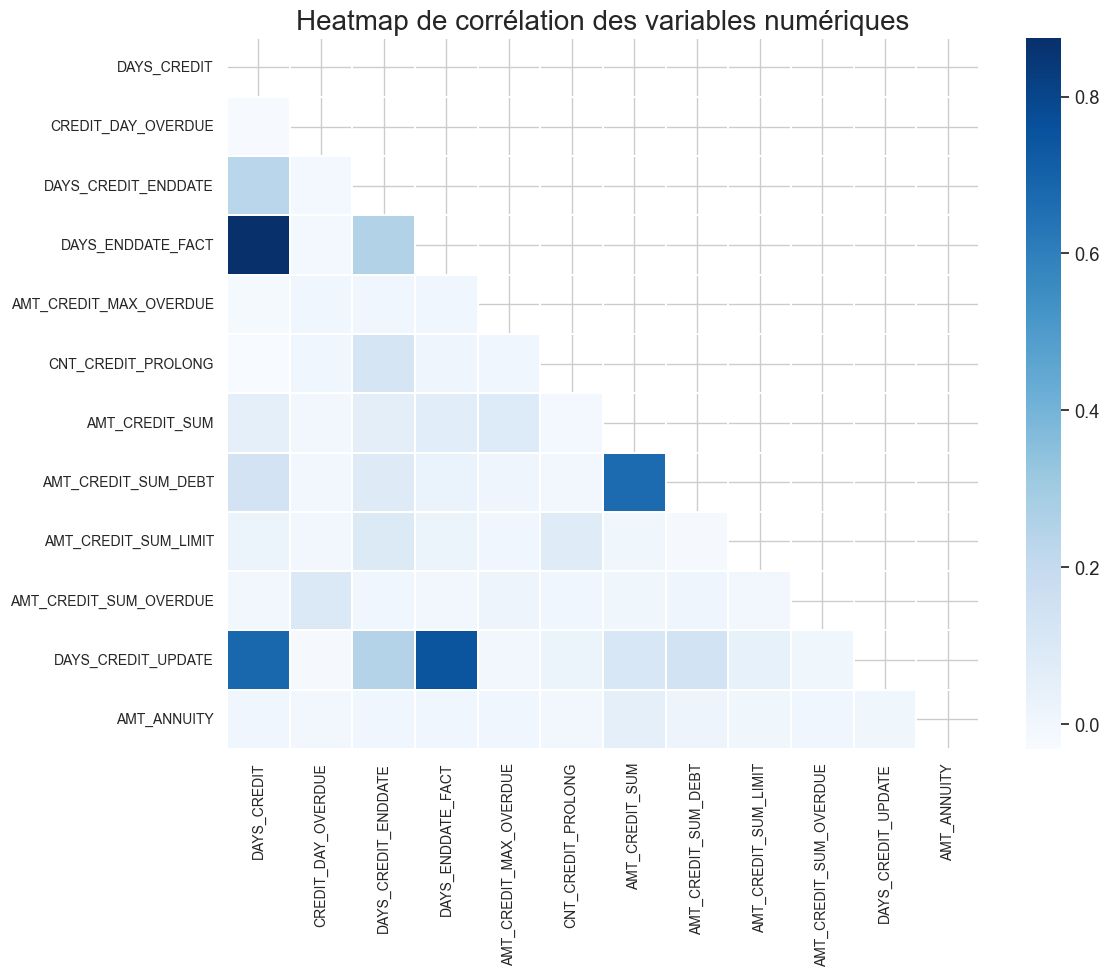

In [34]:
corr_mat = correlation_matrix(
    bureau_merged, ['SK_ID_CURR', 'SK_ID_BUREAU'], cmap='Blues', figsize=(12, 10))
corr_mat.plot_correlation_matrix()

- **Observations et conclusions :**
1. La carte thermique ci-dessus montre les valeurs de la corrélation Phi-K entre les valeurs catégorielles.

- À partir du coefficient de corrélation Phi-K, nous voyons que la variable CREDIT_TYPE présente une certaine association avec la variable CREDIT_ACTIVE.
- Nous constatons que les variables catégorielles ne sont pas vraiment associées à la variable TARGET, en particulier la fonction CREDIT_CURRENCY.

2. On peut observer que la plupart des cartes thermiques ont des couleurs claires, ce qui montre peu ou pas de corrélation.
 - Cependant, nous pouvons voir quelques nuances sombres qui représentent une forte corrélation.
 - La corrélation élevée est particulièrement observée pour les caractéristiques :
     - DAYS_CREDIT et DAYS_CREDIT_UPDATE
     - DAYS_ENDDATE_FACT et DAYS_CREDIT_UPDATE
     - AMT_CREDIT_SUM et AMT_CREDIT_SUM_DEBT
     - DAYS_ENDDATE_FACT et DAYS_CREDIT
     
     
     
Nous pouvons également constater que les fonctions ne présentent pas particulièrement de corrélation bonne/élevée avec Target en tant que tel, à l'exception de la fonction DAYS_CREDIT. Cela signifie qu'il n'y a pas de relation linéaire directe entre Target et les variables.

- **Distribution de Categorical Variable CREDIT_ACTIVE**


Cette colonne décrit l'état du prêt précédent signalé par le bureau de crédit.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CREDIT_ACTIVE' sont :
['Closed' 'Active' nan 'Sold' 'Bad debt']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Closed      917733
Active      541919
Sold          5653
Bad debt        20
Name: CREDIT_ACTIVE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CREDIT_ACTIVE = 5


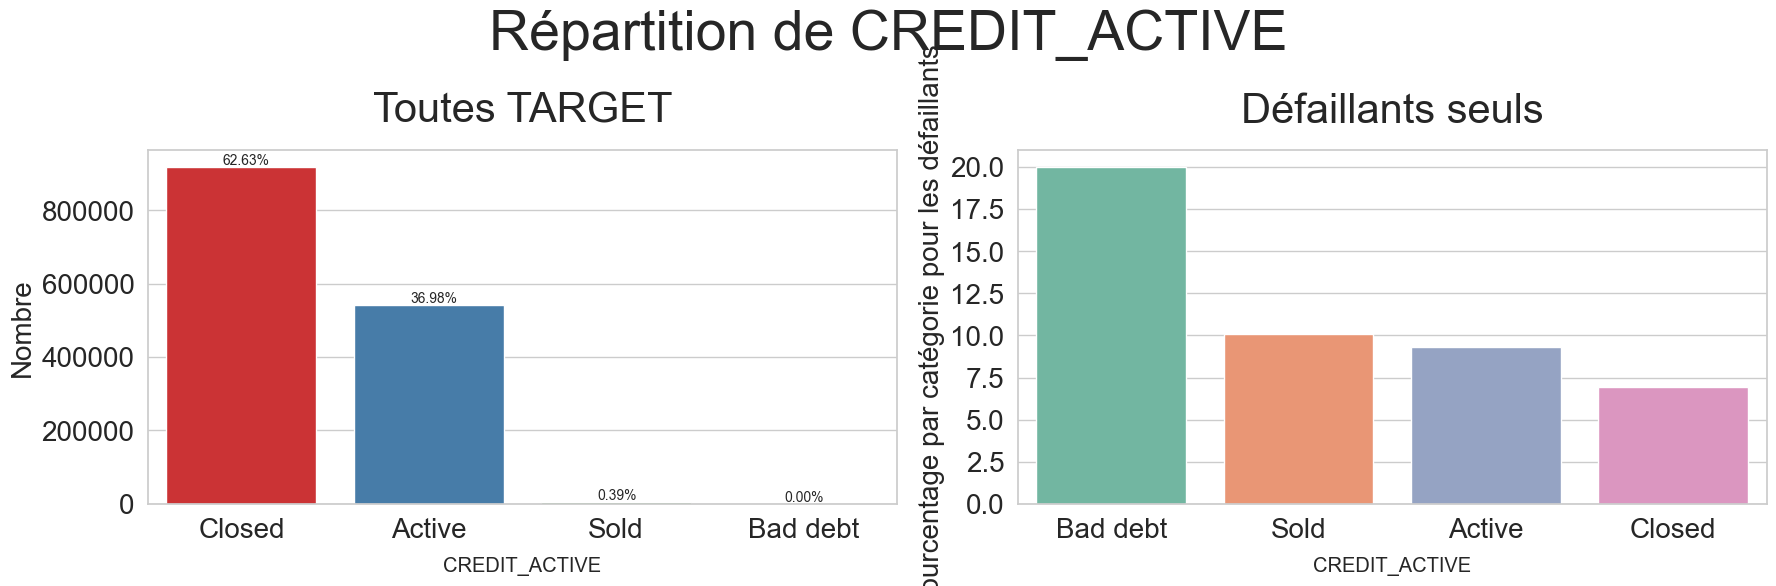

----------------------------------------------------------------------------------------------------


In [35]:
# let us first see the unique categories of 'CREDIT_ACTIVE'
print_unique_categories(bureau_merged, 'CREDIT_ACTIVE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    bureau_merged, column_name='CREDIT_ACTIVE', horizontal_adjust=0.3, fontsize_percent='x-small')
print('-'*100)

- **Observations et conclusions :**


Du graphique ci-dessus, nous pouvons tirer les conclusions suivantes :

- A partir du premier subplot, nous voyons qu'une majorité des prêts précédents d'autres institutions financières sont des prêts fermés (62,63%), suivis par 36,98% de prêts actifs. Les prêts vendus et les prêts pour créances douteuses sont très peu nombreux.
- Si l'on examine le pourcentage de défaillants par catégorie, on constate qu'environ 20 % des personnes de Bad-Debt ont fait défaut, ce qui est le taux de défaillance le plus élevé. Viennent ensuite les prêts vendus et les prêts actifs. Le taux de défaillance le plus faible concerne les prêts fermés, qui présentent un bon historique de clients. La tendance observée ici est donc tout à fait logique et attendue.

- **Distribution de Variable avec DAYS ( jour) Features**



**DAYS_CREDIT**

Cette colonne décrit le nombre de jours avant la demande actuelle lorsque le client a fait une demande de crédit auprès d'un bureau de crédit. Pour faciliter l'interprétation, nous allons convertir ces jours en années.

C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




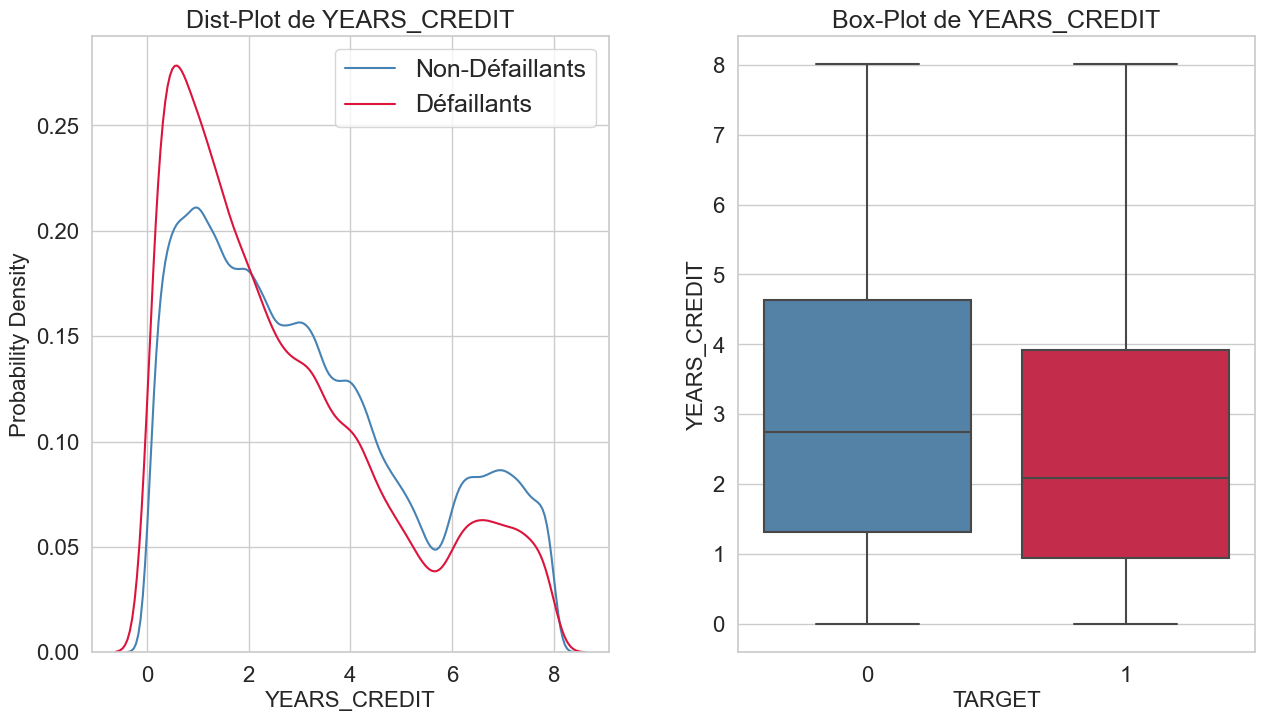

In [36]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT'] / -365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots=[
                          'distplot', 'box'], figsize=(15, 8))
_ = bureau_merged.pop('YEARS_CREDIT')

- **Observations et conclusions :**


C'est ce que l'on constate à partir des tracés ci-dessus :

-  nous voyons que les défaillants ont tendance à avoir des pics plus élevés que les non défaillants lorsque le nombre d'années est inférieur.. Cela implique que les demandeurs qui ont demandé des prêts au Bureau de crédit récemment ont montré une tendance à la défaillance plus importante que ceux qui ont demandé un prêt il y a longtemps. Le PDF des défaillants est également un peu plus à gauche que celui des non défaillants.
- En examinant le graphique, on constate que les défaillants ont généralement moins d'ANNÉES_CRÉDIT que les non défaillants.

**DAYS_CREDIT_ENDDATE**


Cette rubrique renseigne sur la durée restante du crédit du Bureau de crédit au moment de la demande de prêt au Crédit immobilier.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_CREDIT_ENDDATE
Pecentile 0 = -42060.0
Pecentile 2 = -2487.0
Pecentile 4 = -2334.0
Pecentile 6 = -2202.0
Pecentile 8 = -2073.9199999999983
Pecentile 10 = -1939.0
Pecentile 25 = -1144.0
Pecentile 50 = -334.0
Pecentile 75 = 473.0
Pecentile 100 = 31199.0
-------------------------------------------------------------------------------


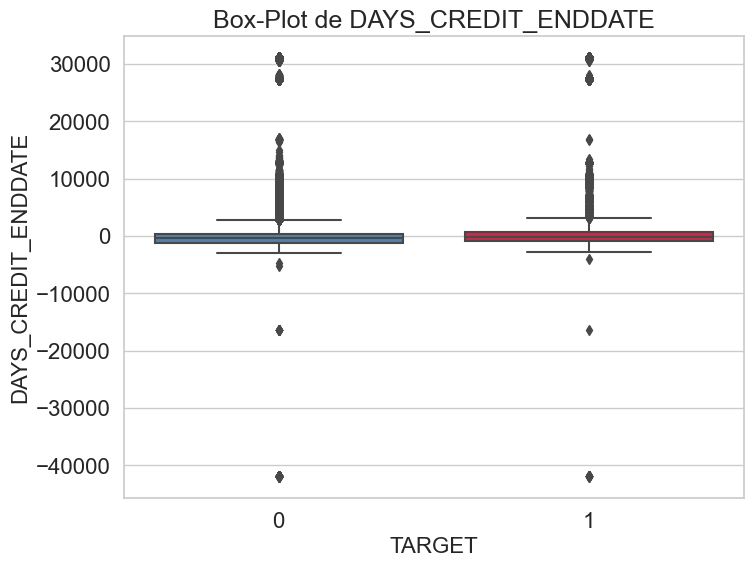

----------------------------------------------------------------------------------------------------


In [37]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_ENDDATE',
                  percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots=[
                          'box'], figsize=(8, 6))
print('-'*100)

- **Observations et conclusions :**


D'après les valeurs de percentile ci-dessus, et en regardant le box-plot, nous constatons qu'il semble y avoir une valeur erronée pour DAYS_CREDIT_ENDDATE, où la valeur du 0e percentile remonte à aussi longtemps que 42060 jours ou 115 ans. Cela n'a pas beaucoup de sens, car cela implique que le prêt précédent du client remonte à 115 ans. Il pourrait s'agir d'un prêt hérité également, mais nous ne pouvons pas faire de commentaires aussi sûrs à ce sujet. Nous essaierions de supprimer ces valeurs lors de la phase de prétraitement des données

**DAYS_ENDDATE_FACT**


Cette colonne indique le nombre de jours écoulés depuis la fin du crédit du Bureau de crédit au moment de la demande de prêt au Crédit immobilier. Ces valeurs ne concernent que les crédits fermés.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_ENDDATE_FACT
Pecentile 0 = -42023.0
Pecentile 2 = -2561.0
Pecentile 4 = -2450.0
Pecentile 6 = -2351.0
Pecentile 8 = -2265.0
Pecentile 10 = -2173.0
Pecentile 25 = -1503.0
Pecentile 50 = -900.0
Pecentile 75 = -427.0
Pecentile 100 = 0.0
-------------------------------------------------------------------------------


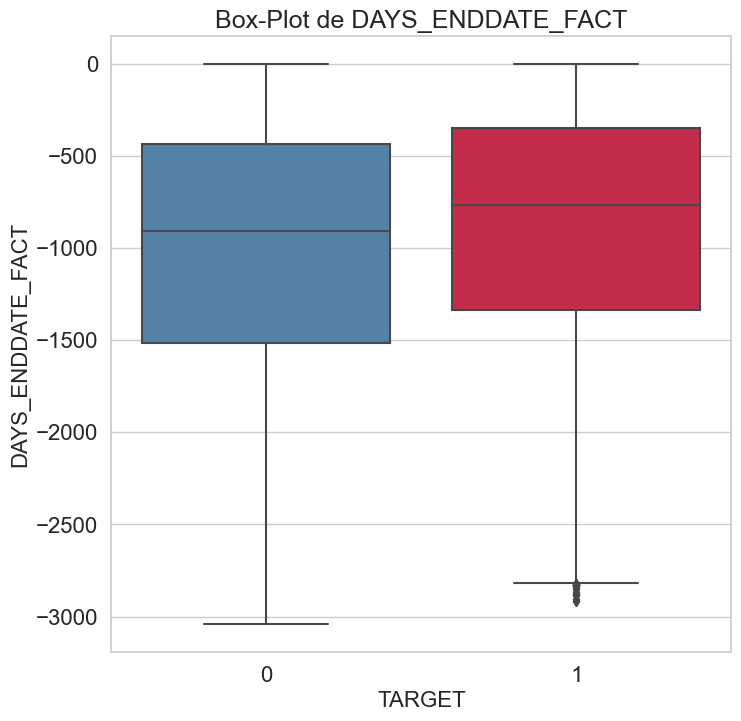

----------------------------------------------------------------------------------------------------


In [38]:
print_percentiles(bureau_merged, 'DAYS_ENDDATE_FACT',
                  percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots=[
                          'box'], figsize=(8, 8), scale_limits=[-40000, 0])
print('-'*100)

- **Observations et conclusions :**




- Comme pour la colonne précédente, nous constatons que le 0ème percentile de cette colonne semble également erroné, qui est de 42023 jours ou ~115 ans. Il faudrait supprimer ces valeurs, car elles n'ont pas beaucoup de sens.
- En regardant le box-plot, on constate que les défaillants ont tendance à avoir moins de jours depuis la fin de leur crédit auprès du bureau de crédit. Les non défaillants ont généralement vu leurs crédits précédents se terminer plus longtemps avant que les défaillants.

**DAYS_CREDIT_UPDATE**


Cette colonne indique le nombre de jours écoulés depuis que les informations du bureau de crédit sont arrivées au moment de la demande de prêt au Crédit immobilier.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_CREDIT_UPDATE
Pecentile 0 = -41947.0
Pecentile 2 = -2415.0
Pecentile 4 = -2213.0
Pecentile 6 = -2002.0
Pecentile 8 = -1766.0
Pecentile 10 = -1582.0
Pecentile 25 = -904.0
Pecentile 50 = -406.0
Pecentile 75 = -33.0
Pecentile 100 = 372.0
-------------------------------------------------------------------------------


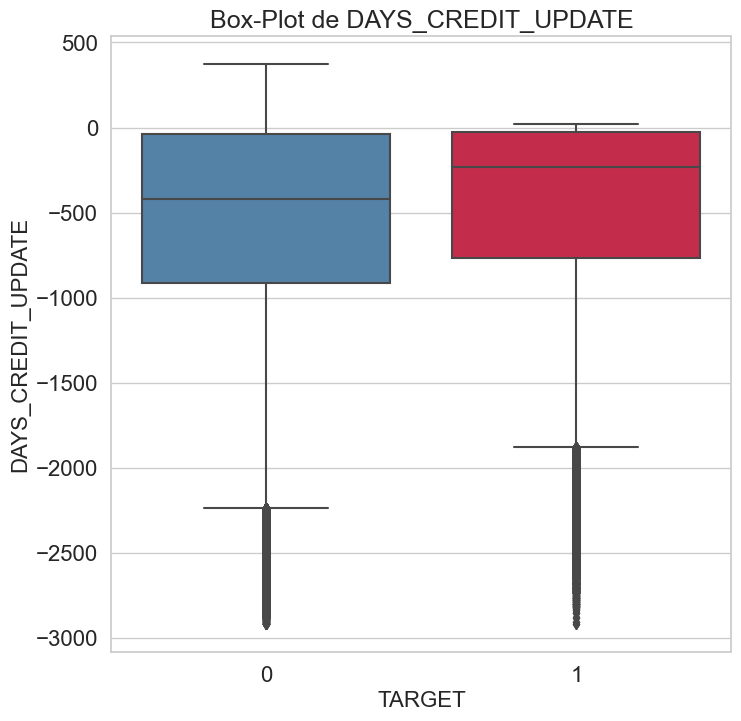

----------------------------------------------------------------------------------------------------


In [39]:
print_percentiles(bureau_merged, 'DAYS_CREDIT_UPDATE',
                  percentiles=list(range(0, 11, 2)) + [25, 50, 75, 100])
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_UPDATE', plots=[
                          'box'], figsize=(8, 8), scale_limits=[-40000, 400])
print('-'*100)

**Observations et conclusions**:
- La tendance des valeurs erronées est à nouveau très similaire à la colonne des autres jours où cette valeur du 0e percentile semble être erronée. De plus, comme seule la valeur du 0e percentile est si étrange, et que le reste semble correct, cette valeur est définitivement erronée. Nous allons également supprimer cette valeur.
- D'après la représentation graphique, nous pouvons dire que les défaillants ont tendance à avoir un nombre de jours inférieur depuis la réception de leurs informations sur le crédit du bureau de crédit. Leurs valeurs médianes, au 75e centile, sont toutes inférieures à celles des non défaillants.

# bureau_balance

Données mensuelles sur les crédits antérieurs de bureau. Chaque ligne correspond à un mois d'un crédit antérieur et un crédit antérieur peut avoir plusieurs lignes de données mensuelles, une pour chaque mois de la durée du crédit. Le jeu bureau_balance comprend donc la variable SK_ID_BUREAU (clé secondaire) pour faire le lien avec le jeu de données bureau.

In [40]:
#la structure des dataframes
data_structure(bureau_balance)

Caractéristiques   Valeurs
0                   Nombre de lignes  27299925
1                 Nombre de colonnes         3
2  Nombre de variables catégorielles         1
3    Nombre de variables numériques          2
4  Pourcentage de données manquantes         0
5                 Nombre de doublons         0

In [41]:
# description des variables qualitatives/quantitatives
desc_var(bureau_balance, type_var='all')

SK_ID_BUREAU MONTHS_BALANCE    STATUS
type           float64        float64    object
nb_nan             0.0            0.0       0.0
%_nan              0.0            0.0       0.0
count       27299925.0     27299925.0  27299925
unique             NaN            NaN         8
top                NaN            NaN         C
freq               NaN            NaN  13646993
mean    6036297.332974     -30.741687       NaN
std      492348.856904      23.864509       NaN
min          5001709.0          -96.0       NaN
25%          5730933.0          -46.0       NaN
50%          6070821.0          -25.0       NaN
75%          6431951.0          -11.0       NaN
max          6842888.0            0.0       NaN

- **Distribution des Variable **

In [42]:
print('-'*100)
print(
    f'Number of unique values for STATUS are: {len(bureau_balance.STATUS.unique())}')
print(f"Unique values of STATUS are:\n{bureau_balance.STATUS.unique()}")
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique values for STATUS are: 8
Unique values of STATUS are:
['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------


- **Observations et conclusions**



- Le tableau bureau_balance contient environ 27,29M lignes, et 3 colonnes.
- Ce tableau contient le statut mensuel de chacun des prêts précédents pour un demandeur particulier déclarés par le département du bureau de crédit.
- Il y a 8 valeurs uniques pour le STATUT qui sont encodées. Chacune d'entre elles a une signification particulière. C signifie fermé, X signifie statut inconnu, 0 signifie pas de DPD, 1 signifie maximum fait pendant le mois entre 1-30, 2 signifie DPD 31-60,... 5 signifie DPD 120+ ou vendu ou amorti.
- Le solde du mois le plus ancien que nous avons est le statut de 96 mois en arrière, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels ils existent.
- Le tableau bureau_balance ne contient pas des valeurs manquantes 

# credit_card_balance

Données mensuelles sur les précédentes cartes de crédit liées aux précédentes demandes de crédit. Chaque ligne correspond à un mois de solde de carte de crédit et est liée à une précédente demande de crédit, identifiée par la variable **SK_ID_PREV** (clé secondaire).

In [43]:
#la structure des dataframes
data_structure(credit_card_balance)

Caractéristiques  Valeurs
0                   Nombre de lignes  3840312
1                 Nombre de colonnes       23
2  Nombre de variables catégorielles        1
3    Nombre de variables numériques        22
4  Pourcentage de données manquantes      153
5                 Nombre de doublons        0

In [44]:
# description des variables qualitatives/quantitatives
desc_var(credit_card_balance, type_var='all')

SK_ID_PREV     SK_ID_CURR MONTHS_BALANCE    AMT_BALANCE  \
type          float64        float64        float64        float64   
nb_nan            0.0            0.0            0.0            0.0   
%_nan             0.0            0.0            0.0            0.0   
count       3840312.0      3840312.0      3840312.0      3840312.0   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean     1904503.5899  278324.207289     -34.521921   58300.155262   
std     536469.470563  102704.475133      26.667751  106307.031025   
min         1000018.0       100006.0          -96.0    -420250.185   
25%         1434385.0       189517.0          -55.0            0.0   
50%         1897122.0       278396.0          -28.0            0.0   
75%        2369327.75       367580.0          -11.0    89046.68625   
max         2843496.0       456250.0           -1.0    1505902.185   

       AMT_CREDIT_LIMIT_ACTUAL AMT_DRAWINGS_ATM_CURRENT AMT_DRAWINGS_CURRENT  \
type                   float64                  float64              float64   
nb_nan                     0.0                 749816.0                  0.0   
%_nan                      0.0                19.524872                  0.0   
count                3840312.0                3090496.0            3840312.0   
unique                     NaN                      NaN                  NaN   
top                        NaN                      NaN                  NaN   
freq                       NaN                      NaN                  NaN   
mean               153807.9574              5961.324822          7433.388179   
std              165145.699523             28225.688579         33846.077334   
min                        0.0                 -6827.31             -6211.62   
25%                    45000.0                      0.0                  0.0   
50%                   112500.0                      0.0                  0.0   
75%                   180000.0                      0.0                  0.0   
max                  1350000.0                2115000.0          2287098.315   

       AMT_DRAWINGS_OTHER_CURRENT AMT_DRAWINGS_POS_CURRENT  \
type                      float64                  float64   
nb_nan                   749816.0                 749816.0   
%_nan                   19.524872                19.524872   
count                   3090496.0                3090496.0   
unique                        NaN                      NaN   
top                           NaN                      NaN   
freq                          NaN                      NaN   
mean                   288.169582              2968.804848   
std                   8201.989345             20796.887047   
min                           0.0                      0.0   
25%                           0.0                      0.0   
50%                           0.0                      0.0   
75%                           0.0                      0.0   
max                     1529847.0               2239274.16   

       AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE AMT_TOTAL_RECEIVABLE  \
type                   float64  ...        float64              float64   
nb_nan                305236.0  ...            0.0                  0.0   
%_nan                 7.948208  ...            0.0                  0.0   
count                3535076.0  ...      3840312.0            3840312.0   
unique                     NaN  ...            NaN                  NaN   
top                        NaN  ...            NaN                  NaN   
freq                       NaN  ...            NaN                  NaN   
mean               3540.204129  ...   58088.811177         58098.285489   
std                5600.154122  ...  105965.369908        105971.801103   
min                        0.0  ...    -420250.185          -420250.185   
25%

In [45]:
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in credit_card_balance.csv are: {len(credit_card_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in credit_card_balance.csv are: 104307
Number of unique SK_ID_CURR in credit_card_balance.csv are: 103558
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and credit_card_balance.csv are: 86905
Number of overlapping SK_ID_CURR in application_test.csv and credit_card_balance.csv are: 16653
----------------------------------------------------------------------------------------------------


- **Observations et conclusions**


- Il y a environ 3,84M lignes dans le tableau credit_card_balance.csv, chacune d'entre elles correspondant au statut mensuel de la carte de crédit que le demandeur avait auprès de Home Credit Group. Ce tableau contient 23 caractéristiques qui contiennent les statistiques sur le statut mensuel de la carte de crédit, telles que le montant du solde, le montant des tirages, le nombre de tirages, le statut, etc. De ces 104,3k, il y a 103,5k SK_ID_CURR unique. Cela signifie que la plupart des demandeurs n'avaient qu'une seule carte de crédit sur eux, et que peu d'entre eux en avaient plus d'une. Ces SK_ID_CURR sont les identifiants des demandeurs qui ont actuellement demandé un prêt.
- Sur les 103k de SK_ID_CURR unique, 86,9k de ces candidats appartiennent à l'ensemble de formation, et 16,6k à l'ensemble d'application test.
- Sur les 307k de demandeurs dans le tableau application_train, seuls 86,9k d'entre eux avaient une carte de crédit auparavant auprès de Home Credit Group.
- Sur les 23 caractéristiques, 9 d'entre elles contiennent des valeurs de NaN.
- 7 de ces caractéristiques ont des valeurs proches de 20 % de NaN. Ces caractéristiques sont principalement liées aux montants des tirages et aux nombres de tirages. Deux autres de ces caractéristiques sont liées aux statistiques sur les versements.

**Merging the TARGETS from application_train to credit_card_balance table**


In [46]:

print("-"*100)
print("Merging TARGET with credit_card_balance Table")
credit_card_balance_merged = application_train.iloc[:, :2].merge(
    credit_card_balance, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


### Matrice de corrélation 

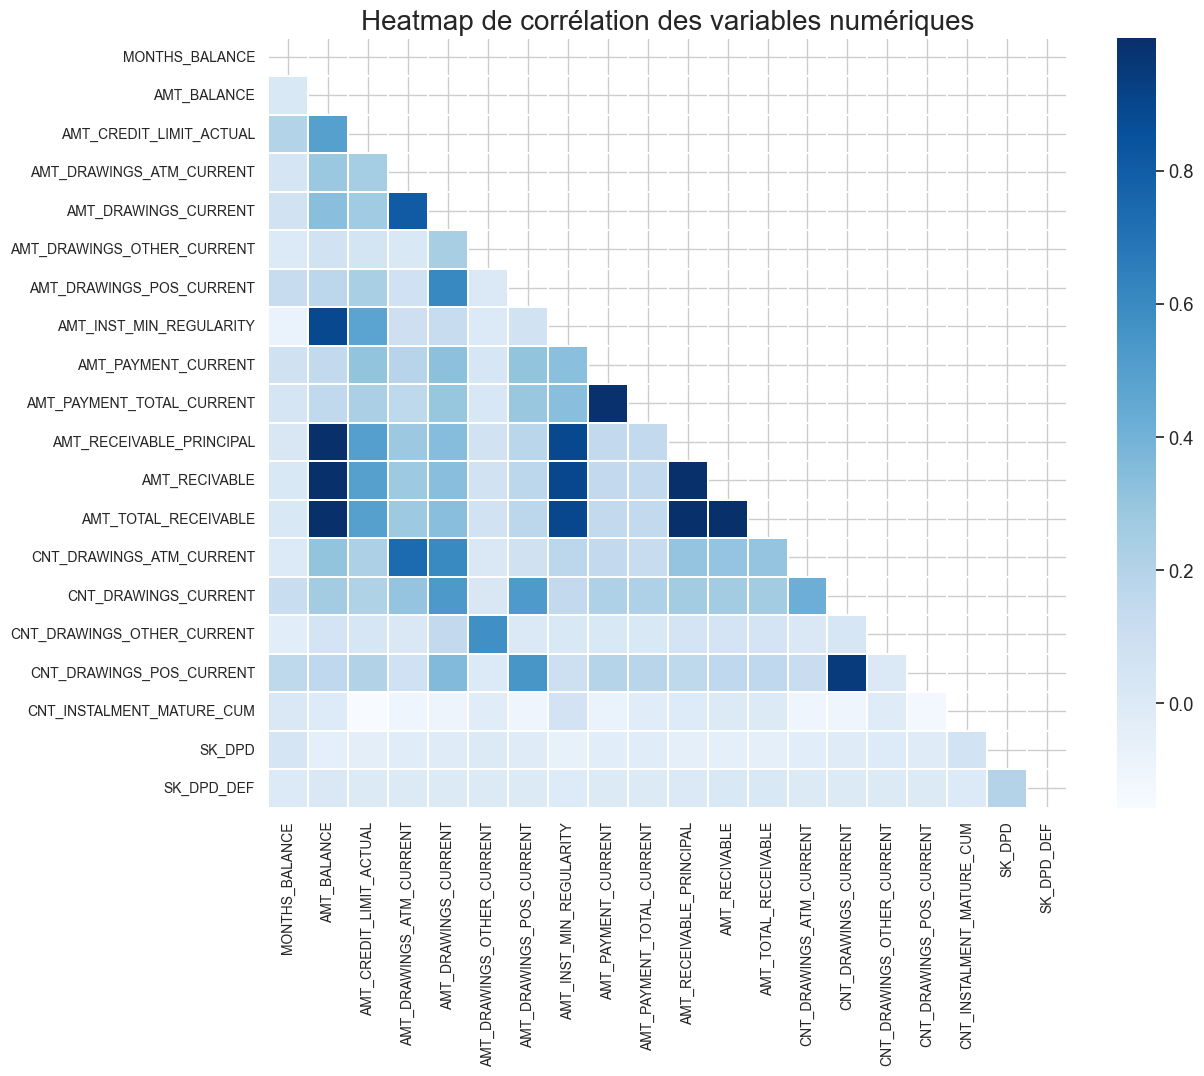

In [47]:
corr_mat = correlation_matrix(
    credit_card_balance_merged, ['SK_ID_CURR', 'SK_ID_PREV'], figsize=(13, 11))
corr_mat.plot_correlation_matrix()

- **Observations et conclusions :**
1. La carte de chaleur ci-dessus montre visuellement la corrélation entre les caractéristiques du tableau "solde de la carte de crédit".
2.De la carte thermique de la matrice de corrélation, nous voyons quelques couples de caractéristiques fortement corrélées. Ce sont :
  - AMT_RECEIVABLE_PRINCIPE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE
  - Nous observons également une forte corrélation entre ces 3 colonnes AMT_RECEIVABLE
  - AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT
3. Les ensembles de 2ème et 3ème éléments corrélés sont compréhensibles car ils correspondent plus ou moins au même récit.
4. La corrélation des caractéristiques avec la variable Target n'est pas perceptible, ce qui montre l'absence de relation linéaire entre la caractéristique et la variable Target.

### Distribution des Variables 

Tout d'abord, nous allons regrouper par le champ **"SK_ID_PREV"** et agréger avec la moyenne, de façon à obtenir une ligne moyenne pour chacun des prêts précédents que le client a obtenus.

In [48]:

cc_balance_merged =credit_card_balance_merged.groupby('SK_ID_PREV').mean()

- **Distribution de l'AMT_BALANCE**

Cette colonne indiquait le montant moyen du solde qu'une personne avait habituellement sur son compte de prêt de carte de crédit pour un prêt précédent

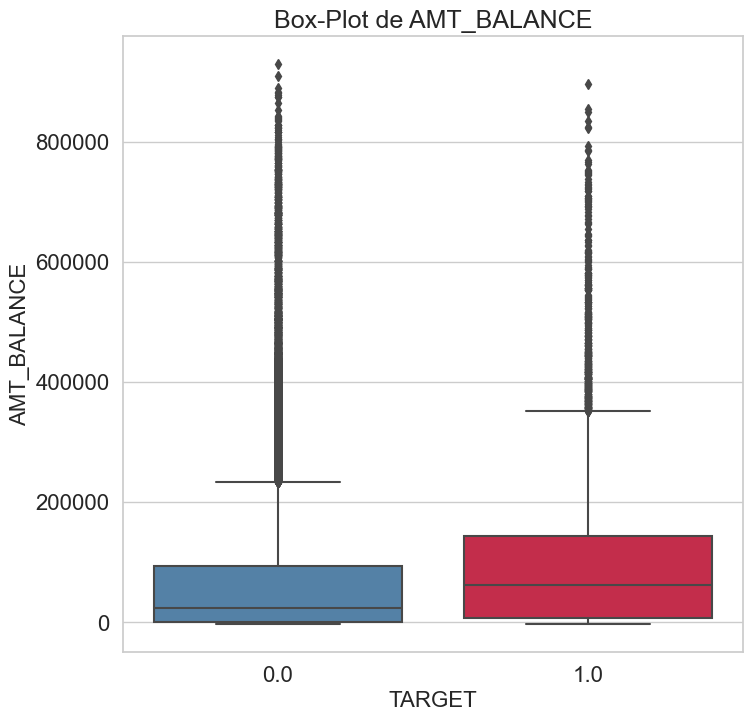

In [49]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots=[
                          'box'], figsize=(8, 8))

- **Observations et conclusions**
1. Sur le graphique ci-dessus, on peut voir que les défaillants ont une valeur de AMT_BALANCE plus élevée que les non défaillants. Ils affichent des valeurs plus élevées pour tous les quantiles et même pour les moustaches. Cela pourrait signifier que le montant du crédit pour les défaillants pourrait également être relativement plus élevé par rapport aux non défaillants.


2. Nous constatons que les défaillants semblent ici aussi avoir un versement minimum plus élevé chaque mois par rapport aux non défaillants. Cela renseigne généralement sur les habitudes de dépense et d'emprunt des personnes. Les défaillants ont des habitudes de dépenses et d'emprunt plus élevées que les non défaillants.

- **Distribution de l' Distribution des AMT_TOTAL_RECEIVABLE** 


Cette colonne décrit la moyenne du montant total à recevoir sur le crédit précédent.

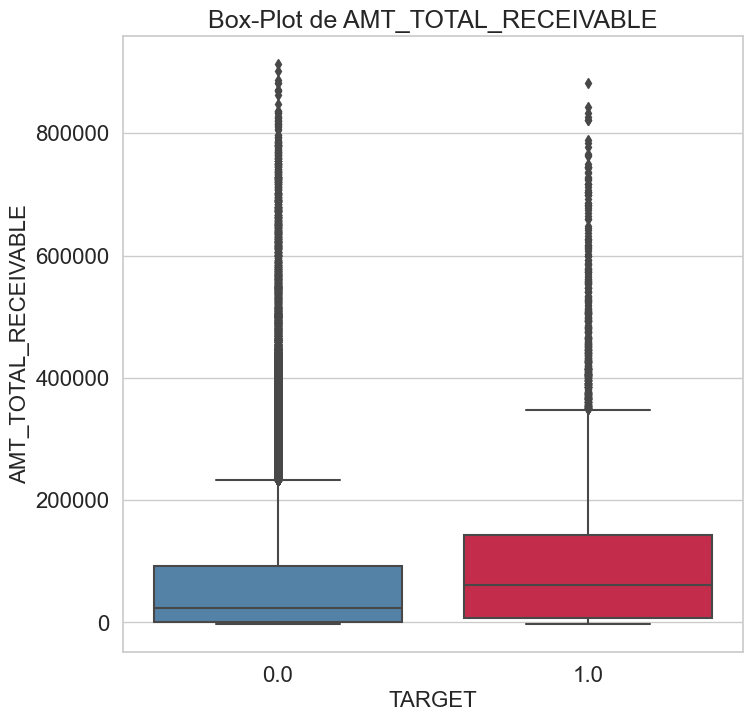

In [50]:
plot_continuous_variables(cc_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots=[
                          'box'], figsize=(8, 8))

- **Observations et conclusions**


Si l'on examine le box plot de AMT_TOTAL_RECEIVABLE, on constate un comportement similaire à celui observé avec d'autres montants, à savoir que les défaillants avaient généralement un montant à recevoir plus élevé sur leur crédit précédent, ce qui peut impliquer les montants de crédits plus élevés qu'ils ont pu prendre. Le PDF montre également un pic très élevé à des montants plus faibles pour les non défaillants par rapport aux défaillants.

- **Distribution des CNT_INSTALMENT_MATURE_CUM en continu**


La colonne décrit à peu près le nombre moyen de versements effectués sur les crédits précédents

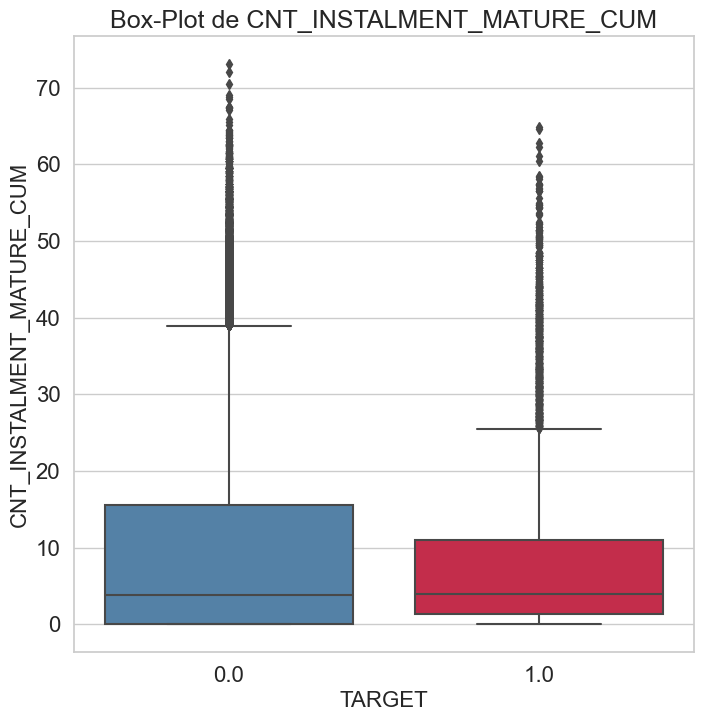

In [51]:
plot_continuous_variables(
    cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots=['box'], figsize=(8, 8))

- **Observations et conclusions**


Du graphique ci-dessus, nous voyons un comportement très intéressant. Ce graphique montre que les non défaillants ont généralement une fourchette de valeurs plus élevée pour le nombre de versements payés que les défaillants. Cela pourrait indiquer le comportement des défaillants, qui, en règle générale, paient moins de versements sur leur crédit précédent.

# installments_payments

Historique des paiements pour les précédentes demandes de crédit. Les lignes contiennent les informations relatives aux paiements effectués et aux paiements manqués.

In [53]:
#la structure des dataframes
data_structure(installments_payments)

Caractéristiques   Valeurs
0                   Nombre de lignes  13605401
1                 Nombre de colonnes         8
2  Nombre de variables catégorielles         0
3    Nombre de variables numériques          8
4  Pourcentage de données manquantes         0
5                 Nombre de doublons         0

In [54]:
# description des variables qualitatives/quantitatives
desc_var(installments_payments, type_var='all')

SK_ID_PREV     SK_ID_CURR NUM_INSTALMENT_VERSION  \
type           float64        float64                float64   
nb_nan             0.0            0.0                    0.0   
%_nan              0.0            0.0                    0.0   
count       13605401.0     13605401.0             13605401.0   
mean    1903364.969549  278444.881738               0.856637   
std      536202.905546  102718.310411               1.035216   
min          1000001.0       100001.0                    0.0   
25%          1434191.0       189639.0                    0.0   
50%          1896520.0       278685.0                    1.0   
75%          2369094.0       367530.0                    1.0   
max          2843499.0       456255.0                  178.0   

       NUM_INSTALMENT_NUMBER DAYS_INSTALMENT DAYS_ENTRY_PAYMENT  \
type                 float64         float64            float64   
nb_nan                   0.0             0.0             2905.0   
%_nan                    0.0             0.0           0.021352   
count             13605401.0      13605401.0         13602496.0   
mean               18.870896    -1042.269992       -1051.113684   
std                26.664067      800.946284         800.585883   
min                      1.0         -2922.0            -4921.0   
25%                      4.0         -1654.0            -1662.0   
50%                      8.0          -818.0             -827.0   
75%                     19.0          -361.0             -370.0   
max                    277.0            -1.0               -1.0   

       AMT_INSTALMENT   AMT_PAYMENT  
type          float64       float64  
nb_nan            0.0        2905.0  
%_nan             0.0      0.021352  
count      13605401.0    13602496.0  
mean     17050.906989   17238.22325  
std      50570.254429  54735.783981  
min               0.0           0.0  
25%          4226.085      3398.265  
50%           8884.08      8125.515  
75%          16710.21     16108.425  
max       3771487.845   3771487.845

In [55]:
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(installments_payments.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in installments_payments.csv are: 997752
Number of unique SK_ID_CURR in installments_payments.csv are: 339587
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 291643
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 47944
----------------------------------------------------------------------------------------------------


- **Observations et conclusions**
1. Il y a environ 13,6 millions de points de données dans le tableau installments_payments.csv. Chaque ligne représente l'historique de chaque versement lié à un prêt particulier que le client avait précédemment contracté auprès de Home Credit Group.
2. Il y a 997k de prêts antérieurs uniques dans les versements. Ils appartiennent à 339 000 SK_ID_CURR uniques, qui sont les identifiants des demandeurs du prêt actuel.
3. De ces 339k SK_ID_CURR, 291k appartiennent à l'ensemble de données de formation, et 47,9k à l'ensemble de données de test. Cela signifie que presque sur les 307k SK_ID_CURR uniques dans application_train, 291k avaient auparavant une forme de prêt avec Home Credit. De même, sur les 48,7 k de l'ensemble de données de test, 47,9 k avaient déjà bénéficié d'un prêt avec le Crédit immobilier.
4. Le tableau comporte 8 caractéristiques uniques, dont 6 décrivent les statistiques de chaque versement pour le prêt précédent.
5. Il n'y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de installments_payments.
6. Ces colonnes contiennent également une proportion très minime de valeurs de NaN, à savoir seulement 0,02%, ce qui n'est pas très préoccupant.

- **Merging the TARGETS from application_train to installments_payments table**


In [56]:
#Merging the TARGETS from application_train to installments_payments table

print("-"*100)
print("Merging TARGET with installments_payments Table")
installments_merged = application_train.iloc[:, :2].merge(
    installments_payments, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with installments_payments Table
----------------------------------------------------------------------------------------------------


### Matrice de corrélation 

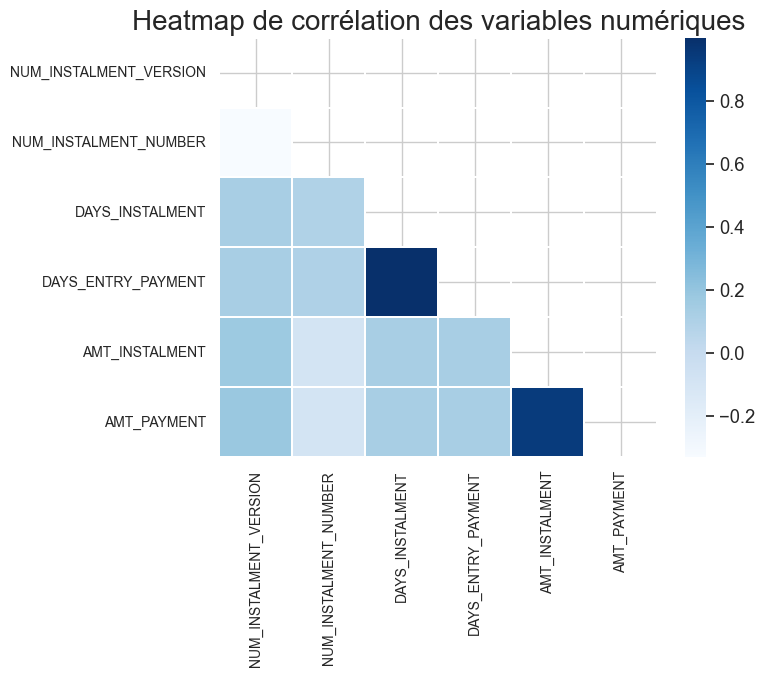

In [57]:
corr_mat = correlation_matrix(
    installments_merged, ['SK_ID_CURR', 'SK_ID_PREV'], figsize=(8, 7))
corr_mat.plot_correlation_matrix()

- **Observations et conclusions :**


 De la carte thermique de la matrice de corrélation, nous voyons quelques caractéristiques fortement corrélées. Ce sont :
 
     -  AMT_INSTALMENT and AMT_PAYMENT
     -  DAYS_INSTALMENT and DAYS_ENTRY_PAYMENT
1. Ces deux ensembles de caractéristiques corrélées sont compréhensibles, car il s'agit en fait des caractéristiques relatives à la date à laquelle le versement devait être effectué par rapport à la date à laquelle il a été effectué, ainsi que du montant dû par rapport au montant payé.
2. Ces caractéristiques seront utiles pour créer de nouveaux ensembles de caractéristiques totalement non corrélées.
3. La corrélation des caractéristiques avec la variable Target n'est pas perceptible, ce qui montre l'absence de relation linéaire entre la caractéristique et la variable Target.

### Distribution des Variables 

Tout d'abord, nous allons regrouper par le champ **"SK_ID_PREV"** et agréger avec la moyenne, de façon à obtenir une ligne moyenne pour chacun des prêts précédents que le client a obtenus.

In [58]:

installments_merged = installments_merged.groupby('SK_ID_PREV').mean()

- **Distribution of Continuous Vairable DAYS_INSTALMENT**


Cette colonne indique les jours où le versement du crédit précédent devait être payé.

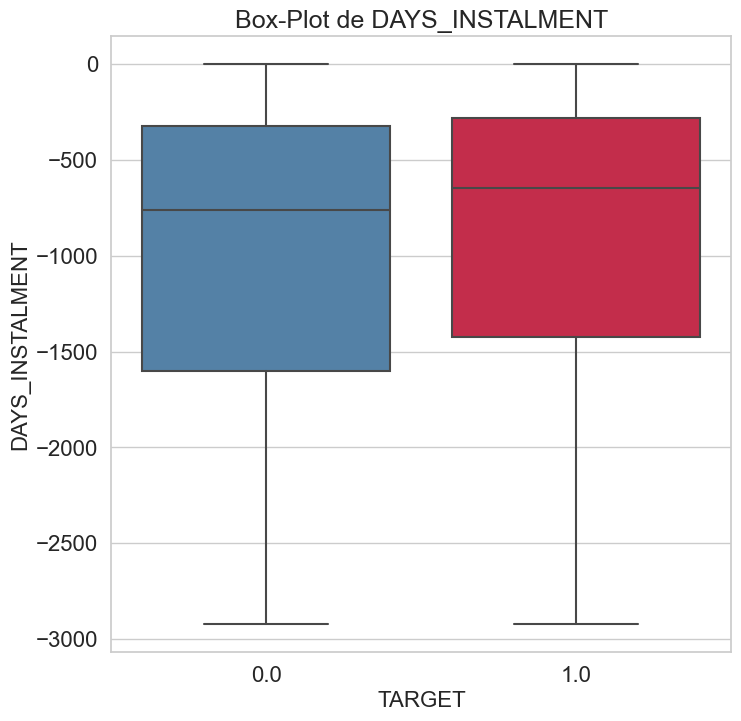

In [59]:

plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots=[
                          'box'], figsize=(8, 8))

- **Distribution of Continuous Vairable DAYS_ENTRY_PAYMENT**


Cette colonne indique les jours où le versement du crédit précédent a été effectivement payé.

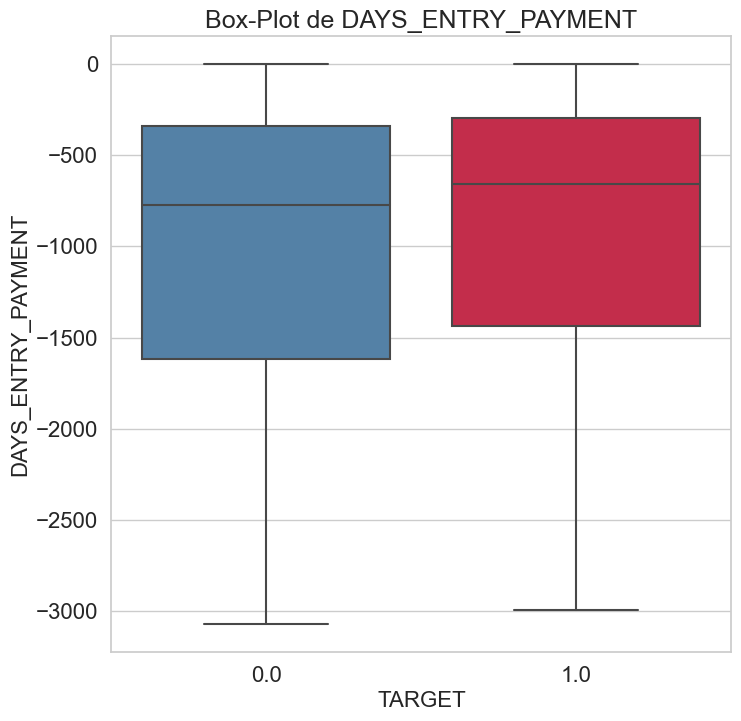

In [60]:
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots=[
                          'box'], figsize=(8, 8))
del installments_merged

- **Observations et conclusions**


Les deux graphiques ci-dessus montrent une tendance similaire, à savoir que les défaillants ont tendance à avoir moins de jours depuis leur dernier paiement, tandis que les non défaillants ont plus de jours depuis leur dernier paiement. Tous les quantiles des défaillants ont plus de jours récents que ceux des non défaillants. Ainsi, les non défaillants ont généralement plus d'écart dans leurs paiements depuis le jour de la demande que les défaillants.

# POS_CASH_balance

Données mensuelles de prêts en espèces relatives aux précédentes demandes de crédits. Chaque ligne correspond à une précédente demande de crédit, identifiée par la variable **SK_ID_PREV** (clé secondaire).

In [61]:
#la structure des dataframes
data_structure(POS_CASH_balance)

Caractéristiques   Valeurs
0                   Nombre de lignes  10001358
1                 Nombre de colonnes         8
2  Nombre de variables catégorielles         1
3    Nombre de variables numériques          7
4  Pourcentage de données manquantes         0
5                 Nombre de doublons         0

In [62]:
# description des variables qualitatives/quantitatives
desc_var(POS_CASH_balance, type_var='all')

SK_ID_PREV     SK_ID_CURR MONTHS_BALANCE CNT_INSTALMENT  \
type           float64        float64        float64        float64   
nb_nan             0.0            0.0            0.0        26071.0   
%_nan              0.0            0.0            0.0       0.260675   
count       10001358.0     10001358.0     10001358.0      9975287.0   
unique             NaN            NaN            NaN            NaN   
top                NaN            NaN            NaN            NaN   
freq               NaN            NaN            NaN            NaN   
mean    1903216.598957  278403.863306     -35.012588       17.08965   
std      535846.530722   102763.74509       26.06657      11.995056   
min          1000001.0       100001.0          -96.0            1.0   
25%          1434405.0       189550.0          -54.0           10.0   
50%          1896565.0       278654.0          -28.0           12.0   
75%          2368963.0       367429.0          -13.0           24.0   
max          2843499.0       456255.0           -1.0           92.0   

       CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS      SK_DPD  SK_DPD_DEF  
type                 float64               object     float64     float64  
nb_nan               26087.0                  0.0         0.0         0.0  
%_nan               0.260835                  0.0         0.0         0.0  
count              9975271.0             10001358  10001358.0  10001358.0  
unique                   NaN                    9         NaN         NaN  
top                      NaN               Active         NaN         NaN  
freq                     NaN              9151119         NaN         NaN  
mean                10.48384                  NaN   11.606928    0.654468  
std                11.109058                  NaN  132.714043   32.762491  
min                      0.0                  NaN         0.0         0.0  
25%                      3.0                  NaN         0.0         0.0  
50%                      7.0                  NaN         0.0         0.0  
75%                     14.0                  NaN         0.0         0.0  
max                     85.0                  NaN      4231.0      3595.0

In [63]:
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in POS_CASH_balance.csv are: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in POS_CASH_balance.csv are: 936325
Number of unique SK_ID_CURR in POS_CASH_balance.csv are: 337252
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and POS_CASH_balance.csv are: 289444
Number of overlapping SK_ID_CURR in application_test.csv and POS_CASH_balance.csv are: 47808
----------------------------------------------------------------------------------------------------


- **Observations et conclusions**
1. Ce tableau contient environ 10M points de données, où chaque ligne correspond à l'instantané mensuel de l'état du précédent point de vente et du prêt en espèces que le client a eu avec Home Credit Group. Il se compose de 8 colonnes, dont deux sont SK_ID_CURR et SK_ID_PREV.
2. Il y a 936k d'identifiants uniques de prêts précédents dans le tableau, qui correspondent à 337k de demandeurs actuels uniques (SK_ID_CURR).
3. De ces 337k SK_ID_CURR, 289k appartiennent à l'ensemble de formation et 47,8k à l'ensemble de test.
4. Il n'y a que 2 colonnes qui contiennent les valeurs NaN des 8 colonnes de POS_CASH_balance. Ces colonnes sont le décompte des versements restants et la durée du prêt.
5. Ces colonnes contiennent également une proportion très minime de valeurs de NaN, à savoir seulement 0,26%%, ce qui n'est pas non plus très préoccupant.

- **Merging the TARGETS from application_train to POS_CASH_balance tables**


In [64]:
#Merging the TARGETS from application_train to POS_CASH_balance tables
print("-"*100)
print("Merging TARGET with POS_CASH_balance Table")
pos_cash_merged = application_train.iloc[:, :2].merge(
    POS_CASH_balance, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with POS_CASH_balance Table
----------------------------------------------------------------------------------------------------


### Matrice de corrélation 

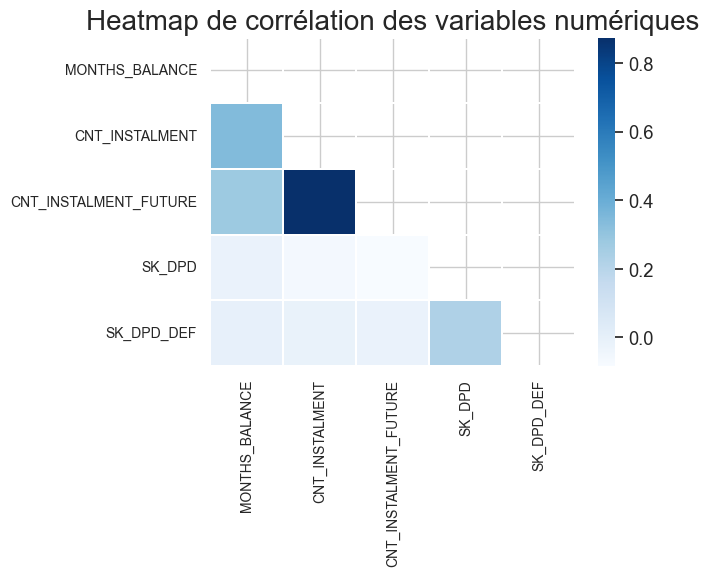

In [65]:
corr_mat = correlation_matrix(
    pos_cash_merged, ['SK_ID_CURR', 'SK_ID_PREV'], figsize=(7, 6))
corr_mat.plot_correlation_matrix()

### Distribution des Variables 

Tout d'abord, nous allons regrouper par le champ **"SK_ID_PREV"** et agréger avec la moyenne, de façon à obtenir une ligne moyenne pour chacun des prêts précédents que le client a obtenus.

In [66]:

pos_cash_merged = pos_cash_merged.groupby('SK_ID_PREV').mean()

- **Distribution de CNT_INSTALMENT_FUTUR en continu** 



Cette colonne décrit le nombre de versements qu'il reste à payer sur le crédit précédent.

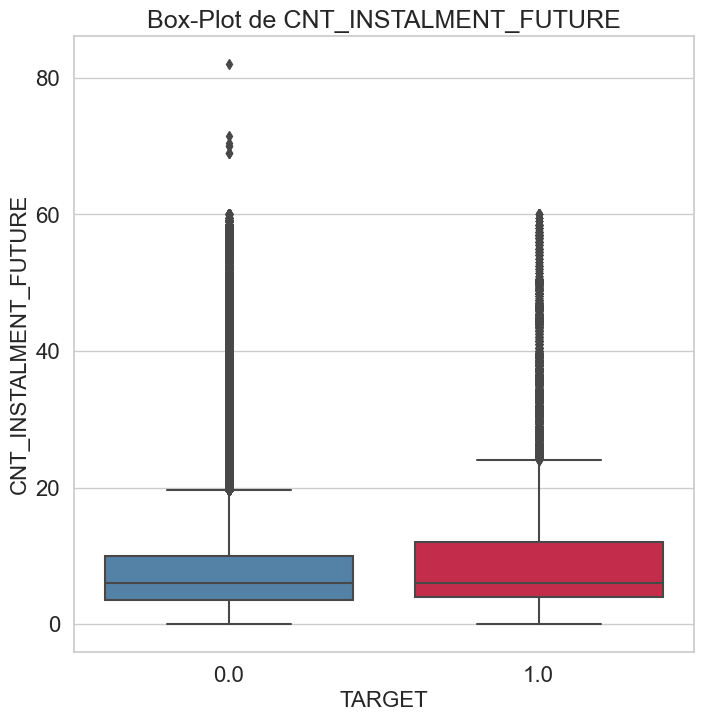

In [67]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots=[
                          'box'], figsize=(8, 8))
del pos_cash_merged

- **Observations et conclusions**



Si l'on examine le graphique ci-dessus pour CNT_INSTALMENT_FUTURE, on constate que les valeurs du percentile > 50 % pour les défaillants sont généralement plus élevées que celles des non défaillants. Même la limite supérieure de la moustache pour les défaillants est plus élevée que celle des non défaillants. Cela suggère que les défaillants ont tendance à avoir un plus grand nombre de versements restant sur leurs crédits précédents que les non défaillants.

# previous_application

Précédentes demandes de crédit. Chaque ligne concerne une précédente demande de crédit identifiée par la variable **SK_ID_PREV** (clé primaire). Chaque crédit en cours (application_train) peut être lié à plusieurs crédits précédents. Le jeu previous_application comprend donc la variable **SK_ID_CURR** (clé secondaire) pour faire le lien avec le jeu de données application_train.

In [68]:
#la structure des dataframes
data_structure(previous_application)

Caractéristiques  Valeurs
0                   Nombre de lignes  1670214
1                 Nombre de colonnes       37
2  Nombre de variables catégorielles       16
3    Nombre de variables numériques        21
4  Pourcentage de données manquantes      665
5                 Nombre de doublons        0

Valeurs manquantes :11109336 NaN pour 61797918 données (17.98 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
RATE_INTEREST_PRIMARY                            1664263   
RATE_INTEREST_PRIVILEGED                         1664263   
AMT_DOWN_PAYMENT                                  895844   
RATE_DOWN_PAYMENT                                 895844   
NAME_TYPE_SUITE                                   820405   
DAYS_FIRST_DRAWING                                673065   
DAYS_FIRST_DUE                                    673065   
DAYS_LAST_DUE_1ST_VERSION                         673065   
DAYS_LAST_DUE                                     673065   
DAYS_TERMINATION                                  673065   
NFLAG_INSURED_ON_APPROVAL                         673065   
AMT_GOODS_PRICE                                   385515   
AMT_ANNUITY                                       372235   
CNT_PAYMENT                                       372230   
PRODUCT_COMBINATION                                  346   
AMT_CREDIT                                             1   

                           % de valeurs manquantes  
RATE_INTEREST_PRIMARY                        99.64  
RATE_INTEREST_PRIVILEGED                     99.64  
AMT_DOWN_PAYMENT                             53.64  
RATE_DOWN_PAYMENT                            53.64  
NAME_TYPE_SUITE                              49.12  
DAYS_FIRST_DRAWING                           40.30  
DAYS_FIRST_DUE                               40.30  
DAYS_LAST_DUE_1ST_VERSION                    40.30  
DAYS_LAST_DUE                                40.30  
DAYS_TERMINATION                             40.30  
NFLAG_INSURED_ON_APPROVAL                    40.30  
AMT_GOODS_PRICE                              23.08  
AMT_ANNUITY                                  22.29  
CNT_PAYMENT                                  22.29  
PRODUCT_COMBINATION                           0.02  
AMT_CREDIT                                    0.00

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


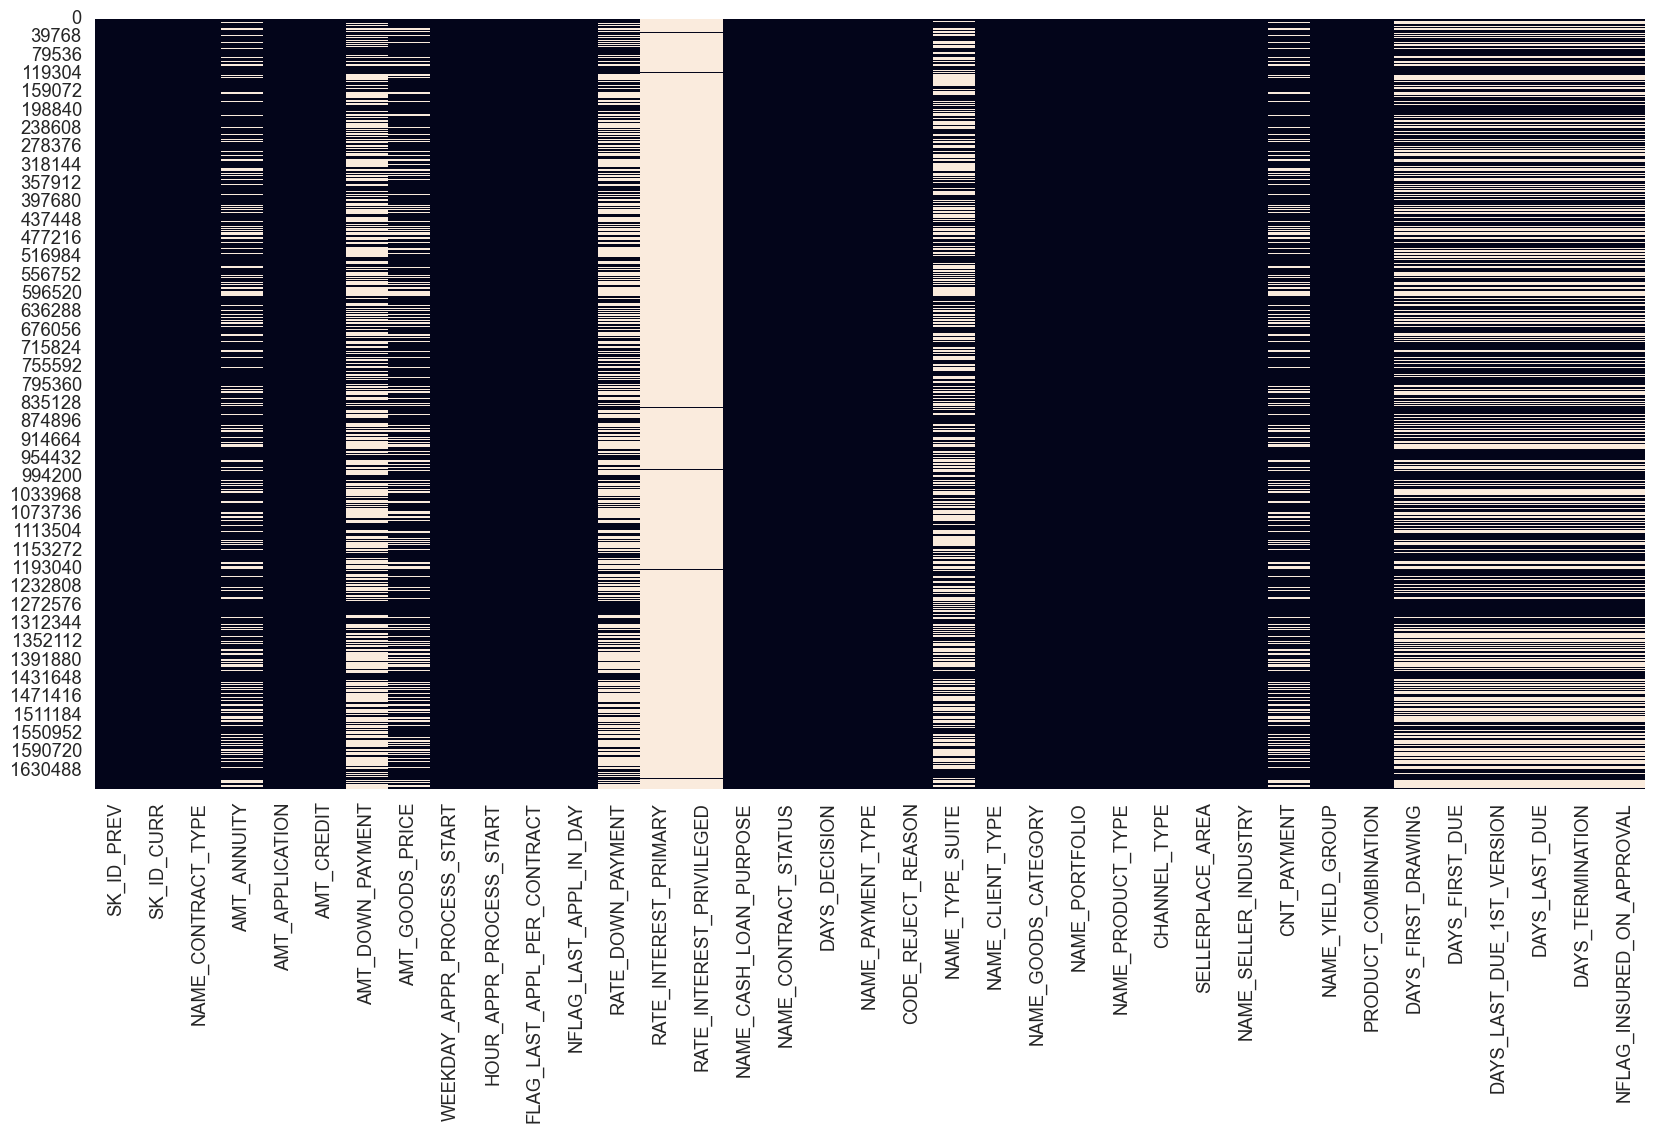

In [69]:
#afficher le pourcentage des valeurs nulls et les visualiser 
valeur_null(previous_application, True,True)

In [70]:
# description des variables qualitatives/quantitatives
desc_var(previous_application, type_var='all')

SK_ID_PREV     SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  \
type           float64        float64             object       float64   
nb_nan             0.0            0.0                0.0      372235.0   
%_nan              0.0            0.0                0.0     22.286665   
count        1670214.0      1670214.0            1670214     1297979.0   
unique             NaN            NaN                  4           NaN   
top                NaN            NaN         Cash loans           NaN   
freq               NaN            NaN             747553           NaN   
mean    1923089.135331  278357.174099                NaN  15955.120659   
std      532597.958696  102814.823849                NaN  14782.137335   
min          1000001.0       100001.0                NaN           0.0   
25%         1461857.25       189329.0                NaN       6321.78   
50%          1923110.5       278714.5                NaN       11250.0   
75%         2384279.75       367514.0                NaN      20658.42   
max          2845382.0       456255.0                NaN    418058.145   

       AMT_APPLICATION     AMT_CREDIT AMT_DOWN_PAYMENT AMT_GOODS_PRICE  \
type           float64        float64          float64         float64   
nb_nan             0.0            1.0         895844.0        385515.0   
%_nan              0.0        0.00006         53.63648       23.081773   
count        1670214.0      1670213.0         774370.0       1284699.0   
unique             NaN            NaN              NaN             NaN   
top                NaN            NaN              NaN             NaN   
freq               NaN            NaN              NaN             NaN   
mean      175233.86036  196114.021218      6697.402139   227847.279283   
std      292779.762387  318574.616546      20921.49541   315396.557937   
min                0.0            0.0             -0.9             0.0   
25%            18720.0        24160.5              0.0         50841.0   
50%            71046.0        80541.0           1638.0        112320.0   
75%           180360.0       216418.5           7740.0        234000.0   
max          6905160.0      6905160.0        3060045.0       6905160.0   

       WEEKDAY_APPR_PROCESS_START HOUR_APPR_PROCESS_START  ...  \
type                       object                 float64  ...   
nb_nan                        0.0                     0.0  ...   
%_nan                         0.0                     0.0  ...   
count                     1670214               1670214.0  ...   
unique                          7                     NaN  ...   
top                       TUESDAY                     NaN  ...   
freq                       255118                     NaN  ...   
mean                          NaN               12.484182  ...   
std                           NaN                3.334028  ...   
min                           NaN                     0.0  ...   
25%                           NaN                    10.0  ...   
50%                           NaN                    12.0  ...   
75%                           NaN                    15.0  ...   
max                           NaN                    23.0  ...   

       NAME_SELLER_INDUSTRY CNT_PAYMENT NAME_YIELD_GROUP PRODUCT_COMBINATION  \
type                 object     float64           object              object   
nb_nan                  0.0    372230.0              0.0               346.0   
%_nan                   0.0   22.286366              0.0            0.020716   
count               1670214   1297984.0          1670214             1669868   
unique                   11         NaN                5                  17   
top                     XNA         NaN              XNA                Cash   
freq                 855720         NaN           517215              285990   
mean                    NaN   16.054082              NaN                 NaN   
std                     NaN   14.567288              NaN                 NaN   

In [71]:
print('-'*100)
print(
    f'Number of unique SK_ID_PREV in previous_application.csv are: {len(previous_application.SK_ID_PREV.unique())}')
print(
    f'Number of unique SK_ID_CURR in previous_application.csv are: {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(
    f'Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(
    f'Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of unique SK_ID_PREV in previous_application.csv are: 1670214
Number of unique SK_ID_CURR in previous_application.csv are: 338857
----------------------------------------------------------------------------------------------------
Number of overlapping SK_ID_CURR in application_train.csv and previous_application.csv are: 291057
Number of overlapping SK_ID_CURR in application_test.csv and previous_application.csv are: 47800
----------------------------------------------------------------------------------------------------


- **Observations et conclusions :**
1. La table previous_application.csv est composé de 1,67M lignes au total. Chaque ligne correspond à chacun des prêts précédents que le client a contractés précédemment auprès de Home Credit Group. Il est possible pour un seul client de la demande actuelle d'avoir plusieurs prêts antérieurs avec Home Credit Group.
2. Il y a 37 colonnes dans previous_application.csv, qui contiennent les détails sur le prêt précédent.
3. Il y a 338k de SK_ID_CURR uniques dans la demande_précédente, dont 291k correspondent aux SK_ID_CURR du train d'application et 47,8k correspondent aux SK_ID_CURR de l'application_test.
4. Il y a 16 colonnes sur les 37 colonnes qui contiennent des valeurs de NaN.
5. Deux de ces colonnes ont 99,64% de valeurs manquantes, ce qui est très élevé, et nous devrons trouver un moyen intelligent de gérer des valeurs de NaN aussi élevées. Nous ne pouvons pas directement écarter une quelconque caractéristique à ce stade.


- **Merging the TARGETS from application_train to previous_application table**


In [72]:
# Merging the TARGETS from application_train to previous_application table
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = application_train.iloc[:, :2].merge(
    previous_application, on='SK_ID_CURR', how='left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


### Distribution des Variables 

- **Distribution de  Variable NAME_CONTRACT_TYPE**


Cette colonne décrit le type de contrat du prêt précédent avec le Home Credit Group.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_TYPE' sont :
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_TYPE = 5


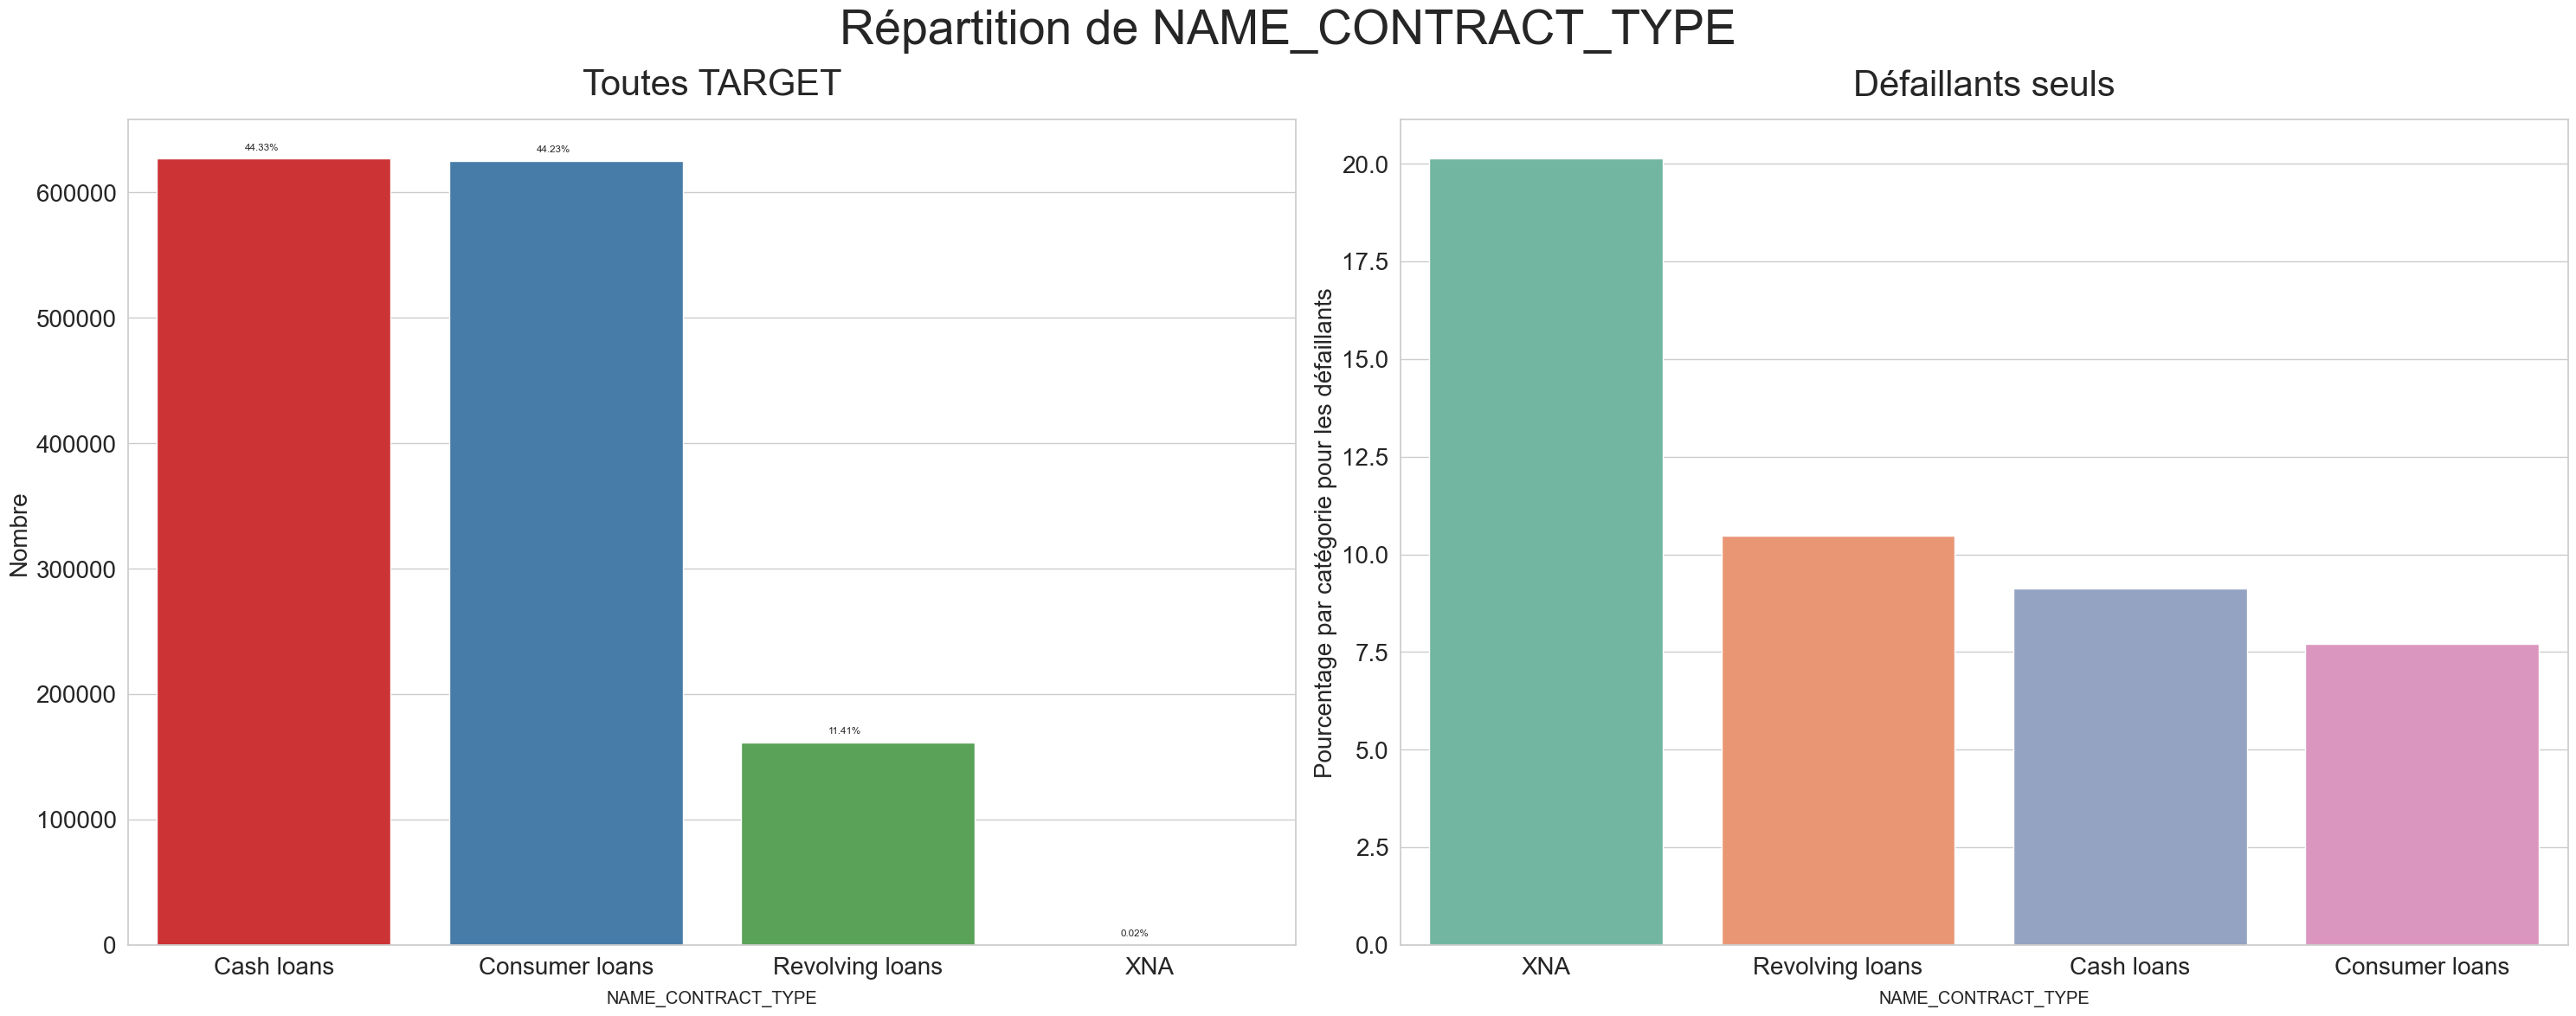

----------------------------------------------------------------------------------------------------


In [73]:
# let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust=0.3, figsize=(30, 12))
print('-'*100)

- **Observations et conclusions :**


A partir des tracés ci-dessus, nous pouvons observer ce qui suit :

 1. A partir du premier subplot, nous constatons que la plupart des prêts précédents ont été soit des prêts cash, soit des prêts à la consommation, ce qui correspond à environ 44 % des prêts chacun. Les 11,41 % restants correspondent à des prêts revolving, et il y a quelques prêts nommés XNA dont les types ne sont en fait pas connus, mais ils sont très peu nombreux.
 
 
 2. En examinant le deuxième subplot, on constate que le pourcentage de défaillants pour les prêts de type XNA est le plus élevé, avec un taux de défaillance de 20 %. Le taux de défaillance suivant le plus élevé est celui des prêts revolvings, qui est proche de 10,5 %.
Les prêts cash ont des taux de défaillance plus faibles, environ 9 %, tandis que les prêts à la consommation ont tendance à avoir le plus faible pourcentage de défaillances, qui est proche de 7,5 %.

- **Distribution de la variable catégorielle NAME_CONTRACT_STATUS**


Cette colonne décrit l'état du contrat du prêt précédent avec le Crédit immobilier, c'est-à-dire s'il est actif ou fermé, etc.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'NAME_CONTRACT_STATUS' sont :
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour NAME_CONTRACT_STATUS = 5


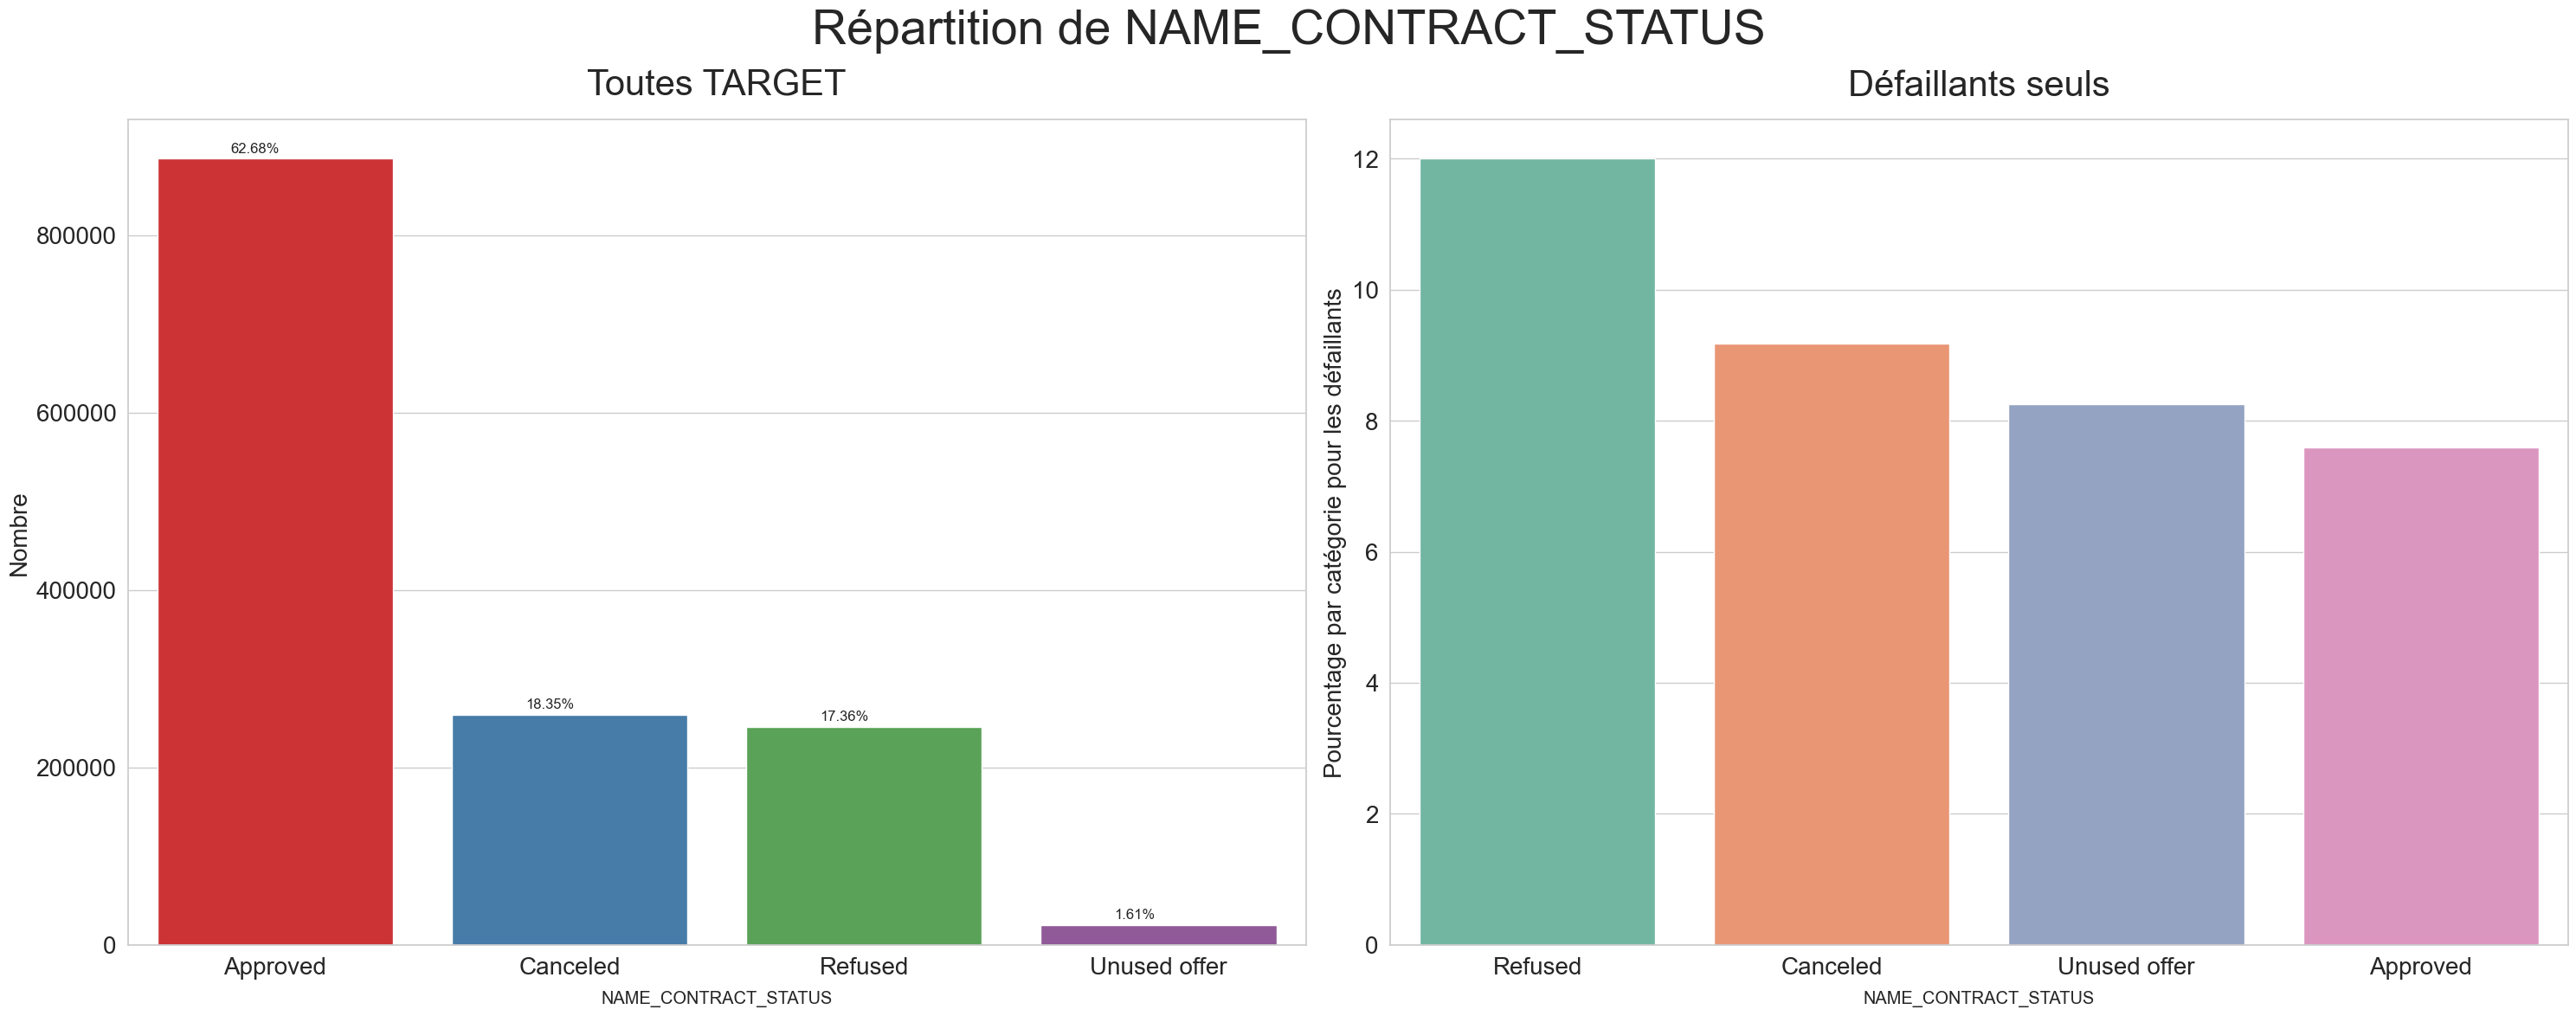

----------------------------------------------------------------------------------------------------


In [74]:
# let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS',
                               horizontal_adjust=0.25, figsize=(30, 12), fontsize_percent='small')
print('-'*100)

- **Observations et conclusions :**


C'est ce que l'on constate à partir des tracés ci-dessus :

1. Le type de statut de contrat le plus courant est le statut approuvé. Environ 63 % des crédits précédents ont un statut approuvé. Les deux statuts suivants sont Annulé et Refusé, qui correspondent tous deux à environ 18% des prêts. Cela signifie que la plupart des prêts sont approuvés et que seule une partie d'entre eux ne le sont pas. Le type de statut de contrat le moins fréquent est Offre non utilisée, qui correspond à seulement 1,61 % de l'ensemble des prêts.
2. En examinant le deuxième sublot pour le pourcentage de mauvais payeurs, nous constatons que les prêts qui avaient auparavant le statut de refus ont tendance à être les plus mauvais payeurs des prêts actuels. Ils correspondent à environ 12 % des défaillants de cette catégorie. Ils sont suivis par les prêts dont le statut a été annulé, qui correspondent à près de 9 % du taux de défaillance. Ce comportement est tout à fait logique, car ces personnes ont dû être refusées parce qu'elles n'avaient pas le profil adéquat. Le taux de défaillance le plus faible est observé pour le statut de contrat Approuvé.

- **Distribution de la variable catégorielle CODE_REJECT_REASON**



Cette colonne décrit la raison du rejet d'un prêt précédemment demandé dans le groupe de crédit immobilier.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CODE_REJECT_REASON' sont :
['XAP' 'LIMIT' nan 'HC' 'SCO' 'SCOFR' 'VERIF' 'CLIENT' 'XNA' 'SYSTEM']
-------------------------------------------------------------------------------
Répartition dans chaque catégorie :
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: CODE_REJECT_REASON, dtype: int64
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CODE_REJECT_REASON = 10


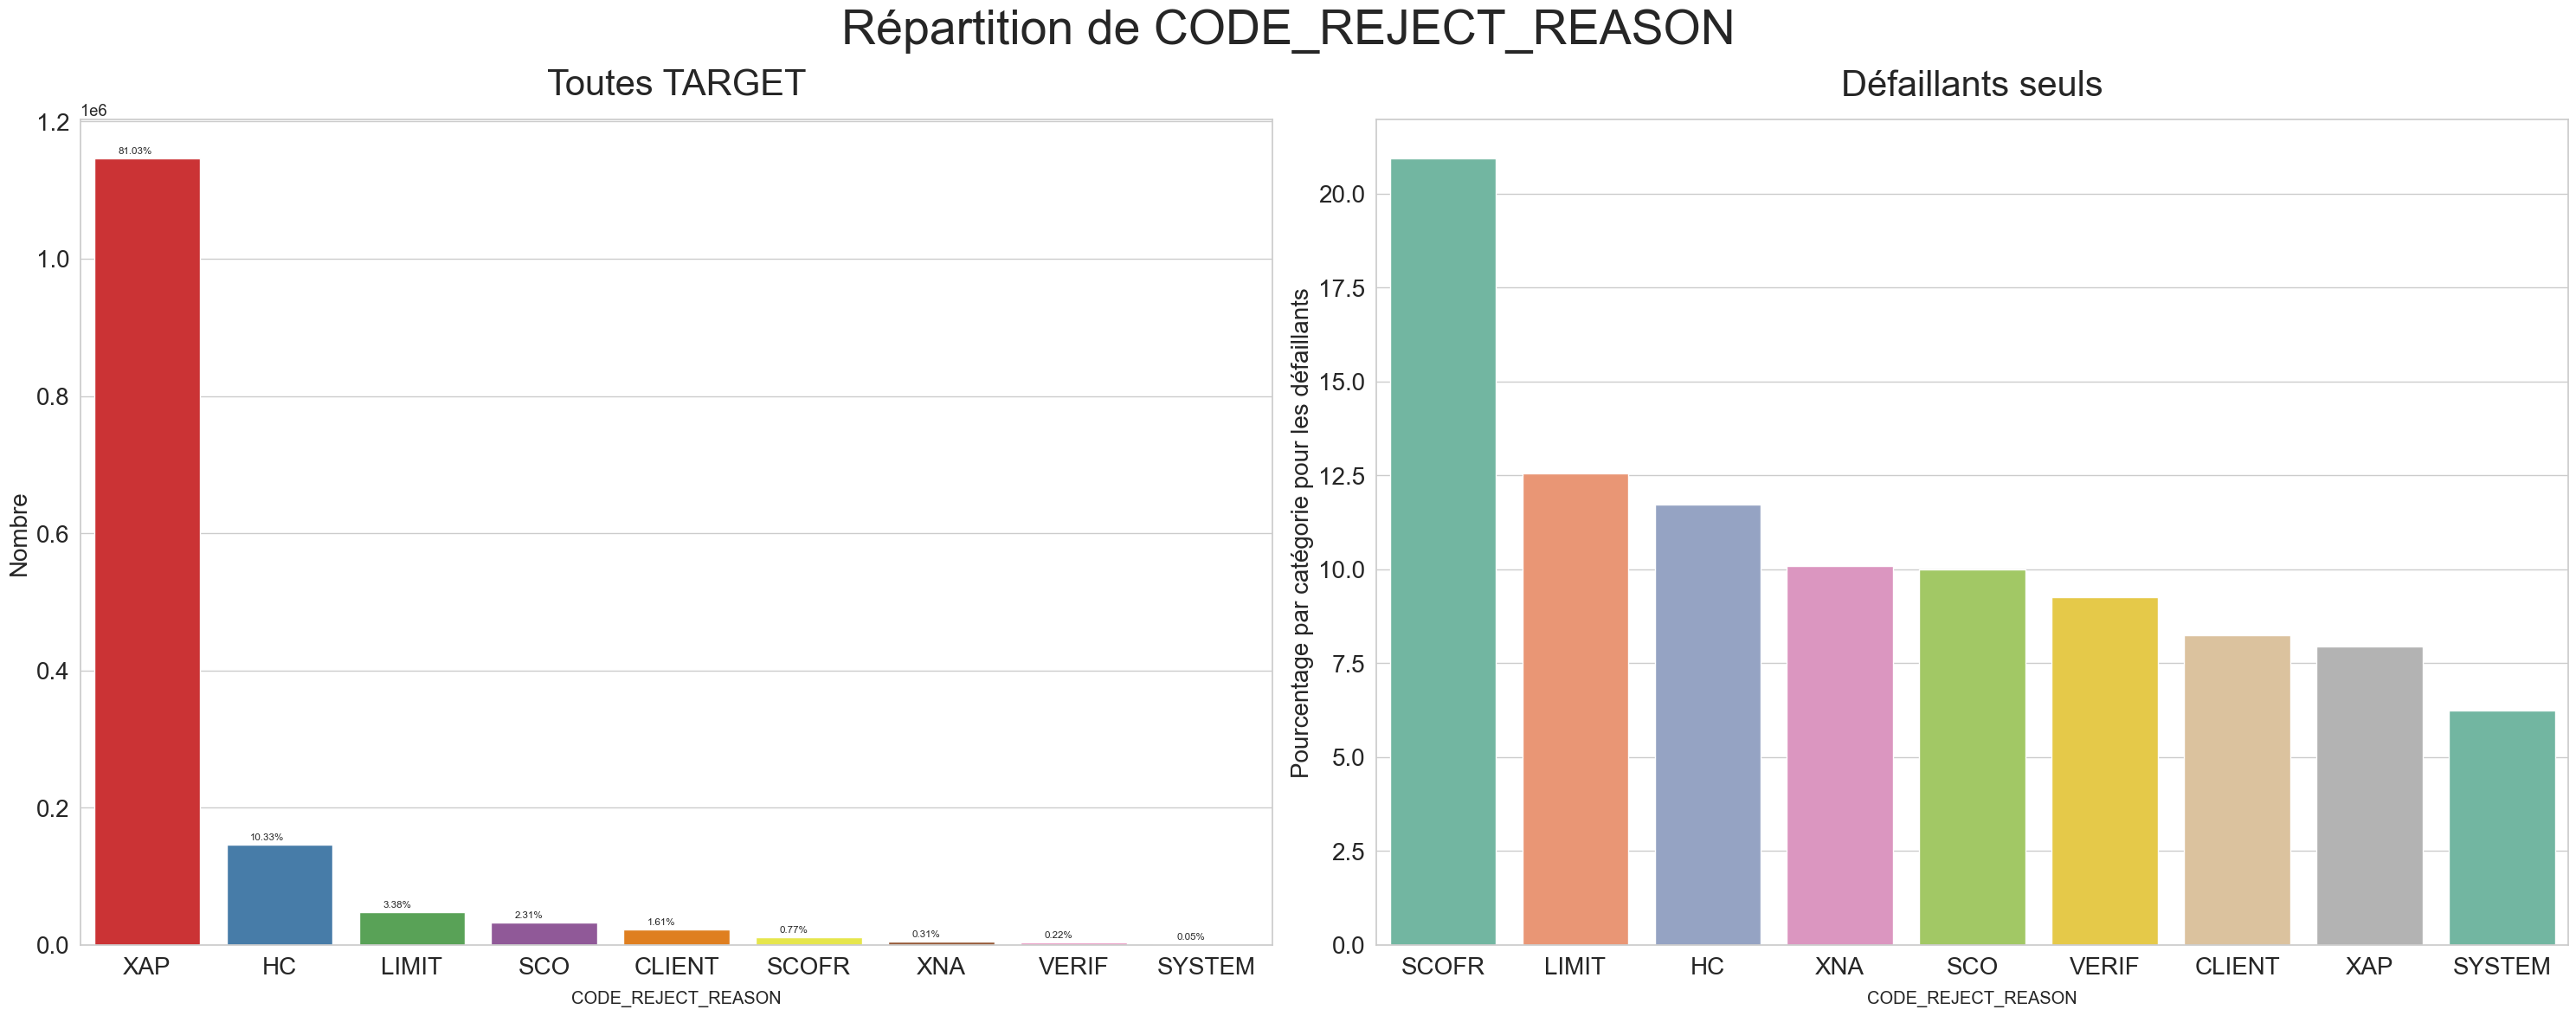

----------------------------------------------------------------------------------------------------


In [75]:
# let us first see the unique categories of 'CODE_REJECT_REASON'
print_unique_categories(prev_merged, 'CODE_REJECT_REASON', show_counts=True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    prev_merged, 'CODE_REJECT_REASON', horizontal_adjust=0.18, figsize=(30,12))
print('-'*100)

- **Observations et conclusions :**


Le graphique ci-dessus montre la distribution de la variable catégorielle CODE_REJECT_REASON. Les observations suivantes peuvent être générées à partir du graphique ci-dessus :

1. Le type de motif de rejet le plus courant est le XAP, qui est d'environ ~81%. Les autres raisons ne représentent qu'une petite partie des motifs de rejet. HC est le deuxième motif de rejet le plus fréquent avec seulement 10,33% des occurrences.
2. La distribution du pourcentage de défaillants pour chaque catégorie de CODE_REJECT_REASON est assez intéressante. Les demandeurs dont les demandes précédentes ont été rejetées par le Code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~21%). Ils sont suivis par LIMIT et HC qui ont environ 12,5 % et 12 % de défaillants.
3. Le motif de rejet le plus courant XAP ne correspond qu'à 7,5% des défaillants, et est le deuxième pourcentage le plus faible de défaillants après le code SYSTEME.

- **Distribution de la variable catégorielle CHANNEL_TYPE**


Cette colonne décrit le canal par lequel le client a été acquis pour le prêt précédent dans le cadre du crédit immobilier.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'CHANNEL_TYPE' sont :
['Stone' 'Credit and cash offices' 'Country-wide' 'Regional / Local'
 'AP+ (Cash loan)' 'Contact center' nan 'Channel of corporate sales'
 'Car dealer']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour CHANNEL_TYPE = 9


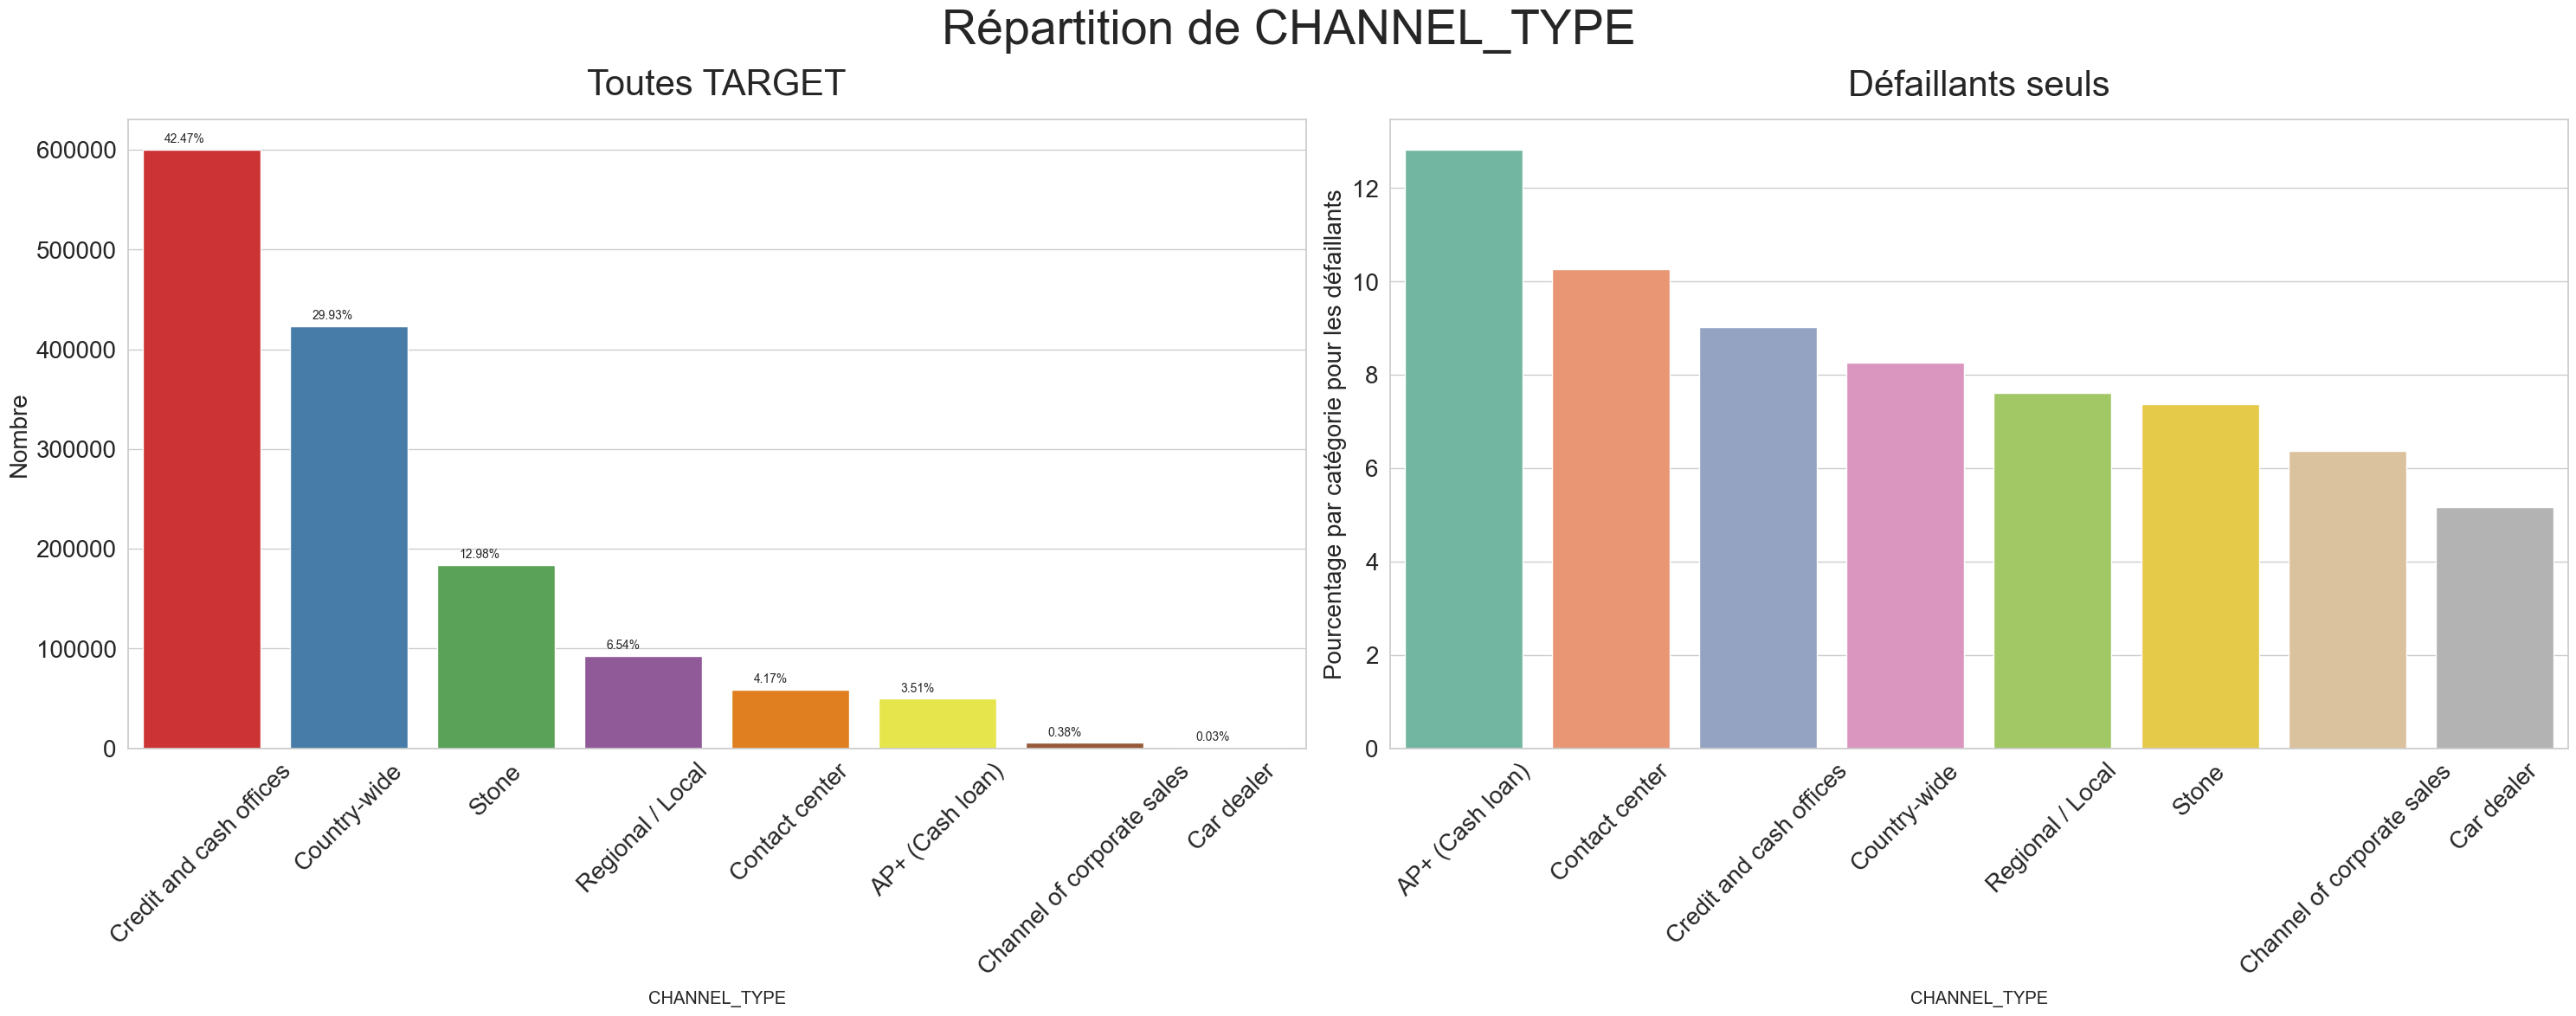

----------------------------------------------------------------------------------------------------


In [76]:
# let us first see the unique categories of 'CHANNEL_TYPE'
print_unique_categories(prev_merged, 'CHANNEL_TYPE')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'CHANNEL_TYPE', horizontal_adjust=0.15,
                               rotation=45, figsize=(30, 12), fontsize_percent='x-small')
print('-'*100)

- **Observations et conclusions**


Les deux graphiques ci-dessus montrent la distribution de CHANNEL_TYPE pour les prêts précédents dans le domaine du crédit immobilier.

1. A partir du premer subplot, nous voyons que la plupart des demandes ont été acquises par le biais des bureaux de crédit et de la caisse, soit environ 42,47% de demandes, qui ont été suivies par le canal national correspondant à 29,93% de demandes. Les autres types de canaux ne correspondent qu'à un nombre limité de demandes.
2. Le pourcentage de défaillances le plus élevé a été observé parmi les demandes qui avaient un type de canal AP+ (prêt en espèces) qui correspondait à environ 13% de défaillances dans cette catégorie. Les autres chaînes avaient des pourcentages de défaut plus faibles que celle-ci. La chaîne Car Dealer a enregistré le plus faible pourcentage de mauvais payeurs dans cette catégorie (seulement 5 %).

- **Distribution de la variable catégorielle PRODUCT_COMBINATION**


Cette colonne donne des détails sur la combinaison de produits des demandes précédentes.

-------------------------------------------------------------------------------
Les catégories uniques de la variable 'PRODUCT_COMBINATION' sont :
['POS other with interest' 'Cash X-Sell: low' 'POS industry with interest'
 'POS household with interest' 'POS mobile without interest' 'Card Street'
 'Card X-Sell' 'Cash X-Sell: high' 'Cash' 'Cash Street: high'
 'Cash X-Sell: middle' 'POS mobile with interest'
 'POS household without interest' 'POS industry without interest'
 'Cash Street: low' nan 'Cash Street: middle'
 'POS others without interest']
-------------------------------------------------------------------------------
Nombre de catégories uniques pour PRODUCT_COMBINATION = 18


C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



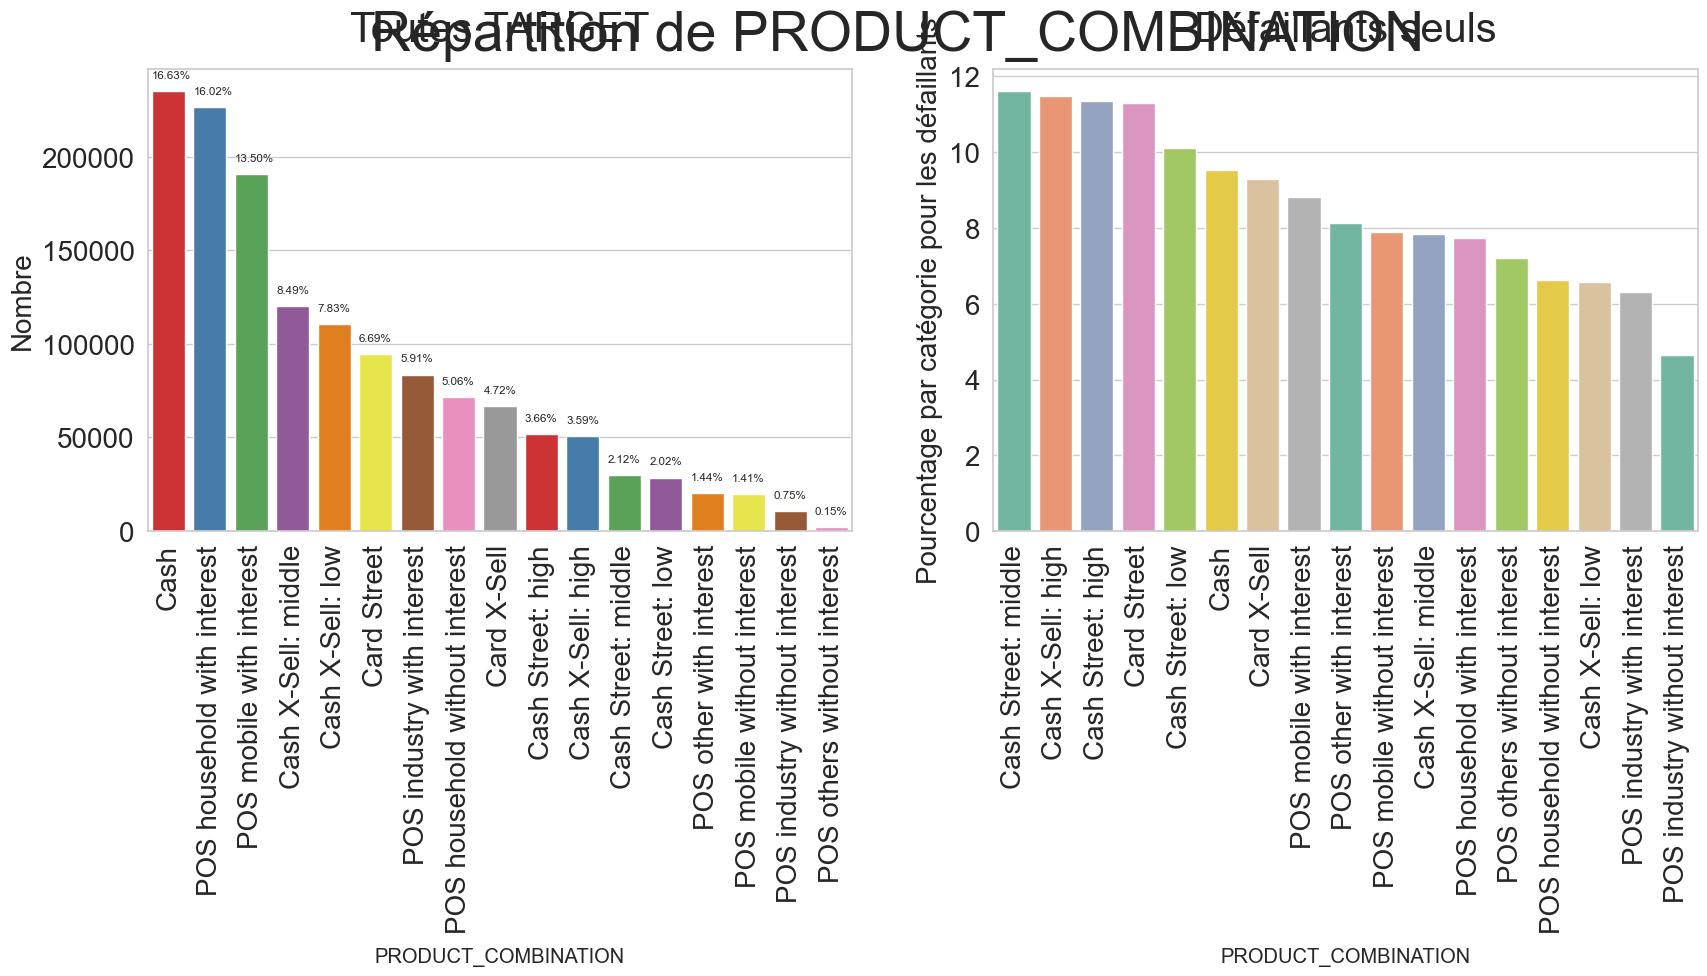

----------------------------------------------------------------------------------------------------


In [77]:
# let us first see the unique categories of 'PRODUCT_COMBINATION'
print_unique_categories(prev_merged, 'PRODUCT_COMBINATION')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    prev_merged, 'PRODUCT_COMBINATION', rotation=90, figsize=(20, 6))
print('-'*100)

- **Observations et conclusions**


La distribution de PRODUCT_COMBINATION nous permet de dégager les enseignements suivants :

1. Les 3 types de combinaison de produits les plus courants sont l'argent liquide, les points de vente domestiques avec intérêts et les points de vente mobiles avec intérêts. Ils correspondent à environ 50 % de toutes les applications.
2. En examinant le graphique du pourcentage de mauvais payeurs par catégorie, on constate une tendance à la hausse des mauvais payeurs parmi les catégories Cash Street : mobile, Cash X-sell : high, Cash Street : high et Card Street qui sont toutes proches de 11-11,5% de mauvais payeurs par catégorie. Le pourcentage le plus faible de défaillants se trouve dans la catégorie "secteur des points de vente sans intérêt", qui correspond à environ 4,5 % de défaillants.

 - **Distribution de * Variable avec DAYS (jours) Features**

**DAYS_DECISION**



Cette colonne indique le nombre de jours relatifs à la demande en cours lorsque la décision a été prise sur la demande précédente.



C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:74: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\76260328.py:76: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




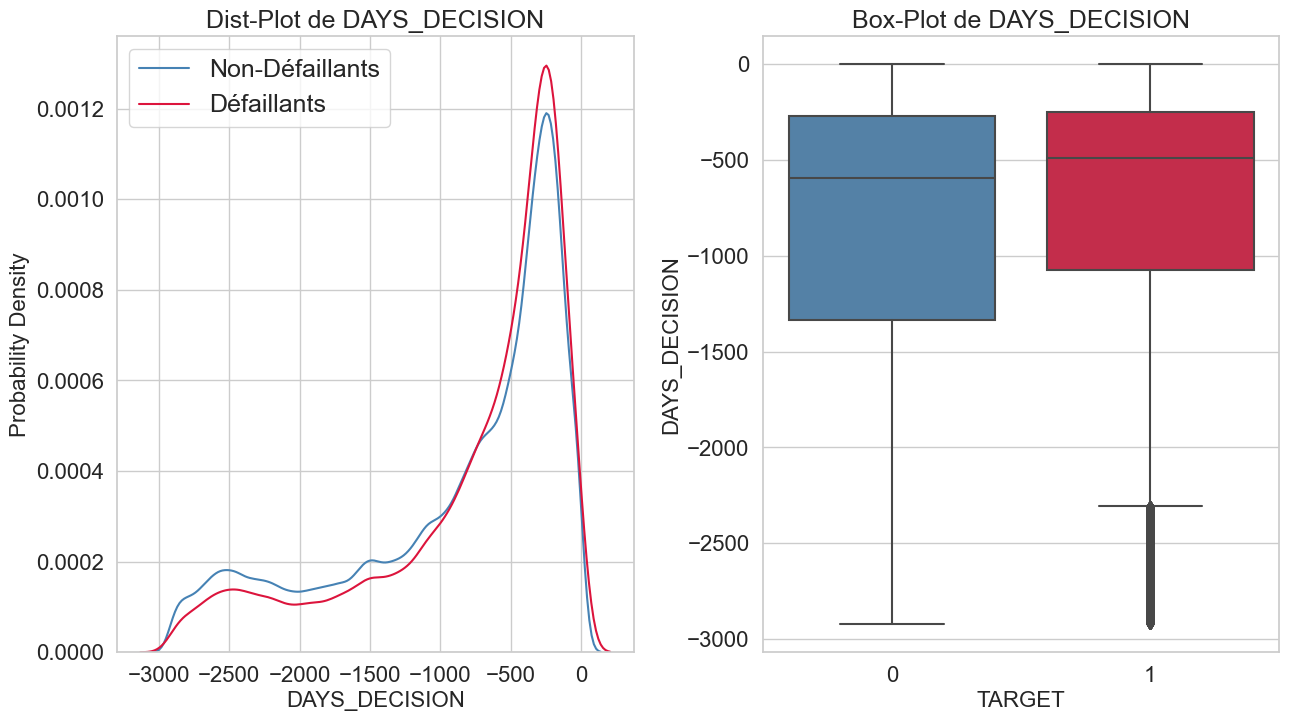

In [78]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots=[
                          'distplot', 'box'], figsize=(15, 8))

- **Observations et conclusions**


D'après le graphique ci-dessus, nous constatons que pour les défaillants, le nombre de jours à partir desquels la décision a été prise est un peu moins élevé que pour les non défaillants. Cela signifie que les défaillants ont généralement reçu la décision relative à leurs demandes antérieures plus récemment que les non défaillants.

**DAYS_FIRST_DRAWING**



Cette colonne indique le nombre de jours écoulés depuis la demande actuelle jusqu'à ce que le premier versement de la demande précédente ait été effectué.

-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_FIRST_DRAWING
Pecentile 0 = -2922.0
Pecentile 1 = -2451.0
Pecentile 2 = -1179.0
Pecentile 3 = -674.0
Pecentile 4 = -406.0
Pecentile 5 = -262.0
Pecentile 6 = -156.0
Pecentile 7 = 365243.0
Pecentile 8 = 365243.0
Pecentile 9 = 365243.0
Pecentile 10 = 365243.0
Pecentile 20 = 365243.0
Pecentile 40 = 365243.0
Pecentile 60 = 365243.0
Pecentile 80 = 365243.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------


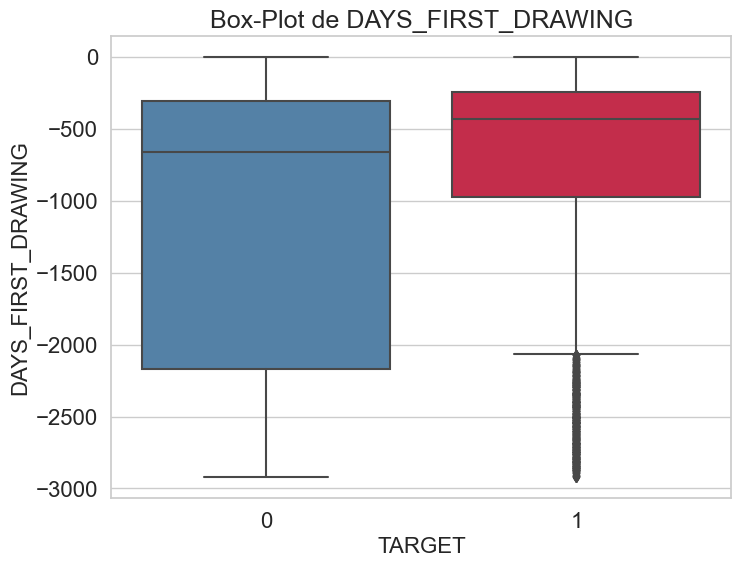

----------------------------------------------------------------------------------------------------


In [79]:
print_percentiles(prev_merged, 'DAYS_FIRST_DRAWING',
                  percentiles=list(range(0, 11)) + list(range(20, 101, 20)))
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots=[
                          'box'], figsize=(8, 6), scale_limits=[-3000, 0])
print('-'*100)

- **Observations et conclusions :**


1. En regardant les valeurs de percentile de DAYS_FIRST_DRAWING, il semble que la plupart des valeurs soient erronées, à partir du 7e percentile lui-même. Ces valeurs erronées devront être supprimées.
2. Si nous essayons d'analyser la distribution de cette colonne en supprimant les ponts erronés, nous constatons que la plupart des défaillants ont eu leur premier tirage sur un crédit antérieur plus récemment que les non défaillants. La valeur du 75e percentile pour les défaillants est également nettement inférieure à celle des non défaillants.

**DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION**



Ces colonnes décrivent également le nombre de jours écoulés depuis l'application actuelle pendant lesquels certaines activités ont eu lieu

In [80]:
print('-'*100)
print("Percentile Values for DAYS_FIRST_DUE")
print_percentiles(prev_merged, 'DAYS_FIRST_DUE', percentiles=list(
    range(0, 11, 2)) + [20, 40, 60, 80, 100])
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION")
print_percentiles(prev_merged, 'DAYS_LAST_DUE_1ST_VERSION',
                  percentiles=list(range(0, 11, 2)) + [20, 40, 60, 80, 100])
print("Percentile Values for DAYS_LAST_DUE")
print_percentiles(prev_merged, 'DAYS_LAST_DUE', percentiles=list(
    range(0, 11, 2)) + [20, 40, 60, 80, 100])
print("Percentile Values for DAYS_TERMINATION")
print_percentiles(prev_merged, 'DAYS_TERMINATION', percentiles=list(
    range(0, 11, 2)) + [20, 40, 60, 80, 100])

----------------------------------------------------------------------------------------------------
Percentile Values for DAYS_FIRST_DUE
-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_FIRST_DUE
Pecentile 0 = -2892.0
Pecentile 2 = -2759.0
Pecentile 4 = -2648.0
Pecentile 6 = -2555.0
Pecentile 8 = -2471.0
Pecentile 10 = -2388.0
Pecentile 20 = -1882.0
Pecentile 40 = -1070.0
Pecentile 60 = -647.0
Pecentile 80 = -329.0
Pecentile 100 = 365243.0
-------------------------------------------------------------------------------
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
-------------------------------------------------------------------------------
Pecentiles de la variable DAYS_LAST_DUE_1ST_VERSION
Pecentile 0 = -2801.0
Pecentile 2 = -2516.0
Pecentile 4 = -2380.0
Pecentile 6 = -2267.0
Pecentile 8 = -2159.0
Pecentile 10 = -2045.0
Pecentile 20 = -1498.0
Pecentile 40 = -644.0
Pecentile 60 = -146.0
Pecentile 80 = 273.0
Pecentile 10

- **Observations et conclusions**



A partir de toutes les valeurs de percentile ci-dessus, nous nous rendons compte que toutes les colonnes de Days ont ces valeurs erronées quelque part. Ces valeurs doivent donc être remplacées afin que notre modèle ne soit pas affecté par celles-ci.



## Conclusions de l'EDA


L'analyse exhaustive des données d'exportation que nous avons effectuée nous permet de tirer des conclusions de haut niveau sur notre ensemble de données.

1. Premièrement, l'ensemble des données devra être fusionné avec une méthode ingénieuse pour que les données fusionnées aient un sens.
2. Certaines catégories sont très bien discriminatoires entre les défaillants et les non défaillants, ce qui pourrait être important aux fins de la classification.
3. Il y a peu de variables numériques continues qui contiennent des points erronés, nous devrions traiter ces points.
4. Nous avons également remarqué certaines caractéristiques corrélées, qui ne feraient qu'augmenter la dimensionnalité des données, sans grande valeur ajoutée. Nous voudrions supprimer ces caractéristiques.
5. L'ensemble des données est globalement déséquilibré et nous devrions trouver des techniques pour gérer ce déséquilibre.
6. Pour la prévision du risque de défaillance, les défaillants ont généralement tendance à avoir un comportement qui n'est pas normal, et nous ne pouvons donc pas supprimer les valeurs aberrantes ou les points éloignés, car ils peuvent suggérer une importante tendance à la défaillance.
7. Avec tous ces éléments, nous allons passer au cleaning et au feature engineering.
 

# 2 . FEATURES ENGINEERING 

Cette partie est inspirée du notebook kaggle suivant https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/

- **Les idées clés suivantes ont été utilisées :**

    - Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
    - Dans les données du bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
    - Dans les demandes précédentes : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
    - Encodage unique pour les caractéristiques catégorielles
    
    
    
- Toutes les tables sont jointes en utilisant la clé **SK_ID_CURR**(ID du client)

Database preparation¶
The cell below has been taken from Olivier G's Kaggle notebook (https://www.kaggle.com/code/ogrellier/lighgbm-with-selected-features/log).

In [82]:
features_with_no_imp_at_least_twice = [
    'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'BURO_CREDIT_ACTIVE_nan_MEAN',
    'BURO_CREDIT_CURRENCY_currency 1_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
    'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN',
    'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
    'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
    'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
    'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
    'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
    'BURO_STATUS_nan_MEAN_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_INST_MIN_REGULARITY_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
    'CC_AMT_RECIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MIN', 'CC_AMT_TOTAL_RECEIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_VAR',
    'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
    'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'CC_CNT_INSTALMENT_MATURE_CUM_MIN', 'CC_COUNT', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_SUM', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Active_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_SUM', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_MAX',
    'CC_NAME_CONTRACT_STATUS_Completed_MEAN', 'CC_NAME_CONTRACT_STATUS_Completed_MIN', 'CC_NAME_CONTRACT_STATUS_Completed_SUM', 'CC_NAME_CONTRACT_STATUS_Completed_VAR',
    'CC_NAME_CONTRACT_STATUS_Demand_MAX', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_SUM',
    'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_MAX', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
    'CC_NAME_CONTRACT_STATUS_Refused_SUM', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CC_NAME_CONTRACT_STATUS_Signed_MAX', 'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_NAME_CONTRACT_STATUS_Signed_MIN',
    'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
    'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_DEF_MAX',
    'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_SUM',
    'CC_SK_DPD_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
    'CNT_CHILDREN', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_MODE', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLOORSMAX_MODE',
    'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'LIVE_REGION_NOT_WORK_REGION',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents',
    'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
    'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN', 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
    'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN', 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
    'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture',
    'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Culture',
    'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
    'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12',
    'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4',
    'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8',
    'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Postal',
    'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1',
    'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5',
    'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
    'ORGANIZATION_TYPE_XNA', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
    'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
    'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'PREV_CODE_REJECT_REASON_VERIF_MEAN',
    'PREV_CODE_REJECT_REASON_XNA_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
    'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
    'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN', 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN', 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN', 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN', 'PREV_NAME_GOODS_CATEGORY_Other_MEAN', 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
    'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN', 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
    'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_TYPE_SUITE_Group of people_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
    'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Wooden', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY'
]

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows)
    df['Test'] = False
    test_df = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv', nrows= num_rows)
    test_df['Test'] = True
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    active_agg = active_agg.reset_index()

    bureau_agg = bureau_agg.reset_index()
    bureau_agg = bureau_agg.merge(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.merge(closed_agg, how='left', on='SK_ID_CURR')
    
    for e in cols:
        bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    approved_agg = approved_agg.reset_index()
    prev_agg = prev_agg.merge(approved_agg, how='left', on='SK_ID_CURR')
    prev_agg = prev_agg.reset_index()
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    
    for e in cols:
        prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('C:/Users/hassi/Downloads/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None   # option to run only on 10000 rows if True
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.merge(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.merge(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.merge(pos.reset_index(), how='left', on='SK_ID_CURR')
        del pos

        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.merge(ins.reset_index(), how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.merge(cc.reset_index(), how='left', on='SK_ID_CURR')
        del cc

        gc.collect()
    with timer("Final operations"):
        print(df.shape)
        df.drop(features_with_no_imp_at_least_twice, axis=1, inplace=True)
        gc.collect()
        print(df.shape)
    return(df)

In [83]:
df = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 144)
Process bureau and bureau_balance - done in 37s


C:\Users\hassi\AppData\Local\Temp\ipykernel_28452\3993984188.py:260: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Previous applications df shape: (338857, 281)
Process previous_applications - done in 68s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 32s
Installments payments df shape: (339587, 26)
Process installments payments - done in 59s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 50s
(356251, 872)
(356251, 533)
Final operations - done in 1s


In [84]:
# Verify the length of each subset according to the Test variable we added
print(len(df.loc[df['Test'] == True]))
print(len(df.loc[df['Test'] == False]))
print(len(df))

48744
307507
356251


In [85]:
df.describe()

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning:

invalid value encountered in subtract

C:\Users\hassi\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:4527: Runtim

index_x     SK_ID_CURR        TARGET    CODE_GENDER  \
count  356251.000000  356251.000000  307507.00000  356251.000000   
mean   136052.869904  278128.870078       0.08073       0.660001   
std     93841.582375  102842.068890       0.27242       0.473709   
min         0.000000  100001.000000       0.00000       0.000000   
25%     44532.000000  189065.500000       0.00000       0.000000   
50%    129384.000000  278129.000000       0.00000       1.000000   
75%    218447.500000  367192.500000       0.00000       1.000000   
max    307510.000000  456255.000000       1.00000       1.000000   

       FLAG_OWN_REALTY  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  \
count    356251.000000      3.562510e+05  3.562510e+05  356215.000000   
mean          0.306764      1.701159e+05  5.877695e+05   27425.644390   
std           0.461151      2.235080e+05  3.986253e+05   14732.860946   
min           0.000000      2.565000e+04  4.500000e+04    1615.500000   
25%           0.000000      1.125000e+05  2.700000e+05   16731.000000   
50%           0.000000      1.530000e+05  5.002110e+05   25078.500000   
75%           1.000000      2.025000e+05  7.975575e+05   34960.500000   
max           1.000000      1.170000e+08  4.050000e+06  258025.500000   

       AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  ...  \
count     3.559730e+05               356251.000000  ...   
mean      5.280212e+05                    0.020917  ...   
std       3.660657e+05                    0.013915  ...   
min       4.050000e+04                    0.000253  ...   
25%       2.340000e+05                    0.010006  ...   
50%       4.500000e+05                    0.018850  ...   
75%       6.750000e+05                    0.028663  ...   
max       4.050000e+06                    0.072508  ...   

       CC_CNT_DRAWINGS_POS_CURRENT_MAX  CC_CNT_DRAWINGS_POS_CURRENT_MEAN  \
count                     72194.000000                      72194.000000   
mean                          6.500277                          1.760667   
std                          11.755416                          4.282159   
min                           0.000000                          0.000000   
25%                           0.000000                          0.000000   
50%                           1.000000                          0.052083   
75%                           8.000000                          1.468750   
max                         165.000000                        118.250000   

       CC_CNT_DRAWINGS_POS_CURRENT_VAR  CC_CNT_INSTALMENT_MATURE_CUM_MEAN  \
count                     71692.000000                      103558.000000   
mean                         18.022367                          10.066951   
std                          74.904523                          13.536168   
min                           0.000000                           0.000000   
25%                           0.000000                           0.000000   
50%                           0.062500                           3.800000   
75%                           5.347968                          14.965517   
max                        3528.142857                          73.062500   

       CC_CNT_INSTALMENT_MATURE_CUM_SUM  CC_CNT_INSTALMENT_MATURE_CUM_VAR  \
count                     103558.000000                     102866.000000   
mean                         710.889106                         64.564809   
std                         1248.100465                        142.123958   
min                            0.000000                          0.000000   
25%                            0.000000                          0.000000   
50%                           48.000000                          6.000000   
75%                          715.000000                         42.166667   
max                         8124.000000                       1078.031746   

       CC_SK_DPD_DEF_MEAN  CC_NAME_CONTRACT_STATUS_Active_MEAN  \
count       103558.000000                        103558.000000   
mean 

In [86]:
# Checking the data augmentation validity
nb_inf = np.isinf(df).values.sum()
print("There are: ", nb_inf, " infite values over ", 356251*532, "observations (", nb_inf/round(356251*532), "%)")

There are:  659233  infite values over  189525532 observations ( 0.0034783334627442176 %)


In [87]:
# Replace inf (-/+) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
nb_inf = np.isinf(df).values.sum()
print("There are: ", nb_inf, " infite values over ", 356251*532, "observations (", nb_inf/round(356251*532)*100, "%)")

There are:  0  infite values over  189525532 observations ( 0.0 %)


In [88]:
# Count new number of NaN
nb_na = df.isna().sum()
print("There are: ", nb_na.sum(), " NaN over ", 356251*532, "observations (", nb_na.sum()/round(356251*532)*100, "%)")

There are:  58571984  NaN over  189525532 observations ( 30.904534804313332 %)


In [89]:
# Train - test split as the initial decomposition
df_train = df.loc[~df['Test'], : ]
df_test = df.loc[df['Test'], : ]

# Ensure all data is stored as floats
df_train = df_train.astype(np.float64)
df_train.drop(columns=["Test"], inplace=True)
df_test = df_test.astype(np.float64)
df_test.drop(columns=["Test"], inplace=True)

In [90]:
# Saving the test set to be upload to Azure for the app
df_test.to_csv('df_test_zip', compression='zip')

In [91]:
df_train.to_csv('df_train_h')

In [92]:
# Saving the test set to be upload to Azure for the app
df_test.to_csv('df_test_h')

In [93]:
df_train

index_x  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_REALTY  \
0            0.0    100002.0     1.0          0.0              0.0   
1            1.0    100003.0     0.0          1.0              1.0   
2            2.0    100004.0     0.0          0.0              0.0   
3            3.0    100006.0     0.0          1.0              0.0   
4            4.0    100007.0     0.0          0.0              0.0   
...          ...         ...     ...          ...              ...   
307502  307506.0    456251.0     0.0          0.0              1.0   
307503  307507.0    456252.0     0.0          1.0              0.0   
307504  307508.0    456253.0     0.0          1.0              0.0   
307505  307509.0    456254.0     1.0          1.0              0.0   
307506  307510.0    456255.0     0.0          1.0              1.0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               202500.0    406597.5      24700.5         351000.0   
1               270000.0   1293502.5      35698.5        1129500.0   
2                67500.0    135000.0       6750.0         135000.0   
3               135000.0    312682.5      29686.5         297000.0   
4               121500.0    513000.0      21865.5         513000.0   
...                  ...         ...          ...              ...   
307502          157500.0    254700.0      27558.0         225000.0   
307503           72000.0    269550.0      12001.5         225000.0   
307504          153000.0    677664.0      29979.0         585000.0   
307505          171000.0    370107.0      20205.0         319500.0   
307506          157500.0    675000.0      49117.5         675000.0   

        REGION_POPULATION_RELATIVE  ...  CC_CNT_DRAWINGS_POS_CURRENT_MAX  \
0                         0.018801  ...                              NaN   
1                         0.003541  ...                              NaN   
2                         0.010032  ...                              NaN   
3                         0.008019  ...                              NaN   
4                         0.028663  ...                              NaN   
...                            ...  ...                              ...   
307502                    0.032561  ...                              NaN   
307503                    0.025164  ...                              NaN   
307504                    0.005002  ...                              NaN   
307505                    0.005313  ...                              NaN   
307506                    0.046220  ...                              NaN   

        CC_CNT_DRAWINGS_POS_CURRENT_MEAN  CC_CNT_DRAWINGS_POS_CURRENT_VAR  \
0                                    NaN                              NaN   
1                                    NaN                              NaN   
2                                    NaN                              NaN   
3                                    NaN                              NaN   
4                                    NaN                              NaN   
...                                  ...                              ...   
307502                               NaN                              NaN   
307503                               NaN                              NaN   
307504                               NaN                              NaN   
307505                               NaN                              NaN   
307506                               NaN                              NaN   

        CC_CNT_INSTALMENT_MATURE_CUM_MEAN  CC_CNT_INSTALMENT_MATURE_CUM_SUM  \
0                                     NaN                               NaN   
1                                     NaN                               NaN   
2                                     NaN                               NaN   
3                                     0.0                               0.0   
4                                     NaN                               NaN   
...            

In [94]:
df_test

index_x  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_REALTY  \
307507      0.0    100001.0     NaN          1.0              0.0   
307508      1.0    100005.0     NaN          0.0              0.0   
307509      2.0    100013.0     NaN          0.0              0.0   
307510      3.0    100028.0     NaN          1.0              0.0   
307511      4.0    100038.0     NaN          0.0              1.0   
...         ...         ...     ...          ...              ...   
356246  48739.0    456221.0     NaN          1.0              0.0   
356247  48740.0    456222.0     NaN          1.0              1.0   
356248  48741.0    456223.0     NaN          1.0              0.0   
356249  48742.0    456224.0     NaN          0.0              1.0   
356250  48743.0    456250.0     NaN          1.0              1.0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
307507          135000.0    568800.0      20560.5         450000.0   
307508           99000.0    222768.0      17370.0         180000.0   
307509          202500.0    663264.0      69777.0         630000.0   
307510          315000.0   1575000.0      49018.5        1575000.0   
307511          180000.0    625500.0      32067.0         625500.0   
...                  ...         ...          ...              ...   
356246          121500.0    412560.0      17473.5         270000.0   
356247          157500.0    622413.0      31909.5         495000.0   
356248          202500.0    315000.0      33205.5         315000.0   
356249          225000.0    450000.0      25128.0         450000.0   
356250          135000.0    312768.0      24709.5         270000.0   

        REGION_POPULATION_RELATIVE  ...  CC_CNT_DRAWINGS_POS_CURRENT_MAX  \
307507                    0.018850  ...                              NaN   
307508                    0.035792  ...                              NaN   
307509                    0.019101  ...                              0.0   
307510                    0.026392  ...                             12.0   
307511                    0.010032  ...                              NaN   
...                            ...  ...                              ...   
356246                    0.002042  ...                              NaN   
356247                    0.035792  ...                              NaN   
356248                    0.026392  ...                              NaN   
356249                    0.018850  ...                              NaN   
356250                    0.006629  ...                              0.0   

        CC_CNT_DRAWINGS_POS_CURRENT_MEAN  CC_CNT_DRAWINGS_POS_CURRENT_VAR  \
307507                               NaN                              NaN   
307508                               NaN                              NaN   
307509                          0.000000                         0.000000   
307510                          2.613636                         8.475159   
307511                               NaN                              NaN   
...                                  ...                              ...   
356246                               NaN                              NaN   
356247                               NaN                              NaN   
356248                               NaN                              NaN   
356249                               NaN                              NaN   
356250                          0.000000                         0.000000   

        CC_CNT_INSTALMENT_MATURE_CUM_MEAN  CC_CNT_INSTALMENT_MATURE_CUM_SUM  \
307507                                NaN                               NaN   
307508                                NaN                               NaN   
307509                          18.719101                            1666.0   
307510                          19.547619                             821.0   
307511                                NaN                               NaN   
...                       